# Google Analytics Customer Revenue Prediction

- The 80/20 rule has proven true for many businesses–only a small percentage of customers produce most of the revenue. As such, marketing teams are challenged to make appropriate investments in promotional strategies.

- In this case study, we analyze a Google Merchandise Store (also known as GStore, where Google swag is sold) customer dataset to predict revenue per customer. Hopefully, the outcome will be more actionable operational changes and a better use of marketing budgets for those companies who choose to use data analysis on top of GA data.

## Evaluation

Submissions are scored on the root mean squared error. RMSE is defined as:

$\begin{align}\textrm{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2},\end{align}$

where y hat is the natural log of the predicted revenue for a customer and y is the natural log of the actual summed revenue value plus one.

<h3>About the dataset:</h3>

We are given two datasets - <b>train.csv</b> and <b>test.csv</b>

Each row in the datasets is one visit to the store. We are predicting the natural log of the sum of all transactions per user.

The data fields in the given files are

- fullVisitorId- A unique identifier for each user of the Google Merchandise Store.
- channelGrouping - The channel via which the user came to the Store.
- date - The date on which the user visited the Store.
- device - The specifications for the device used to access the Store.
- geoNetwork - This section contains information about the geography of the user.
- sessionId - A unique identifier for this visit to the store.
- socialEngagementType - Engagement type, either "Socially Engaged" or "Not Socially Engaged".
- totals - This section contains aggregate values across the session.
- trafficSource - This section contains information about the Traffic Source from which the session originated.
- visitId - An identifier for this session. This is part of the value usually stored as the _utmb cookie. This is only unique to the user. For a completely unique ID, you should use a combination of fullVisitorId and visitId.
- visitNumber - The session number for this user. If this is the first session, then this is set to 1.
- visitStartTime - The timestamp (expressed as POSIX time).
- Also it is important to note that some of the fields are in json format.

### What am I predicting?

- In the Kaggle competition, we have to take all the unique fullVisitorId's from the test dataset and predict the <b>Total Revenue </b> for each full visitor ID for their future transactions of 1st December 2018 - 31st January 2019.
-  Due to the formatting of fullVisitorId, we must load the Id's as strings in order for all Id's to be properly unique!
- Since We'ew not doing this competition as a kaggle competition, we will do all of our predictions on the test_v2.csv data using train_v2.csv as training data.

### Problem Trnasformation

- We transform this problem into a non-time series regression problem. This is because we have to predict for each user the estimated revenue that the user is likely to generate. And since a user who visits once may not visit again, we will solve this as a normal - regression type problem.

### Constraints

- For this problem, there are no constraints as such. The results of this problem will help GStore marketing team make better decisions when it comes to marketing practices. However, wrong information can lead to mismanagement of money allocation in marketing practices.

More about the problem here : https://www.kaggle.com/c/ga-customer-revenue-prediction/data

In [43]:
#https://pypi.org/project/plotly/
#plotly provides amazing visualizations - better than matplotlib!(another alternative is bokeh but plotly is better)
import pandas as pd
import dask.dataframe as dd
import numpy as np 
import json
#import bq_helper
from pandas.io.json import json_normalize
import seaborn as sns 
import matplotlib.pyplot as plt 
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from plotly import tools
from plotly import subplots
import sys
import csv
import os
import json
from pandas.io.json import json_normalize
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import hstack,vstack
from sklearn.model_selection import train_test_split
from sklearn import model_selection, preprocessing, metrics
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
import sklearn
import plotly.io as pio
pio.renderers.default='notebook'
init_notebook_mode(connected=True)
import pickle

In [111]:
#import os
#os.rename('train_v2.csv', 'trainset.csv')
#os.rename('test_v2.csv','testset.csv')

In [2]:
#incase you receive an overflow error while loading the csv files, run this cell
#otherwise, skip this cell
'''maxInt = sys.maxsize

while True:
    # decrease the maxInt value by factor 10 
    # as long as the OverflowError occurs.

    try:
        csv.field_size_limit(maxInt)
        break
    except OverflowError:
        maxInt = int(maxInt/10)'''

In [3]:
#Loading the test and train datasets
df_train = pd.read_csv('trainset.csv',nrows=10)
df_test = pd.read_csv('testset.csv',nrows = 10)

In [4]:
df_train.head(2)

,channelGrouping,customDimensions,date,device,fullVisitorId,geoNetwork,hits,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime
0,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,"{""browser"": ""Firefox"", ""browserVersion"": ""not ...",3162355547410993243,"{""continent"": ""Europe"", ""subContinent"": ""Weste...","[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1508198450,1,1508198450
1,Referral,"[{'index': '4', 'value': 'North America'}]",20171016,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",8934116514970143966,"{""continent"": ""Americas"", ""subContinent"": ""Nor...","[{'hitNumber': '1', 'time': '0', 'hour': '10',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...","{""referralPath"": ""/a/google.com/transportation...",1508176307,6,1508176307


In [5]:
df_test.head(2)

,channelGrouping,customDimensions,date,device,fullVisitorId,geoNetwork,hits,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime
0,Organic Search,"[{'index': '4', 'value': 'APAC'}]",20180511,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",7460955084541987166,"{""continent"": ""Asia"", ""subContinent"": ""Souther...","[{'hitNumber': '1', 'time': '0', 'hour': '21',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""4"", ""pageviews"": ""3"",...","{""referralPath"": ""(not set)"", ""campaign"": ""(no...",1526099341,2,1526099341
1,Direct,"[{'index': '4', 'value': 'North America'}]",20180511,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",460252456180441002,"{""continent"": ""Americas"", ""subContinent"": ""Nor...","[{'hitNumber': '1', 'time': '0', 'hour': '11',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""4"", ""pageviews"": ""3"",...","{""referralPath"": ""(not set)"", ""campaign"": ""(no...",1526064483,166,1526064483


- we see that quite a few of these columns have nested values, namely custom dimensions, device, geoNetwork, hits

In [6]:
#Exploring one value under the hit column
df_train.iloc[0,6]

"[{'hitNumber': '1', 'time': '0', 'hour': '17', 'minute': '0', 'isInteraction': True, 'isEntrance': True, 'isExit': True, 'referer': 'https://www.google.co.uk/search?q=water+bottle&ie=utf-8&num=100&oe=utf-8&hl=en&gl=GB&uule=w+CAIQIFISCamRx0IRO1oCEXoliDJDoPjE&glp=1&gws_rd=cr&fg=1', 'page': {'pagePath': '/google+redesign/bags/water+bottles+and+tumblers', 'hostname': 'shop.googlemerchandisestore.com', 'pageTitle': 'Water Bottles & Tumblers | Drinkware | Google Merchandise Store', 'pagePathLevel1': '/google+redesign/', 'pagePathLevel2': '/bags/', 'pagePathLevel3': '/water+bottles+and+tumblers', 'pagePathLevel4': ''}, 'transaction': {'currencyCode': 'USD'}, 'item': {'currencyCode': 'USD'}, 'appInfo': {'screenName': 'shop.googlemerchandisestore.com/google+redesign/bags/water+bottles+and+tumblers', 'landingScreenName': 'shop.googlemerchandisestore.com/google+redesign/bags/water+bottles+and+tumblers', 'exitScreenName': 'shop.googlemerchandisestore.com/google+redesign/bags/water+bottles+and+tum

In [7]:
# exploring one value under the totals column
df_train.iloc[0,8]

'{"visits": "1", "hits": "1", "pageviews": "1", "bounces": "1", "newVisits": "1", "sessionQualityDim": "1"}'

In [8]:
df_train.iloc[0,9]

'{"campaign": "(not set)", "source": "google", "medium": "organic", "keyword": "water bottle", "adwordsClickInfo": {"criteriaParameters": "not available in demo dataset"}}'

In [9]:
df_train.iloc[0,5]

'{"continent": "Europe", "subContinent": "Western Europe", "country": "Germany", "region": "not available in demo dataset", "metro": "not available in demo dataset", "city": "not available in demo dataset", "cityId": "not available in demo dataset", "networkDomain": "(not set)", "latitude": "not available in demo dataset", "longitude": "not available in demo dataset", "networkLocation": "not available in demo dataset"}'

In [10]:
df_train.iloc[0,3]

'{"browser": "Firefox", "browserVersion": "not available in demo dataset", "browserSize": "not available in demo dataset", "operatingSystem": "Windows", "operatingSystemVersion": "not available in demo dataset", "isMobile": false, "mobileDeviceBranding": "not available in demo dataset", "mobileDeviceModel": "not available in demo dataset", "mobileInputSelector": "not available in demo dataset", "mobileDeviceInfo": "not available in demo dataset", "mobileDeviceMarketingName": "not available in demo dataset", "flashVersion": "not available in demo dataset", "language": "not available in demo dataset", "screenColors": "not available in demo dataset", "screenResolution": "not available in demo dataset", "deviceCategory": "desktop"}'

- When exchanging data between a browser and a server, the data can only be text.
- JSON is text, and we can convert any JavaScript object into JSON, and send JSON to the server.
- The same goes for receiving from the server. We recieve all data in JSON text, and it is interpreted by the browser to dispaly the webpage.
- The nested values that we see are called json blobs, they are values received in JSON format from the browser.

### Expanding the columns that have JSON blobs in them

- We will flatten all the columns with JSON feilds in them except hits, as hits as multiple nested JSON blobs.
- Hits is basically a record for every activity of the user per hit. Many values of hits are redundant and repeated in other columns. We will eventually delete 'hits' from both train and test data.
- Value from customDimensions is repeated in geoNetwork. Hence we will also delete the column 'customDimensions'

In [35]:
#Source : https://www.kaggle.com/julian3833/1-quick-start-read-csv-and-flatten-json-fields
def load_df(csv_path = 'trainset.csv',nrows = None):
    """We first note all the columns that have JSON blobs and we want to expand in a list 'JSON_Columns'
    We then specify converters for converting values in certain columns. json. load is the important method to note here. It reads the string from the file, parses the JSON data, populates a Python dict with the data and returns it back to the dataframe. 
    Then for every column in JSON_columns, we noralize the semi structured JSON data into a flat table.
    We then write our column names as column.subcolumn eg: totals.transactionRevenue"""
    JSON_Columns = ['device', 'geoNetwork', 'totals', 'trafficSource']
    df = pd.read_csv(csv_path , converters = {column:json.loads for column in JSON_Columns},dtype={'fullVisitorId': 'str'},nrows = nrows)
    
    for column in JSON_Columns:
        column_df = json_normalize(df[column])
        column_df.columns = ["{}.{}".format(column, subcolumn) for subcolumn in column_df.columns]
        df = df.drop(column, axis=1).merge(column_df, right_index=True, left_index=True)
    print("Loaded {}. Shape: {}".format(os.path.basename(csv_path), df.shape))
    return df

In [36]:
help(load_df)

Help on function load_df in module __main__:

load_df(csv_path='trainset.csv', nrows=None)
    We first note all the columns that have JSON blobs and we want to expand in a list 'JSON_Columns'
    We then specify converters for converting values in certain columns. json. load is the important method to note here. It reads the string from the file, parses the JSON data, populates a Python dict with the data and returns it back to the dataframe. 
    Then for every column in JSON_columns, we noralize the semi structured JSON data into a flat table.
    We then write our column names as column.subcolumn eg: totals.transactionRevenue



In [12]:
df_train = load_df(csv_path = 'trainset.csv')
df_test = load_df(csv_path = 'testset.csv')

Loaded trainset.csv. Shape: (1708337, 60)
Loaded testset.csv. Shape: (401589, 59)


In [13]:
#as explained above, we will be deleting the columns 
del df_train['customDimensions']
del df_test['customDimensions']

In [14]:
# we will delete column hits as well
del df_train['hits']
del df_test['hits']

In [15]:
df_train

,channelGrouping,date,fullVisitorId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,device.browserVersion,...,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,20171016,3162355547410993243,Not Socially Engaged,1508198450,1,1508198450,Firefox,not available in demo dataset,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,water bottle,organic,NaN,google
1,Referral,20171016,8934116514970143966,Not Socially Engaged,1508176307,6,1508176307,Chrome,not available in demo dataset,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,NaN,referral,/a/google.com/transportation/mtv-services/bike...,sites.google.com
2,Direct,20171016,7992466427990357681,Not Socially Engaged,1508201613,1,1508201613,Chrome,not available in demo dataset,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,True,NaN,(none),NaN,(direct)
3,Organic Search,20171016,9075655783635761930,Not Socially Engaged,1508169851,1,1508169851,Chrome,not available in demo dataset,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
4,Organic Search,20171016,6960673291025684308,Not Socially Engaged,1508190552,1,1508190552,Chrome,not available in demo dataset,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1708332,Social,20170104,5123779100307500332,Not Socially Engaged,1483554750,1,1483554750,Chrome,not available in demo dataset,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,NaN,referral,/yt/about/,youtube.com
1708333,Social,20170104,7231728964973959842,Not Socially Engaged,1483543798,1,1483543798,Chrome,not available in demo dataset,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,NaN,referral,/yt/about/,youtube.com
1708334,Social,20170104,5744576632396406899,Not Socially Engaged,1483526434,1,1483526434,Android Webview,not available in demo dataset,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,NaN,referral,/yt/about/ko/,youtube.com
1708335,Social,20170104,2709355455991750775,Not Socially Engaged,1483592857,1,1483592864,Chrome,not available in demo dataset,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,NaN,referral,/l.php,facebook.com


In [16]:
df_test

,channelGrouping,date,fullVisitorId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,device.browserVersion,...,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,20180511,7460955084541987166,Not Socially Engaged,1526099341,2,1526099341,Chrome,not available in demo dataset,not available in demo dataset,...,NaN,NaN,NaN,NaN,(not set),True,(not provided),organic,(not set),google
1,Direct,20180511,460252456180441002,Not Socially Engaged,1526064483,166,1526064483,Chrome,not available in demo dataset,not available in demo dataset,...,NaN,NaN,NaN,NaN,(not set),True,(not set),(none),(not set),(direct)
2,Organic Search,20180511,3461808543879602873,Not Socially Engaged,1526067157,2,1526067157,Chrome,not available in demo dataset,not available in demo dataset,...,NaN,NaN,NaN,NaN,(not set),True,(not provided),organic,(not set),google
3,Direct,20180511,975129477712150630,Not Socially Engaged,1526107551,4,1526107551,Chrome,not available in demo dataset,not available in demo dataset,...,NaN,NaN,NaN,NaN,(not set),True,(not set),(none),(not set),(direct)
4,Organic Search,20180511,8381672768065729990,Not Socially Engaged,1526060254,1,1526060254,Internet Explorer,not available in demo dataset,not available in demo dataset,...,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,(not set),google
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401584,Organic Search,20180907,6701149525099562370,Not Socially Engaged,1536353803,1,1536353803,Chrome,not available in demo dataset,not available in demo dataset,...,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,(not set),google
401585,Organic Search,20180907,6154541330147351453,Not Socially Engaged,1536388075,1,1536388075,Chrome,not available in demo dataset,not available in demo dataset,...,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,(not set),google
401586,Organic Search,20180907,6013469762773705448,Not Socially Engaged,1536351791,3,1536351791,Firefox,not available in demo dataset,not available in demo dataset,...,NaN,NaN,NaN,NaN,(not set),True,(not provided),organic,(not set),google
401587,Organic Search,20180907,4565378823441900999,Not Socially Engaged,1536340217,1,1536340217,Chrome,not available in demo dataset,not available in demo dataset,...,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,(not set),google


In [17]:
# saving flattened data
df_train.to_csv("train-flattened.csv", index=False)
df_test.to_csv('test-flattened.csv', index = False)

## Exploratory Data Analysis

In [3]:
df_train = pd.read_csv('train-flattened.csv')
df_test = pd.read_csv('test-flattened.csv')

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:3058: DtypeWarning:

Columns (2,52) have mixed types. Specify dtype option on import or set low_memory=False.

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:3058: DtypeWarning:

Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.



In [4]:
#we will perform EDA and see the columns that are worth keeping.
#df['Col1'].cat.categories
# A good machine learning model is one where there is variability between features and 
# the prediction variable, and less between variables themselves.
# hence, in out analysis, we will concentrate only on the feature and totals.transactionRevenue


### Transaction revenue for every visitor ID

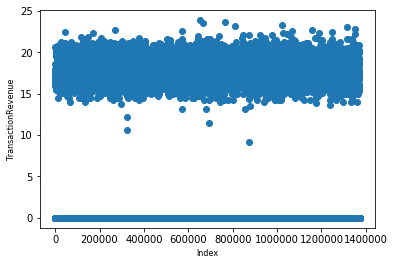

In [5]:
df_train['totals.transactionRevenue'].fillna(0,inplace=True)
df_test['totals.transactionRevenue'].fillna(0,inplace = True)
rev_id = df_train.groupby('fullVisitorId')['totals.transactionRevenue'].sum()
lrn = len(rev_id)

plt.scatter(range(rev_id.shape[0]),np.log1p(df_train['totals.transactionRevenue'][0:lrn]))
plt.xlabel('Index', fontsize=8)
plt.ylabel('TransactionRevenue', fontsize=8)
plt.show()

- From the scatter plot, it shows that that there is a disparity between customers that spend and customers that don't.

## Channel grouping Insights

- Below, we see the variance of Channel grouping with the sum and mean of total transaction value per channel.

In [81]:
#https://seaborn.pydata.org/examples/horizontal_barplot.html
#https://seaborn.pydata.org/generated/seaborn.barplot.html
#https://stackoverflow.com/questions/43562577/horizontal-barplot-in-seaborn-using-dataframe
def horizontal_bar_chart(y1, x1, y2, x2, y3, x3, data):
    f, axes = plt.subplots(1,3,figsize=(18, 6))

    sns.set(style="whitegrid")
    sns.set_color_codes("pastel")
    sns.barplot(y=y1, x=x1, data=data,
            label="Total", ax=axes[0])

    sns.set(style="whitegrid")
    sns.set_color_codes("pastel")
    sns.barplot(y=y2, x=x2, data=data,
            label="Total", ax=axes[1])

    sns.set(style="whitegrid")
    sns.set_color_codes("pastel")
    sns.barplot(y=y3, x=x3, data=data,
            label="Total", ax=axes[2])

    plt.tight_layout()

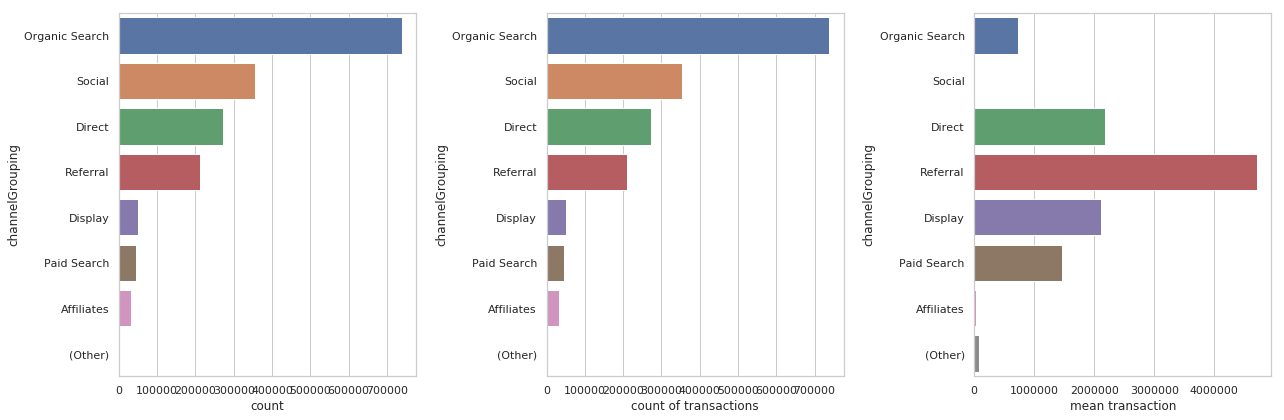

In [84]:
data = df_train.groupby("channelGrouping")["totals.transactionRevenue"].agg(['size', 'count', 'mean'])
data.columns = ["count", "count of transactions", "mean transaction"]
data.reset_index(inplace=True)
data = data.sort_values(by="count", ascending=False)

horizontal_bar_chart("channelGrouping", "count", "channelGrouping", "count of transactions", "channelGrouping", "mean transaction", data.head(10))

### Deleting Columns with less than 3 unique values as these do not contribute with significant variance

- we will dellete columns that have less that three unique values as these would not offer much variability for prediction


In [8]:
### Deleting Columns with less than 3 unique values as these do not contribute with significant variance
# we will dellete columns that have less that three unique values as these would not offer much variability for prediction

#This function just finds the columns that have less than 3 unique values and strores them in a list to be deleted
list_cols_del = []
for cols in df_train.columns.values:
    if len(df_train[cols].unique())<3:
        list_cols_del.append(cols)
        
for cols in list_cols_del:
    del(df_train[cols])

list_cols_test = []    

for cols in df_test.columns.values:
    if len(df_test[cols].unique())<3:
        list_cols_test.append(cols)
        
for cols in list_cols_test:
    del(df_test[cols])

## Visit number Analysis

#### Box plot to show number of times GStore was visited

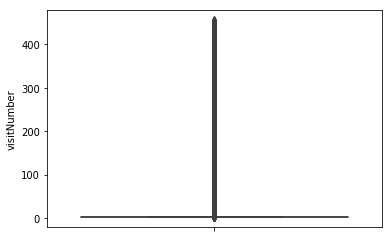

In [9]:
sns.boxplot(y="visitNumber", data =df_train)
plt.show()

- Since the number of times a person visits a website, the more likely he is to buy something

In [10]:
# Let's see the percentile values
for i in range(0,100,10):
    var = df_train["visitNumber"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

0 percentile value is 1
10 percentile value is 1
20 percentile value is 1
30 percentile value is 1
40 percentile value is 1
50 percentile value is 1
60 percentile value is 1
70 percentile value is 1
80 percentile value is 2
90 percentile value is 3
100 percentile value is  457


In [11]:
for i in range(90,100):
    var = df_train["visitNumber"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

90 percentile value is 3
91 percentile value is 3
92 percentile value is 4
93 percentile value is 4
94 percentile value is 5
95 percentile value is 6
96 percentile value is 7
97 percentile value is 8
98 percentile value is 12
99 percentile value is 22
100 percentile value is  457


In [12]:
for i in np.arange(99,100,0.1):
    var = df_train["visitNumber"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

99.0 percentile value is 22
99.1 percentile value is 24
99.19999999999999 percentile value is 27
99.29999999999998 percentile value is 30
99.39999999999998 percentile value is 35
99.49999999999997 percentile value is 42
99.59999999999997 percentile value is 53
99.69999999999996 percentile value is 69
99.79999999999995 percentile value is 98
99.89999999999995 percentile value is 145
100 percentile value is  457


- From the data, it looks like there are some shopaholics that visit the website a lot

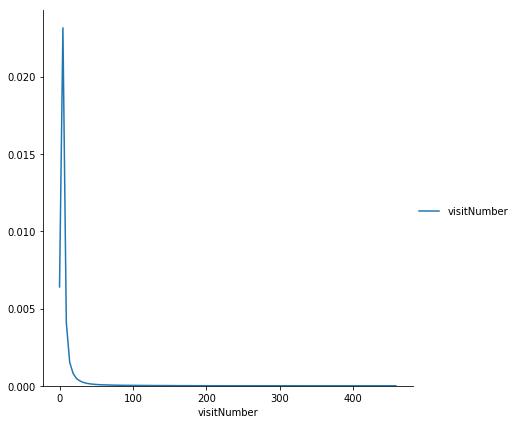

In [13]:
sns.FacetGrid(df_train,height=6).map(sns.kdeplot,"visitNumber").add_legend();
plt.show();

- the graph above looks like it can be converted to a log-normal cirve. Let's use the log curve to see if this is true

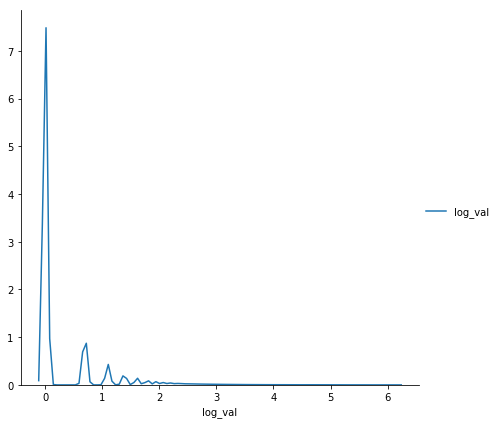

In [14]:
import math
df_train['log_val']=[math.log(i) for i in df_train['visitNumber'].values]

sns.FacetGrid(df_train,height=6).map(sns.kdeplot,"log_val").add_legend();
plt.show();

- Turns out that visit number does not follow the normal curve.

In [15]:
del(df_train['log_val'])

### Lets see in tabular form how much percent of feilds are missing 

- first, it's pretty evident form observing the dataset that a lot of values are missing.Sow e see how many values

In [16]:
percent_missing = df_train.isnull().sum() * 100 / len(df_train)
missing_value_df = pd.DataFrame({'column_name': df_train.columns,'percent_missing': percent_missing})

In [17]:
missing_value_df

,column_name,percent_missing
channelGrouping,channelGrouping,0.000000
date,date,0.000000
fullVisitorId,fullVisitorId,0.000000
visitId,visitId,0.000000
visitNumber,visitNumber,0.000000
visitStartTime,visitStartTime,0.000000
device.browser,device.browser,0.000000
device.deviceCategory,device.deviceCategory,0.000000
device.operatingSystem,device.operatingSystem,0.000000
geoNetwork.city,geoNetwork.city,0.000000


- feilds with high missing values in the dataset are candidates to be dropped, since they do not add a lot of variability and imputing values will change the behviour of the dataset. We will continue data exploration with these values for now. We will delete many columns later

## Analysis of device browser, category and Operating System wrt Transaction Revenue

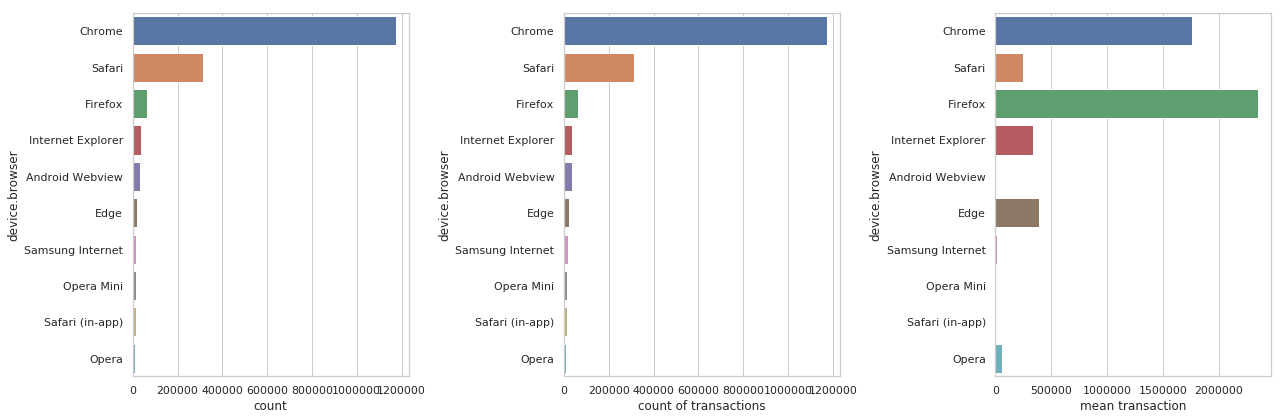

In [85]:
data = df_train.groupby("device.browser")["totals.transactionRevenue"].agg(['size', 'count', 'mean'])
data.columns = ["count", "count of transactions", "mean transaction"]
data.reset_index(inplace=True)
data = data.sort_values(by="count", ascending=False)

horizontal_bar_chart("device.browser", "count", "device.browser", "count of transactions", "device.browser", "mean transaction", data.head(10))

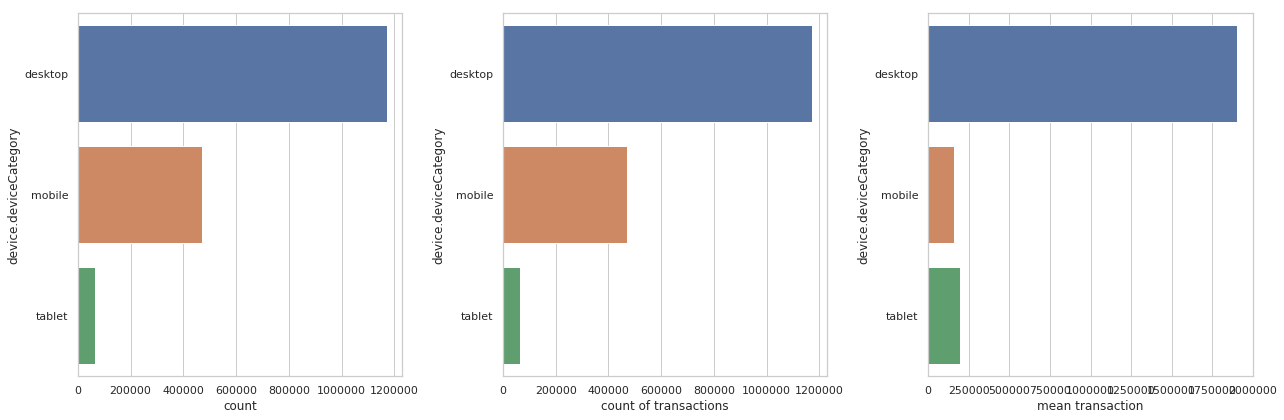

In [86]:
data = df_train.groupby("device.deviceCategory")["totals.transactionRevenue"].agg(['size', 'count', 'mean'])
data.columns = ["count", "count of transactions", "mean transaction"]
data.reset_index(inplace=True)
data = data.sort_values(by="count", ascending=False)

horizontal_bar_chart("device.deviceCategory", "count", "device.deviceCategory", "count of transactions", "device.deviceCategory", "mean transaction", data.head(10))

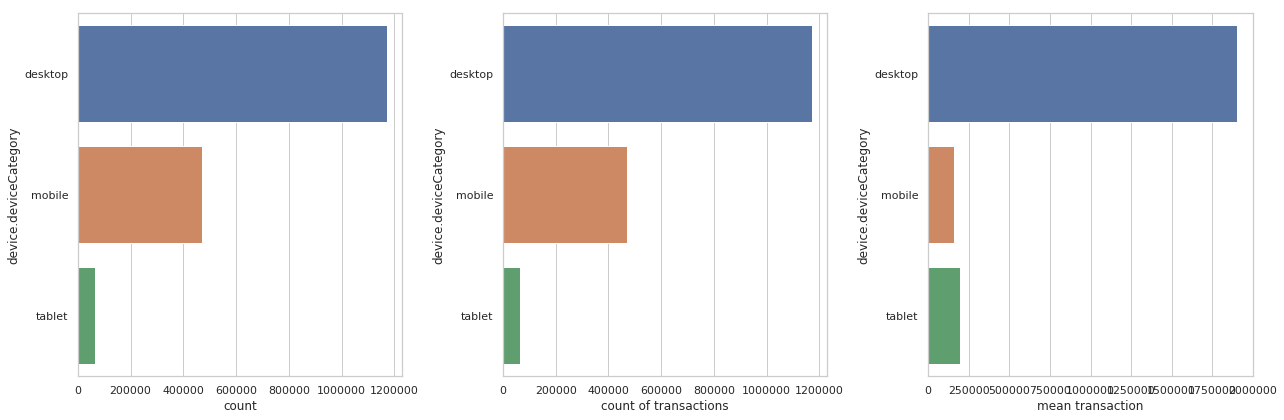

In [87]:
data = df_train.groupby("device.deviceCategory")["totals.transactionRevenue"].agg(['size', 'count', 'mean'])
data.columns = ["count", "count of transactions", "mean transaction"]
data.reset_index(inplace=True)
data = data.sort_values(by="count", ascending=False)

horizontal_bar_chart("device.deviceCategory", "count", "device.deviceCategory", "count of transactions", "device.deviceCategory", "mean transaction", data.head(10))

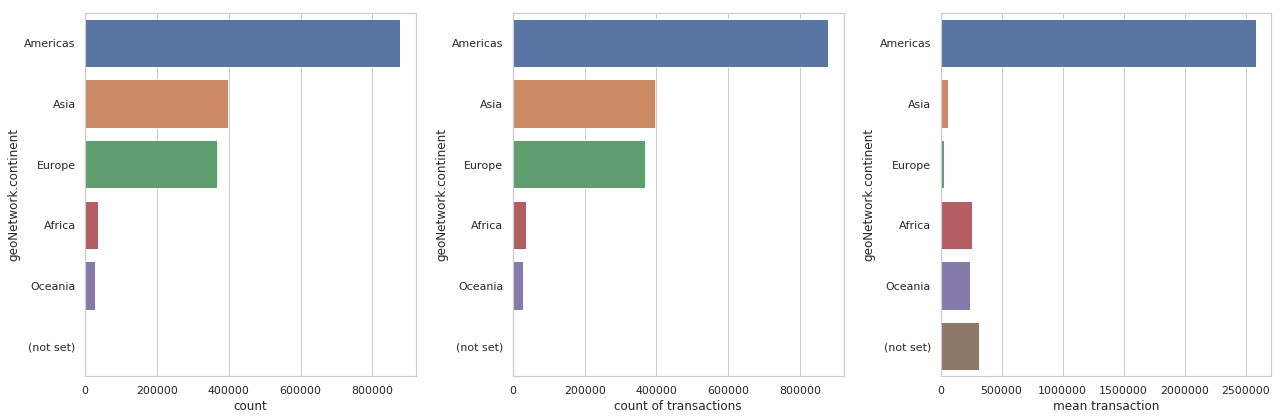

In [88]:
data = df_train.groupby("geoNetwork.continent")["totals.transactionRevenue"].agg(['size', 'count', 'mean'])
data.columns = ["count", "count of transactions", "mean transaction"]
data.reset_index(inplace=True)
data = data.sort_values(by="count", ascending=False)

horizontal_bar_chart("geoNetwork.continent", "count", "geoNetwork.continent", "count of transactions", "geoNetwork.continent", "mean transaction", data.head(10))

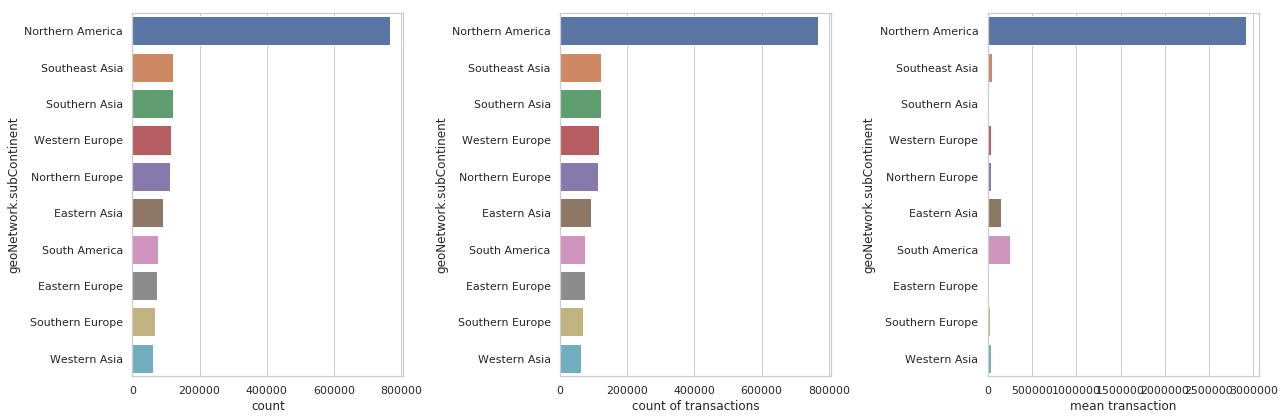

In [89]:
data = df_train.groupby("geoNetwork.subContinent")["totals.transactionRevenue"].agg(['size', 'count', 'mean'])
data.columns = ["count", "count of transactions", "mean transaction"]
data.reset_index(inplace=True)
data = data.sort_values(by="count", ascending=False)

horizontal_bar_chart("geoNetwork.subContinent", "count", "geoNetwork.subContinent", "count of transactions", "geoNetwork.subContinent", "mean transaction", data.head(10))

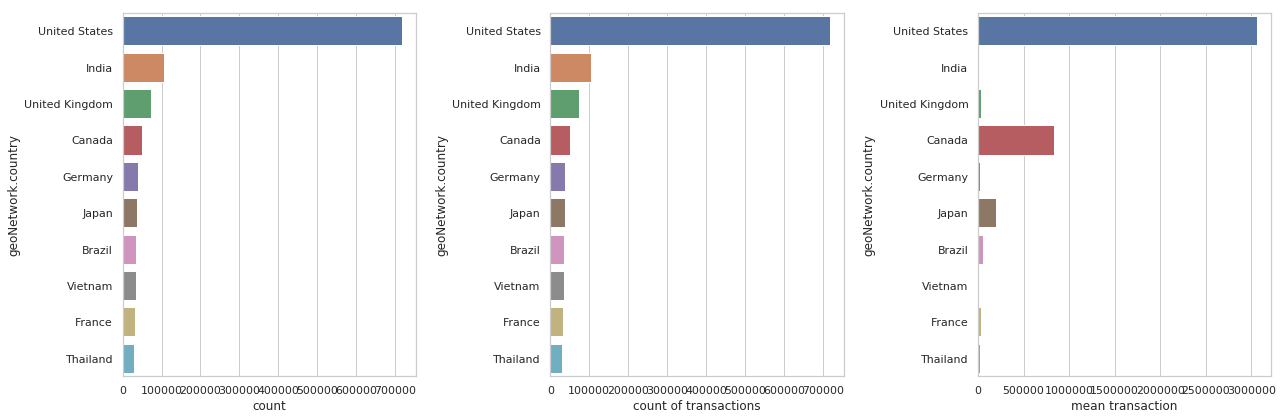

In [90]:
data = df_train.groupby("geoNetwork.country")["totals.transactionRevenue"].agg(['size', 'count', 'mean'])
data.columns = ["count", "count of transactions", "mean transaction"]
data.reset_index(inplace=True)
data = data.sort_values(by="count", ascending=False)

horizontal_bar_chart("geoNetwork.country", "count", "geoNetwork.country", "count of transactions", "geoNetwork.country", "mean transaction", data.head(10))


### Revenue by date

In [21]:
df_train['date'] = df_train['date'].astype(str)
df_train["date"] = df_train["date"].apply(lambda x : x[:4] + "-" + x[4:6] + "-" + x[6:])
df_train["date"] = pd.to_datetime(df_train["date"])

df_test['date'] = df_test['date'].astype(str)
df_test["date"] = df_test["date"].apply(lambda x : x[:4] + "-" + x[4:6] + "-" + x[6:])
df_test["date"] = pd.to_datetime(df_test["date"])

In [22]:
# the date is given in a continuous form. eg: 20180501
# we use the code above to seperate the date into normal form eg: 2018-05-01

/usr/local/lib/python3.5/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()



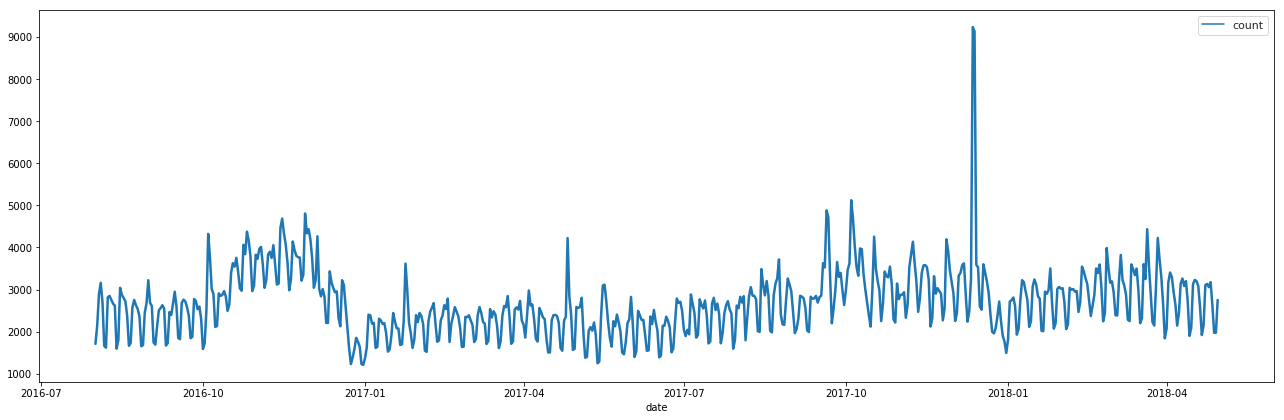

In [23]:
import seaborn as sns
tran_rev = df_train.groupby("date")['totals.transactionRevenue'].agg(['count'])
f, axes = plt.subplots(figsize=(18, 6))
sns.set(style="white")
sns.lineplot( data=tran_rev, palette="tab10", linewidth=2.5)
plt.tight_layout()

- Then trend of total revenue by date can be seen from the plot above. We see a sharp spike in december, maybe due to christmas and new year spending.


### Visual for Visits by country

In [24]:
#https://www.kaggle.com/arthurtok/generation-unemployed-interactive-plotly-visuals
temp = df_train['geoNetwork.country'].value_counts()
metricscale = [[0, 'rgb(102,194,165)'], [0.05, 'rgb(102,194,165)'], 
              [0.15, 'rgb(171,221,164)'], [0.2, 'rgb(230,245,152)'], 
              [0.25, 'rgb(255,255,191)'], [0.35, 'rgb(254,224,139)'], 
              [0.45, 'rgb(253,174,97)'], [0.55, 'rgb(213,62,79)'], [1.0, 'rgb(158,1,66)']]

data = [ dict(type = 'choropleth',autocolorscale = False,colorscale = metricscale,showscale = True,locations = temp.index,
        z = temp.values,locationmode = 'country names',text = temp.index,
        marker = dict(line = dict(color = 'rgb(250,250,225)', width = 0.5)),colorbar = dict(bgcolor= 'rgb(128,158,188)', tickprefix = '', 
            title = 'Rate'))]

layout = dict(
    height=500,
    title = 'Visits by Country',
    geo = dict(
        showframe = True,
        showocean = True,
        oceancolor = '#222',
        projection = dict(
        type = 'orthographic',
            rotation = dict(
                    lon = 60,
                    lat = 10),
        ),
        lonaxis =  dict(
                showgrid = False,
                gridcolor = 'rgb(102, 102, 102)'
            ),
        lataxis = dict(
                showgrid = False,
                gridcolor = 'rgb(102, 102, 102)'
                )
            ),
        )
fig = dict(data=data, layout=layout)
iplot(fig)

# Cleaning and Feature Engineering

### Deleting Columns with less than 3 unique values as these do not contribute with significant variance
 

- we will dellete columns that have less that three unique values as these would not offer much variability for prediction


In [25]:
#This function just finds the columns that have less than 3 unique values and strores them in a list to be deleted
list_cols_del = []
for cols in df_train.columns.values:
    if len(df_train[cols].unique())<3:
        list_cols_del.append(cols)
        
for cols in list_cols_del:
    del(df_train[cols])

list_cols_test = []    

for cols in df_test.columns.values:
    if len(df_test[cols].unique())<3:
        list_cols_test.append(cols)
        
for cols in list_cols_test:
    del(df_test[cols])

### Adding some more features based on date and user vitsit, hit, time page view and sum count

In [26]:
df_train
df_test

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.operatingSystem,geoNetwork.city,...,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,2018-05-11,7460955084541987166,1526099341,2,1526099341,Chrome,mobile,Android,(not set),...,(not set),NaN,NaN,NaN,NaN,(not set),(not provided),organic,(not set),google
1,Direct,2018-05-11,460252456180441002,1526064483,166,1526064483,Chrome,desktop,Macintosh,San Francisco,...,(not set),NaN,NaN,NaN,NaN,(not set),(not set),(none),(not set),(direct)
2,Organic Search,2018-05-11,3461808543879602873,1526067157,2,1526067157,Chrome,desktop,Chrome OS,not available in demo dataset,...,(not set),NaN,NaN,NaN,NaN,(not set),(not provided),organic,(not set),google
3,Direct,2018-05-11,975129477712150630,1526107551,4,1526107551,Chrome,mobile,iOS,Houston,...,(not set),NaN,NaN,NaN,NaN,(not set),(not set),(none),(not set),(direct)
4,Organic Search,2018-05-11,8381672768065729990,1526060254,1,1526060254,Internet Explorer,tablet,Windows,Irvine,...,(not set),NaN,NaN,NaN,NaN,(not set),(not provided),organic,(not set),google
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401584,Organic Search,2018-09-07,6701149525099562370,1536353803,1,1536353803,Chrome,mobile,Android,not available in demo dataset,...,(not set),NaN,NaN,NaN,NaN,(not set),(not provided),organic,(not set),google
401585,Organic Search,2018-09-07,6154541330147351453,1536388075,1,1536388075,Chrome,desktop,Windows,not available in demo dataset,...,(not set),NaN,NaN,NaN,NaN,(not set),(not provided),organic,(not set),google
401586,Organic Search,2018-09-07,6013469762773705448,1536351791,3,1536351791,Firefox,desktop,Windows,not available in demo dataset,...,(not set),NaN,NaN,NaN,NaN,(not set),(not provided),organic,(not set),google
401587,Organic Search,2018-09-07,4565378823441900999,1536340217,1,1536340217,Chrome,desktop,Chrome OS,not available in demo dataset,...,(not set),NaN,NaN,NaN,NaN,(not set),(not provided),organic,(not set),google


In [27]:
#adding some more features
# We will add the following feature to the dataset 
df_train["date"] = pd.to_datetime(df_train["date"])   
# numeric features to tell the month, day and weekday from the date for every entry of the customer
df_train["month"]   = df_train['date'].dt.month
df_train["day"]     = df_train['date'].dt.day
df_train["weekday"] = df_train['date'].dt.weekday
#number of unique users per day weekday and month for a given date
df_train['month_unique_user_count'] = df_train.groupby('month')['fullVisitorId'].transform('nunique')
df_train['day_unique_user_count'] = df_train.groupby('day')['fullVisitorId'].transform('nunique')
df_train['weekday_unique_user_count'] = df_train.groupby('weekday')['fullVisitorId'].transform('nunique')
# total number of visits, and mean of visits per visitorID
df_train['visits_sum'] = df_train.groupby('fullVisitorId')['visitNumber'].transform('sum')
#df['visits_min'] = df.groupby('fullVisitorId')['visitNumber'].transform('min')
df_train['visits_mean'] = df_train.groupby('fullVisitorId')['visitNumber'].transform('mean')
# total number of hits and total count of hits per visit ID
df_train['hits_sum'] = df_train.groupby('fullVisitorId')['totals.hits'].transform('sum')
df_train['hits_cnt']  =df_train.groupby('fullVisitorId')['totals.hits'].transform('count')
#filling nan values with a 0.0
df_train['totals.pageviews'] = df_train['totals.pageviews'].fillna(0.0)
# sum and count of page views per visit ID
df_train['pgview_sum'] = df_train.groupby('fullVisitorId')['totals.pageviews'].transform('sum')
df_train['pgview_cnt'] = df_train.groupby('fullVisitorId')['totals.pageviews'].transform('count')
# sum and count if total time spent on site per visit ID
df_train['totals.timeOnSite'] = df_train['totals.timeOnSite'].fillna(0.0)
df_train['time_sum'] = df_train.groupby('fullVisitorId')['totals.timeOnSite'].transform('sum')
df_train['time_cnt'] = df_train.groupby('fullVisitorId')['totals.timeOnSite'].transform('count')

# for test dataset

df_test["date"] = pd.to_datetime(df_test["date"])   
# numeric features to tell the month, day and weekday from the date for every entry of the customer
df_test["month"]   = df_test['date'].dt.month
df_test["day"]     = df_test['date'].dt.day
df_test["weekday"] = df_test['date'].dt.weekday
#number of unique users per day weekday and month for a given date
df_test['month_unique_user_count'] = df_test.groupby('month')['fullVisitorId'].transform('nunique')
df_test['day_unique_user_count'] = df_test.groupby('day')['fullVisitorId'].transform('nunique')
df_test['weekday_unique_user_count'] = df_test.groupby('weekday')['fullVisitorId'].transform('nunique')
# total number of visits, and mean of visits per visitorID
df_test['visits_sum'] = df_test.groupby('fullVisitorId')['visitNumber'].transform('sum')
#df['visits_min'] = df.groupby('fullVisitorId')['visitNumber'].transform('min')
df_test['visits_mean'] = df_test.groupby('fullVisitorId')['visitNumber'].transform('mean')
# total number of hits and total count of hits per visit ID
df_test['hits_sum'] = df_test.groupby('fullVisitorId')['totals.hits'].transform('sum')
df_test['hits_cnt']  =df_test.groupby('fullVisitorId')['totals.hits'].transform('count')
#filling nan values with a 0.0
df_test['totals.pageviews'] = df_test['totals.pageviews'].fillna(0.0)
# sum and count of page views per visit ID
df_test['pgview_sum'] = df_test.groupby('fullVisitorId')['totals.pageviews'].transform('sum')
df_test['pgview_cnt'] = df_test.groupby('fullVisitorId')['totals.pageviews'].transform('count')
# sum and count if total time spent on site per visit ID
df_test['totals.timeOnSite'] = df_test['totals.timeOnSite'].fillna(0.0)
df_test['time_sum'] = df_test.groupby('fullVisitorId')['totals.timeOnSite'].transform('sum')
df_test['time_cnt'] = df_test.groupby('fullVisitorId')['totals.timeOnSite'].transform('count')



- We will add an extra column of 0's and 1's. If a transaction for a user took place on a particular date, we will add a 1 for that particular date. Otherwise, we will add a 0. This will be used for classification purposes later on.

In [28]:
#one for column for classification purposes:
df_train['valid_rev'] = df_train['totals.transactionRevenue'].apply(lambda x: 1 if x >0.0 else 0)
df_test['valid_rev'] = df_test['totals.transactionRevenue'].apply(lambda x:1 if x>0.0 else 0)

- We will sort the dataframe by date below and we will seperate the classification target and regression target

In [29]:
df_train = df_train.sort_values(by='date')
#sort values by date to proceed further
target_train = pd.DataFrame(df_train['totals.transactionRevenue'])
#this is the regression target
target_2train = pd.DataFrame(df_train['valid_rev'])
#taking customer id for prediction later
cust_id_train = df_train['fullVisitorId'].values

df_test = df_test.sort_values(by='date')
#sort values by date to proceed further
target_test = pd.DataFrame(df_test['totals.transactionRevenue'])
#this is the classification target
target_2test = pd.DataFrame(df_test['valid_rev'])
#taking customer id for prediction later
cust_id_test = df_test['fullVisitorId'].values


- We will drop a few columns that have a lot of misising vlaues or are of no use to the machine learning models.

In [30]:
#Unanmed_0
#following Columns have a lot of misisng values, hence it is better to remove them some of the values in the columns are also repeated.
drop_cols = ['visitId', 'visitStartTime','date','fullVisitorId','geoNetwork.city','geoNetwork.metro','trafficSource.campaign','trafficSource.keyword','trafficSource.medium','trafficSource.referralPath']
df_train = df_train.drop(drop_cols,axis=1)
df_test = df_test.drop(drop_cols,axis=1)

In [31]:
target_train = pd.DataFrame(df_train['totals.transactionRevenue'])
target_2_train = pd.DataFrame(df_train['valid_rev'])

target_test = pd.DataFrame(df_test['totals.transactionRevenue'])
target_2_test = pd.DataFrame(df_test['valid_rev'])

In [32]:
target_train.head(4)

,totals.transactionRevenue
996451,0.0
996443,0.0
996444,0.0
996445,167400000.0


In [33]:
target_2train.head(4)

,valid_rev
996451,0
996443,0
996444,0
996445,1


- All the nan vlaues in the numerical columns, we will change them to 0.

In [34]:
num_cols = df_train._get_numeric_data().columns
for i in num_cols:
    df_train[i].fillna(0,inplace=True)
    
num_cols = df_test._get_numeric_data().columns
for i in num_cols:
    df_test[i].fillna(0,inplace=True)

## We will shart one hot encoding the following:

#### One Hot Encoding of Channel grouping

In [35]:
my_counter = Counter()
for d in df_train['channelGrouping'].values:
    my_counter.update(d.split())
    
channel_dict = dict(my_counter)
channel_dict = dict(sorted(channel_dict.items(),key = lambda kv:kv[1]))
vectorizer  = CountVectorizer(vocabulary = list(channel_dict.keys()), lowercase = False, binary = True)
channelGrouping_ohe = vectorizer.fit_transform(df_train['channelGrouping'].values.astype('U'))

channelGrouping_ohe_test = vectorizer.transform(df_test['channelGrouping'].values.astype('U'))

#### One Hot Encoding of Browser

In [36]:
df_test.iloc[0,2]

'Chrome'

In [37]:
# remove all other browser tyoes except 10 most used as browser contains lots of different values
# Replace values other than that in 'browse' with 'other'
browse = ['Chrome','Safari','Firefox','Internet Explorer','Android Webview','Edge','Samsung Internet','Opera Mini','Safari (in-app)','Opera','UC Browser','YaBrowser','Amazon Silk','Coc','Android Browser']
c=0
for val in df_train['device.browser']:
    if val in browse:
        c+=1
        pass
    else:
        df_train.iloc[c,2] = 'other'
        c+=1
c=0    
for val in df_test['device.browser']:
    if val in browse:
        c+=1
        pass
    else:
        df_test.iloc[c,2] = 'other'
        c+=1

In [38]:
df_train['device.browser'].unique()
df_test['device.browser'].unique()

array(['Chrome', 'Safari', 'Edge', 'Firefox', 'Safari (in-app)',
       'Samsung Internet', 'Internet Explorer', 'Opera', 'Opera Mini',
       'Android Webview', 'UC Browser', 'other', 'YaBrowser',
       'Amazon Silk', 'Android Browser'], dtype=object)

In [39]:
my_counter = Counter()
for d in df_train['device.browser'].values:
    my_counter.update(d.split())
    
brow = dict(my_counter)
brow_dict = dict(sorted(brow.items(),key = lambda kv:kv[1]))

vectorizer  = CountVectorizer(vocabulary = list(brow_dict.keys()), lowercase = False, binary = True)
brow_ohe = vectorizer.fit_transform(df_train['device.browser'].values.astype('U'))

brow_ohe_test = vectorizer.transform(df_test['device.browser'].values.astype('U'))

#### One Hot Encoding on Device category

In [40]:
my_counter = Counter()
for d in df_train['device.deviceCategory'].values:
    my_counter.update(d.split())
    
dev_cat = dict(my_counter)
dev_cat_dict = dict(sorted(dev_cat.items(),key = lambda kv:kv[1]))

vectorizer  = CountVectorizer(vocabulary = list(dev_cat_dict.keys()), lowercase = False, binary = True)
dev_cat_ohe = vectorizer.fit_transform(df_train['device.deviceCategory'].values.astype('U'))

dev_cat_ohe_test = vectorizer.transform(df_test['device.deviceCategory'].values.astype('U'))
print(vectorizer.get_feature_names())

['mobile', 'desktop', 'tablet']


#### One Hot Encoding on Operating System

In [41]:
# change the value '(not set)' to 'other' in vocabulary of Count Vectoizer
df_train['device.operatingSystem'] = df_train['device.operatingSystem'].apply(lambda x: 'other' if x =='(not set)' else x)
df_test['device.operatingSystem'] = df_test['device.operatingSystem'].apply(lambda x: 'other' if x =='(not set)' else x)

In [42]:
my_counter = Counter()
for d in df_train['device.operatingSystem'].values:
    my_counter.update(d.split())
    
dev_cat = dict(my_counter)
dev_cat_dict = dict(sorted(dev_cat.items(),key = lambda kv:kv[1]))

vectorizer  = CountVectorizer(vocabulary = list(dev_cat_dict.keys()), lowercase = False, binary = True)
os_ohe = vectorizer.fit_transform(df_train['device.operatingSystem'].values.astype('U'))

os_ohe_test = vectorizer.transform(df_test['device.operatingSystem'].values.astype('U'))


#### One hot Encoding on geoNetwork Continent

In [43]:
df_train['geoNetwork.subContinent'] = df_train['geoNetwork.subContinent'].apply(lambda x: 'other' if x =='(not set)' else x)
df_test['geoNetwork.subContinent'] = df_test['geoNetwork.subContinent'].apply(lambda x: 'other' if x =='(not set)' else x)

In [44]:
my_counter = Counter()
for d in df_train['geoNetwork.subContinent'].values:
    my_counter.update(d.split())
    
dev_cat = dict(my_counter)
dev_cat_dict = dict(sorted(dev_cat.items(),key = lambda kv:kv[1]))

vectorizer  = CountVectorizer(vocabulary = list(dev_cat_dict.keys()), lowercase = False, binary = True)
subcontinent_ohe = vectorizer.fit_transform(df_train['geoNetwork.subContinent'].values.astype('U'))

subcontinent_ohe_test = vectorizer.transform(df_test['geoNetwork.subContinent'].values.astype('U'))




#### One hot Encoding on Country

In [45]:
my_counter = Counter()
for d in df_train['geoNetwork.country'].values:
    my_counter.update(d.split())
    
dev_cat = dict(my_counter)
dev_cat_dict = dict(sorted(dev_cat.items(),key = lambda kv:kv[1]))

vectorizer  = CountVectorizer(vocabulary = list(dev_cat_dict.keys()), lowercase = False, binary = True)
country_ohe = vectorizer.fit_transform(df_train['geoNetwork.country'].values.astype('U'))

country_ohe_test = vectorizer.transform(df_test['geoNetwork.country'].values.astype('U'))

### We will now normalize all of our numerical features except day, weekday and month

In [46]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
visit_nor_train = normalizer.fit_transform(df_train['visitNumber'].values.reshape(1,-1))
visit_nor_train = visit_nor_train.reshape(-1,1)
visit_nor_test = normalizer.transform(df_test['visitNumber'].values.reshape(1,-1))
visit_nor_test = visit_nor_test.reshape(-1,1)

normalizer = Normalizer()
hits_nor_train = normalizer.fit_transform(df_train['totals.hits'].values.reshape(1,-1))
hits_nor_train = hits_nor_train.reshape(-1,1)
hits_nor_test = normalizer.transform(df_test['totals.hits'].values.reshape(1,-1))
hits_nor_test = hits_nor_test.reshape(-1,1)

normalizer = Normalizer()
view_nor_train = normalizer.fit_transform(df_train['totals.pageviews'].values.reshape(1,-1))
view_nor_train = view_nor_train.reshape(-1,1)
view_nor_test = normalizer.transform(df_test['totals.pageviews'].values.reshape(1,-1))
view_nor_test = view_nor_test.reshape(-1,1)

normalizer = Normalizer()
site_nor_train = normalizer.fit_transform(df_train['totals.timeOnSite'].values.reshape(1,-1))
site_nor_train = site_nor_train.reshape(-1,1)
site_nor_test = normalizer.transform(df_test['totals.timeOnSite'].values.reshape(1,-1))
site_nor_test = site_nor_test.reshape(-1,1)

normalizer = Normalizer()
v_sum_train = normalizer.fit_transform(df_train['visits_sum'].values.reshape(1,-1))
v_sum_train = v_sum_train.reshape(-1,1)
v_sum_test = normalizer.transform(df_test['visits_sum'].values.reshape(1,-1))
v_sum_test = v_sum_test.reshape(-1,1)

normalizer = Normalizer()
v_mean_train = normalizer.fit_transform(df_train['visits_mean'].values.reshape(1,-1))
v_mean_train = v_mean_train.reshape(-1,1)
v_mean_test = normalizer.transform(df_test['visits_mean'].values.reshape(1,-1))
v_mean_test = v_mean_test.reshape(-1,1)

normalizer = Normalizer()
h_sum_train = normalizer.fit_transform(df_train['hits_sum'].values.reshape(1,-1))
h_sum_train = h_sum_train.reshape(-1,1)
h_sum_test = normalizer.transform(df_test['hits_sum'].values.reshape(1,-1))
h_sum_test = h_sum_test.reshape(-1,1)

normalizer = Normalizer()
h_cnt_train = normalizer.fit_transform(df_train['hits_cnt'].values.reshape(1,-1))
h_cnt_train = h_cnt_train.reshape(-1,1)
h_cnt_test = normalizer.transform(df_test['hits_cnt'].values.reshape(1,-1))
h_cnt_test = h_cnt_test.reshape(-1,1)

normalizer = Normalizer()
p_sum_train = normalizer.fit_transform(df_train['pgview_sum'].values.reshape(1,-1))
p_sum_train = p_sum_train.reshape(-1,1)
p_sum_test = normalizer.transform(df_test['pgview_sum'].values.reshape(1,-1))
p_sum_test = p_sum_test.reshape(-1,1)

normalizer = Normalizer()
p_cnt_train = normalizer.fit_transform(df_train['pgview_cnt'].values.reshape(1,-1))
p_cnt_train = p_cnt_train.reshape(-1,1)
p_cnt_test = normalizer.transform(df_test['pgview_cnt'].values.reshape(1,-1))
p_cnt_test = p_cnt_test.reshape(-1,1)

normalizer = Normalizer()
t_sum_train = normalizer.fit_transform(df_train['time_sum'].values.reshape(1,-1))
t_sum_train = t_sum_train.reshape(-1,1)
t_sum_test = normalizer.transform(df_test['time_sum'].values.reshape(1,-1))
t_sum_test = t_sum_test.reshape(-1,1)

normalizer = Normalizer()
t_cnt_train = normalizer.fit_transform(df_train['time_cnt'].values.reshape(1,-1))
t_cnt_train = t_cnt_train.reshape(-1,1)
t_cnt_test = normalizer.transform(df_test['time_cnt'].values.reshape(1,-1))
t_cnt_test = t_cnt_test.reshape(-1,1)

normalizer = Normalizer()
weekday_unique_user_count_train = normalizer.fit_transform(df_train['weekday_unique_user_count'].values.reshape(1,-1))
weekday_unique_user_count_train = weekday_unique_user_count_train.reshape(-1,1)
weekday_unique_user_count_test = normalizer.transform(df_test['weekday_unique_user_count'].values.reshape(1,-1))
weekday_unique_user_count_test = weekday_unique_user_count_test.reshape(-1,1)

normalizer = Normalizer()
day_unique_user_count_train = normalizer.fit_transform(df_train['day_unique_user_count'].values.reshape(1,-1))
day_unique_user_count_train = day_unique_user_count_train.reshape(-1,1)
day_unique_user_count_test = normalizer.transform(df_test['day_unique_user_count'].values.reshape(1,-1))
day_unique_user_count_test = day_unique_user_count_test.reshape(-1,1)

normalizer = Normalizer()
month_unique_user_count_train = normalizer.fit_transform(df_train['month_unique_user_count'].values.reshape(1,-1))
month_unique_user_count_train = month_unique_user_count_train.reshape(-1,1)
month_unique_user_count_test = normalizer.transform(df_test['month_unique_user_count'].values.reshape(1,-1))
month_unique_user_count_test = month_unique_user_count_test.reshape(-1,1)

month_train = df_train["month"].values.reshape((1708337,1))
day_train = df_train["day"].values.reshape((1708337,1))
weekday_train = df_train['weekday'].values.reshape((1708337,1))
month_test = df_test["month"].values.reshape((df_test.shape[0],1))
day_test = df_test["day"].values.reshape((df_test.shape[0],1))
weekday_test = df_test['weekday'].values.reshape((df_test.shape[0],1))

In [51]:
'''from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
visit_nor_test = normalizer.fit_transform(df_test['visitNumber'].values.reshape(1,-1))
visit_nor_test = visit_nor_test.reshape(-1,1)

normalizer = Normalizer()
hits_nor_test = normalizer.fit_transform(df_test['totals.hits'].values.reshape(1,-1))
hits_nor_test = hits_nor_test.reshape(-1,1)

normalizer = Normalizer()
view_nor_test = normalizer.fit_transform(df_test['totals.pageviews'].values.reshape(1,-1))
view_nor_test = view_nor_test.reshape(-1,1)

normalizer = Normalizer()
site_nor_test = normalizer.fit_transform(df_test['totals.timeOnSite'].values.reshape(1,-1))
site_nor_test = site_nor_test.reshape(-1,1)

normalizer = Normalizer()
v_sum_test = normalizer.fit_transform(df_test['visits_sum'].values.reshape(1,-1))
v_sum_test = v_sum_test.reshape(-1,1)

normalizer = Normalizer()
v_mean_test = normalizer.fit_transform(df_test['visits_mean'].values.reshape(1,-1))
v_mean_test = v_mean_test.reshape(-1,1)

normalizer = Normalizer()
h_sum_test = normalizer.fit_transform(df_test['hits_sum'].values.reshape(1,-1))
h_sum_test = h_sum_test.reshape(-1,1)

normalizer = Normalizer()
h_cnt_test = normalizer.fit_transform(df_test['hits_cnt'].values.reshape(1,-1))
h_cnt_test = h_cnt_test.reshape(-1,1)

normalizer = Normalizer()
p_sum_test = normalizer.fit_transform(df_test['pgview_sum'].values.reshape(1,-1))
p_sum_test = p_sum_test.reshape(-1,1)

normalizer = Normalizer()
p_cnt_test = normalizer.fit_transform(df_test['pgview_cnt'].values.reshape(1,-1))
p_cnt_test = p_cnt_test.reshape(-1,1)

normalizer = Normalizer()
t_sum_test = normalizer.fit_transform(df_test['time_sum'].values.reshape(1,-1))
t_sum_test = t_sum_test.reshape(-1,1)

normalizer = Normalizer()
t_cnt_test = normalizer.fit_transform(df_test['time_cnt'].values.reshape(1,-1))
t_cnt_test = t_cnt_test.reshape(-1,1)

normalizer = Normalizer()
weekday_unique_user_count_test = normalizer.fit_transform(df_test['weekday_unique_user_count'].values.reshape(1,-1))
weekday_unique_user_count_test = weekday_unique_user_count_test.reshape(-1,1)

normalizer = Normalizer()
day_unique_user_count_test = normalizer.fit_transform(df_test['day_unique_user_count'].values.reshape(1,-1))
day_unique_user_count_test = day_unique_user_count_test.reshape(-1,1)

normalizer = Normalizer()
month_unique_user_count_test = normalizer.fit_transform(df_test['month_unique_user_count'].values.reshape(1,-1))
month_unique_user_count_test = month_unique_user_count_test.reshape(-1,1)

month_test = df_test["month"].values.reshape((df_test.shape[0],1))
day_test = df_test["day"].values.reshape((df_test.shape[0],1))
weekday_test = df_test['weekday'].values.reshape((df_test.shape[0],1))'''

In [47]:
features_train = hstack((channelGrouping_ohe,brow_ohe,dev_cat_ohe,os_ohe,subcontinent_ohe,country_ohe,visit_nor_train,hits_nor_train,view_nor_train,site_nor_train,v_sum_train,v_mean_train,h_sum_train,h_cnt_train,p_sum_train,p_cnt_train,t_sum_train,t_cnt_train,month_train,day_train,weekday_train,month_unique_user_count_train,day_unique_user_count_train,weekday_unique_user_count_train))
features_test = hstack((channelGrouping_ohe_test,brow_ohe_test,dev_cat_ohe_test,os_ohe_test,subcontinent_ohe_test,country_ohe_test,visit_nor_test,hits_nor_test,view_nor_test,site_nor_test,v_sum_test,v_mean_test,h_sum_test,h_cnt_test,p_sum_test,p_cnt_test,t_sum_test,t_cnt_test,month_test,day_test,weekday_test,month_unique_user_count_test,day_unique_user_count_test,weekday_unique_user_count_test))

- Our target variable for the regression problem is supposed to be log(totals.transctionRevenue+1). Hence we use the inbuilt function <b>log1p</b>

In [48]:
target_train = np.log1p(target_train)

In [49]:
target_test = np.log1p(target_test)

In [50]:
target_train

,totals.transactionRevenue
996451,0.000000
996443,0.000000
996444,0.000000
996445,18.935897
996446,0.000000
...,...
1031569,0.000000
1031568,0.000000
1031567,0.000000
1031575,0.000000


In [51]:
target_test

,totals.transactionRevenue
343283,0.0
342758,0.0
342759,0.0
342760,0.0
342761,0.0
...,...
12683,0.0
12684,0.0
12685,0.0
12687,0.0


## Machine Learning Models

#### Train Test Split

- We already have the train and the test sets sperately. Hence, we do not need a split

## Light GBM

#### Hyperparameter Tuning

In [54]:
#https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html
#https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc
param_grid = {
    'num_leaves': [10,30,50,70,90],
    'min_data_in_leaf': [1, 5, 10,20,30],
    'max_depth': [5,10,20, 30, 50],
    }

est = lgb.LGBMRegressor()
grid = GridSearchCV(est, param_grid,verbose=0,cv=4,n_jobs=-1)
grid.fit(features_train,target_train)
print(grid.best_params_)
print(grid.best_score_)


/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



{'max_depth': 10, 'num_leaves': 50, 'min_data_in_leaf': 20}
0.3039024324267134


#### Lightgbm model based on best features

In [55]:
params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 50,
        "min_data_in_leaf":20,
        "max_depth":10
        
    }
    
    # convert our training data into LightGBM dataset format:
lgtrain = lgb.Dataset(features_train, label=target_train)
#lgval = lgb.Dataset(val_X, label=val_y)
model = lgb.train(params, lgtrain)
pred_test_y = model.predict(features_test)
pred_test_y

/home/mayankkhanna3340/.local/lib/python3.5/site-packages/lightgbm/basic.py:546: UserWarning:

Converting data to scipy sparse matrix.



array([5.67903513e-04, 1.06291367e-03, 6.74053179e-04, ...,
       3.56629331e+00, 1.34870446e+01, 1.06291367e-03])

In [56]:
rmse = np.sqrt(mean_squared_error(pred_test_y, target_test))
rmse

2.0427835090955457

## XGBoost

#### Hyperparameter tuning XG boost

In [57]:
regr2 = xgb.XGBRegressor(n_jobs=-1)
param_grid = {'max_depth':[2,3,4,5,6],'min_child_weight':[1,2,3,4,5,6],'subsample':[.4,.6,.8],'n_estimators':[50,100,300,500,1000]}
gs_xgb = RandomizedSearchCV(regr2,param_grid,scoring = 'neg_mean_squared_error')
gs_xgb.fit(features_train, target_train)

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



[04:16:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:26:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:35:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:45:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:46:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:46:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:47:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:54:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=-1, nthread=None,
                                          objective='reg:linear',
                                          ran...
                                          reg_lambda=1, scale_pos_weight=1,
                                          seed=None, silent=None, subsample=1,
                                  

In [58]:
gs_xgb.best_params_

{'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 50, 'subsample': 0.8}

In [ ]:
x_model = xgb.XGBRegressor(
 learning_rate =0.1,
 n_estimators=50,
 max_depth=6,
 min_child_weight=3,
 gamma=0,
 subsample=0.8,
 reg_alpha=200, reg_lambda=200,
 colsample_bytree=0.8,nthread=-1)
x_model.fit(features_train, target_train)

In [60]:
y_pred = x_model.predict(features_test)

In [61]:
rmse = np.sqrt(mean_squared_error(y_pred, target_test))
rmse

1.9895853951403044

## Cat Boost

In [63]:
from catboost import CatBoostRegressor

In [65]:
regr2 =CatBoostRegressor()
param_grid = {'depth':[2,3,4,5,6,8,10],'learning_rate':[0.04,0.06,0.02]}
gs_xgb = RandomizedSearchCV(regr2,param_grid,scoring = 'neg_mean_squared_error')
gs_xgb.fit(features_train, target_train)

0:	learn: 1.7963162	total: 170ms	remaining: 2m 50s
1:	learn: 1.7874820	total: 247ms	remaining: 2m 3s
2:	learn: 1.7791481	total: 319ms	remaining: 1m 46s
3:	learn: 1.7709055	total: 394ms	remaining: 1m 38s
4:	learn: 1.7631700	total: 465ms	remaining: 1m 32s
5:	learn: 1.7554736	total: 540ms	remaining: 1m 29s
6:	learn: 1.7481286	total: 616ms	remaining: 1m 27s
7:	learn: 1.7410378	total: 690ms	remaining: 1m 25s
8:	learn: 1.7340581	total: 763ms	remaining: 1m 24s
9:	learn: 1.7274039	total: 838ms	remaining: 1m 22s
10:	learn: 1.7210046	total: 913ms	remaining: 1m 22s
11:	learn: 1.7147926	total: 983ms	remaining: 1m 20s
12:	learn: 1.7086531	total: 1.06s	remaining: 1m 20s
13:	learn: 1.7027527	total: 1.13s	remaining: 1m 19s
14:	learn: 1.6971123	total: 1.2s	remaining: 1m 19s
15:	learn: 1.6916245	total: 1.27s	remaining: 1m 18s
16:	learn: 1.6862171	total: 1.35s	remaining: 1m 18s
17:	learn: 1.6809634	total: 1.43s	remaining: 1m 17s
18:	learn: 1.6760530	total: 1.5s	remaining: 1m 17s
19:	learn: 1.6710832	tota

159:	learn: 1.5151667	total: 11.8s	remaining: 1m 1s
160:	learn: 1.5149494	total: 11.8s	remaining: 1m 1s
161:	learn: 1.5147883	total: 11.9s	remaining: 1m 1s
162:	learn: 1.5146335	total: 12s	remaining: 1m 1s
163:	learn: 1.5144968	total: 12s	remaining: 1m 1s
164:	learn: 1.5143446	total: 12.1s	remaining: 1m 1s
165:	learn: 1.5141167	total: 12.2s	remaining: 1m 1s
166:	learn: 1.5139353	total: 12.3s	remaining: 1m 1s
167:	learn: 1.5137393	total: 12.3s	remaining: 1m 1s
168:	learn: 1.5136229	total: 12.4s	remaining: 1m 1s
169:	learn: 1.5134352	total: 12.5s	remaining: 1m
170:	learn: 1.5133115	total: 12.6s	remaining: 1m
171:	learn: 1.5131164	total: 12.6s	remaining: 1m
172:	learn: 1.5130228	total: 12.7s	remaining: 1m
173:	learn: 1.5128957	total: 12.8s	remaining: 1m
174:	learn: 1.5128067	total: 12.8s	remaining: 1m
175:	learn: 1.5126841	total: 12.9s	remaining: 1m
176:	learn: 1.5125817	total: 12.9s	remaining: 1m
177:	learn: 1.5124717	total: 13s	remaining: 1m
178:	learn: 1.5123730	total: 13.1s	remaining:

319:	learn: 1.4989229	total: 22.9s	remaining: 48.7s
320:	learn: 1.4988211	total: 23s	remaining: 48.7s
321:	learn: 1.4987313	total: 23.1s	remaining: 48.6s
322:	learn: 1.4986321	total: 23.2s	remaining: 48.5s
323:	learn: 1.4985549	total: 23.2s	remaining: 48.4s
324:	learn: 1.4984894	total: 23.3s	remaining: 48.4s
325:	learn: 1.4983938	total: 23.4s	remaining: 48.3s
326:	learn: 1.4983165	total: 23.4s	remaining: 48.2s
327:	learn: 1.4982464	total: 23.5s	remaining: 48.1s
328:	learn: 1.4981435	total: 23.6s	remaining: 48.1s
329:	learn: 1.4980562	total: 23.6s	remaining: 48s
330:	learn: 1.4980205	total: 23.7s	remaining: 47.9s
331:	learn: 1.4979715	total: 23.8s	remaining: 47.8s
332:	learn: 1.4979102	total: 23.8s	remaining: 47.7s
333:	learn: 1.4978217	total: 23.9s	remaining: 47.7s
334:	learn: 1.4977879	total: 24s	remaining: 47.6s
335:	learn: 1.4976983	total: 24s	remaining: 47.5s
336:	learn: 1.4975951	total: 24.1s	remaining: 47.4s
337:	learn: 1.4975667	total: 24.2s	remaining: 47.3s
338:	learn: 1.497499

480:	learn: 1.4890957	total: 33.8s	remaining: 36.5s
481:	learn: 1.4890400	total: 33.9s	remaining: 36.4s
482:	learn: 1.4889979	total: 33.9s	remaining: 36.3s
483:	learn: 1.4889481	total: 34s	remaining: 36.2s
484:	learn: 1.4889184	total: 34.1s	remaining: 36.2s
485:	learn: 1.4888848	total: 34.1s	remaining: 36.1s
486:	learn: 1.4888258	total: 34.2s	remaining: 36s
487:	learn: 1.4887896	total: 34.2s	remaining: 35.9s
488:	learn: 1.4887287	total: 34.3s	remaining: 35.9s
489:	learn: 1.4886791	total: 34.4s	remaining: 35.8s
490:	learn: 1.4886287	total: 34.4s	remaining: 35.7s
491:	learn: 1.4885766	total: 34.5s	remaining: 35.6s
492:	learn: 1.4885574	total: 34.6s	remaining: 35.6s
493:	learn: 1.4885052	total: 34.7s	remaining: 35.5s
494:	learn: 1.4884500	total: 34.7s	remaining: 35.4s
495:	learn: 1.4884095	total: 34.8s	remaining: 35.4s
496:	learn: 1.4883536	total: 34.9s	remaining: 35.3s
497:	learn: 1.4882932	total: 34.9s	remaining: 35.2s
498:	learn: 1.4882738	total: 35s	remaining: 35.1s
499:	learn: 1.4882

639:	learn: 1.4823011	total: 44.5s	remaining: 25s
640:	learn: 1.4822539	total: 44.6s	remaining: 25s
641:	learn: 1.4821811	total: 44.6s	remaining: 24.9s
642:	learn: 1.4821628	total: 44.7s	remaining: 24.8s
643:	learn: 1.4821548	total: 44.8s	remaining: 24.8s
644:	learn: 1.4821253	total: 44.9s	remaining: 24.7s
645:	learn: 1.4821191	total: 44.9s	remaining: 24.6s
646:	learn: 1.4820919	total: 45s	remaining: 24.5s
647:	learn: 1.4820864	total: 45s	remaining: 24.5s
648:	learn: 1.4820766	total: 45.1s	remaining: 24.4s
649:	learn: 1.4820451	total: 45.2s	remaining: 24.3s
650:	learn: 1.4820199	total: 45.2s	remaining: 24.2s
651:	learn: 1.4819752	total: 45.3s	remaining: 24.2s
652:	learn: 1.4819542	total: 45.4s	remaining: 24.1s
653:	learn: 1.4819270	total: 45.4s	remaining: 24s
654:	learn: 1.4818533	total: 45.5s	remaining: 24s
655:	learn: 1.4818355	total: 45.5s	remaining: 23.9s
656:	learn: 1.4817954	total: 45.6s	remaining: 23.8s
657:	learn: 1.4817346	total: 45.7s	remaining: 23.7s
658:	learn: 1.4817138	to

799:	learn: 1.4775605	total: 55s	remaining: 13.7s
800:	learn: 1.4775388	total: 55s	remaining: 13.7s
801:	learn: 1.4774995	total: 55.1s	remaining: 13.6s
802:	learn: 1.4774606	total: 55.2s	remaining: 13.5s
803:	learn: 1.4774363	total: 55.2s	remaining: 13.5s
804:	learn: 1.4774066	total: 55.3s	remaining: 13.4s
805:	learn: 1.4773731	total: 55.4s	remaining: 13.3s
806:	learn: 1.4773671	total: 55.4s	remaining: 13.3s
807:	learn: 1.4773384	total: 55.5s	remaining: 13.2s
808:	learn: 1.4773080	total: 55.6s	remaining: 13.1s
809:	learn: 1.4772669	total: 55.6s	remaining: 13.1s
810:	learn: 1.4772228	total: 55.7s	remaining: 13s
811:	learn: 1.4772103	total: 55.8s	remaining: 12.9s
812:	learn: 1.4771869	total: 55.8s	remaining: 12.8s
813:	learn: 1.4771537	total: 55.9s	remaining: 12.8s
814:	learn: 1.4771476	total: 56s	remaining: 12.7s
815:	learn: 1.4771200	total: 56s	remaining: 12.6s
816:	learn: 1.4770985	total: 56.1s	remaining: 12.6s
817:	learn: 1.4770777	total: 56.2s	remaining: 12.5s
818:	learn: 1.4770370	

959:	learn: 1.4730248	total: 1m 5s	remaining: 2.73s
960:	learn: 1.4729956	total: 1m 5s	remaining: 2.67s
961:	learn: 1.4729777	total: 1m 5s	remaining: 2.6s
962:	learn: 1.4729599	total: 1m 5s	remaining: 2.53s
963:	learn: 1.4729294	total: 1m 5s	remaining: 2.46s
964:	learn: 1.4729025	total: 1m 5s	remaining: 2.39s
965:	learn: 1.4728989	total: 1m 5s	remaining: 2.32s
966:	learn: 1.4728749	total: 1m 6s	remaining: 2.25s
967:	learn: 1.4728374	total: 1m 6s	remaining: 2.19s
968:	learn: 1.4728080	total: 1m 6s	remaining: 2.12s
969:	learn: 1.4727777	total: 1m 6s	remaining: 2.05s
970:	learn: 1.4727479	total: 1m 6s	remaining: 1.98s
971:	learn: 1.4727223	total: 1m 6s	remaining: 1.91s
972:	learn: 1.4727100	total: 1m 6s	remaining: 1.84s
973:	learn: 1.4727059	total: 1m 6s	remaining: 1.77s
974:	learn: 1.4726889	total: 1m 6s	remaining: 1.71s
975:	learn: 1.4726491	total: 1m 6s	remaining: 1.64s
976:	learn: 1.4726238	total: 1m 6s	remaining: 1.57s
977:	learn: 1.4726010	total: 1m 6s	remaining: 1.5s
978:	learn: 1.

120:	learn: 1.5130447	total: 8.82s	remaining: 1m 4s
121:	learn: 1.5127771	total: 8.9s	remaining: 1m 4s
122:	learn: 1.5125643	total: 8.96s	remaining: 1m 3s
123:	learn: 1.5123733	total: 9.03s	remaining: 1m 3s
124:	learn: 1.5121004	total: 9.1s	remaining: 1m 3s
125:	learn: 1.5118863	total: 9.16s	remaining: 1m 3s
126:	learn: 1.5116703	total: 9.22s	remaining: 1m 3s
127:	learn: 1.5114775	total: 9.29s	remaining: 1m 3s
128:	learn: 1.5112734	total: 9.35s	remaining: 1m 3s
129:	learn: 1.5110748	total: 9.42s	remaining: 1m 3s
130:	learn: 1.5108790	total: 9.5s	remaining: 1m 3s
131:	learn: 1.5106080	total: 9.57s	remaining: 1m 2s
132:	learn: 1.5104137	total: 9.64s	remaining: 1m 2s
133:	learn: 1.5102439	total: 9.71s	remaining: 1m 2s
134:	learn: 1.5100513	total: 9.77s	remaining: 1m 2s
135:	learn: 1.5098818	total: 9.83s	remaining: 1m 2s
136:	learn: 1.5096079	total: 9.91s	remaining: 1m 2s
137:	learn: 1.5094231	total: 9.97s	remaining: 1m 2s
138:	learn: 1.5092205	total: 10s	remaining: 1m 2s
139:	learn: 1.509

280:	learn: 1.4926985	total: 19.7s	remaining: 50.3s
281:	learn: 1.4926016	total: 19.7s	remaining: 50.2s
282:	learn: 1.4924983	total: 19.8s	remaining: 50.1s
283:	learn: 1.4923972	total: 19.9s	remaining: 50.1s
284:	learn: 1.4922966	total: 19.9s	remaining: 50s
285:	learn: 1.4921951	total: 20s	remaining: 49.9s
286:	learn: 1.4920971	total: 20.1s	remaining: 49.8s
287:	learn: 1.4919977	total: 20.1s	remaining: 49.7s
288:	learn: 1.4919191	total: 20.2s	remaining: 49.7s
289:	learn: 1.4918331	total: 20.3s	remaining: 49.6s
290:	learn: 1.4917773	total: 20.3s	remaining: 49.5s
291:	learn: 1.4916737	total: 20.4s	remaining: 49.4s
292:	learn: 1.4915711	total: 20.4s	remaining: 49.3s
293:	learn: 1.4914825	total: 20.5s	remaining: 49.3s
294:	learn: 1.4914277	total: 20.6s	remaining: 49.2s
295:	learn: 1.4913297	total: 20.7s	remaining: 49.1s
296:	learn: 1.4912689	total: 20.7s	remaining: 49s
297:	learn: 1.4911567	total: 20.8s	remaining: 49s
298:	learn: 1.4910806	total: 20.9s	remaining: 48.9s
299:	learn: 1.490984

441:	learn: 1.4805566	total: 30.5s	remaining: 38.5s
442:	learn: 1.4804860	total: 30.6s	remaining: 38.5s
443:	learn: 1.4804529	total: 30.7s	remaining: 38.4s
444:	learn: 1.4803725	total: 30.7s	remaining: 38.3s
445:	learn: 1.4803399	total: 30.8s	remaining: 38.3s
446:	learn: 1.4802675	total: 30.9s	remaining: 38.2s
447:	learn: 1.4801889	total: 30.9s	remaining: 38.1s
448:	learn: 1.4801253	total: 31s	remaining: 38.1s
449:	learn: 1.4800189	total: 31.1s	remaining: 38s
450:	learn: 1.4799619	total: 31.2s	remaining: 37.9s
451:	learn: 1.4798974	total: 31.2s	remaining: 37.9s
452:	learn: 1.4798306	total: 31.3s	remaining: 37.8s
453:	learn: 1.4797962	total: 31.4s	remaining: 37.7s
454:	learn: 1.4797564	total: 31.4s	remaining: 37.6s
455:	learn: 1.4797105	total: 31.5s	remaining: 37.6s
456:	learn: 1.4796577	total: 31.6s	remaining: 37.5s
457:	learn: 1.4796157	total: 31.6s	remaining: 37.4s
458:	learn: 1.4795575	total: 31.7s	remaining: 37.3s
459:	learn: 1.4794987	total: 31.7s	remaining: 37.3s
460:	learn: 1.47

601:	learn: 1.4722480	total: 41.3s	remaining: 27.3s
602:	learn: 1.4722098	total: 41.3s	remaining: 27.2s
603:	learn: 1.4721702	total: 41.4s	remaining: 27.1s
604:	learn: 1.4721246	total: 41.5s	remaining: 27.1s
605:	learn: 1.4720845	total: 41.5s	remaining: 27s
606:	learn: 1.4720446	total: 41.6s	remaining: 26.9s
607:	learn: 1.4720007	total: 41.7s	remaining: 26.9s
608:	learn: 1.4719582	total: 41.7s	remaining: 26.8s
609:	learn: 1.4719043	total: 41.8s	remaining: 26.7s
610:	learn: 1.4718619	total: 41.9s	remaining: 26.7s
611:	learn: 1.4718218	total: 42s	remaining: 26.6s
612:	learn: 1.4717757	total: 42s	remaining: 26.5s
613:	learn: 1.4717157	total: 42.1s	remaining: 26.5s
614:	learn: 1.4716837	total: 42.2s	remaining: 26.4s
615:	learn: 1.4716269	total: 42.2s	remaining: 26.3s
616:	learn: 1.4715832	total: 42.3s	remaining: 26.3s
617:	learn: 1.4715386	total: 42.4s	remaining: 26.2s
618:	learn: 1.4714926	total: 42.4s	remaining: 26.1s
619:	learn: 1.4714451	total: 42.5s	remaining: 26.1s
620:	learn: 1.4713

760:	learn: 1.4658957	total: 52s	remaining: 16.3s
761:	learn: 1.4658634	total: 52.1s	remaining: 16.3s
762:	learn: 1.4658303	total: 52.1s	remaining: 16.2s
763:	learn: 1.4657606	total: 52.2s	remaining: 16.1s
764:	learn: 1.4657221	total: 52.3s	remaining: 16.1s
765:	learn: 1.4656888	total: 52.3s	remaining: 16s
766:	learn: 1.4656573	total: 52.4s	remaining: 15.9s
767:	learn: 1.4656138	total: 52.5s	remaining: 15.8s
768:	learn: 1.4655691	total: 52.5s	remaining: 15.8s
769:	learn: 1.4655020	total: 52.6s	remaining: 15.7s
770:	learn: 1.4654603	total: 52.7s	remaining: 15.6s
771:	learn: 1.4654272	total: 52.7s	remaining: 15.6s
772:	learn: 1.4653788	total: 52.8s	remaining: 15.5s
773:	learn: 1.4653347	total: 52.9s	remaining: 15.4s
774:	learn: 1.4652925	total: 53s	remaining: 15.4s
775:	learn: 1.4652524	total: 53s	remaining: 15.3s
776:	learn: 1.4652181	total: 53.1s	remaining: 15.2s
777:	learn: 1.4651849	total: 53.1s	remaining: 15.2s
778:	learn: 1.4651513	total: 53.2s	remaining: 15.1s
779:	learn: 1.465106

921:	learn: 1.4606109	total: 1m 2s	remaining: 5.3s
922:	learn: 1.4605818	total: 1m 2s	remaining: 5.23s
923:	learn: 1.4605409	total: 1m 2s	remaining: 5.16s
924:	learn: 1.4605009	total: 1m 2s	remaining: 5.09s
925:	learn: 1.4604636	total: 1m 2s	remaining: 5.02s
926:	learn: 1.4604487	total: 1m 2s	remaining: 4.96s
927:	learn: 1.4604168	total: 1m 3s	remaining: 4.89s
928:	learn: 1.4603839	total: 1m 3s	remaining: 4.82s
929:	learn: 1.4603529	total: 1m 3s	remaining: 4.75s
930:	learn: 1.4603179	total: 1m 3s	remaining: 4.68s
931:	learn: 1.4602840	total: 1m 3s	remaining: 4.62s
932:	learn: 1.4602569	total: 1m 3s	remaining: 4.55s
933:	learn: 1.4602299	total: 1m 3s	remaining: 4.48s
934:	learn: 1.4601940	total: 1m 3s	remaining: 4.41s
935:	learn: 1.4601349	total: 1m 3s	remaining: 4.34s
936:	learn: 1.4601226	total: 1m 3s	remaining: 4.28s
937:	learn: 1.4600872	total: 1m 3s	remaining: 4.21s
938:	learn: 1.4600556	total: 1m 3s	remaining: 4.14s
939:	learn: 1.4600307	total: 1m 3s	remaining: 4.07s
940:	learn: 1

81:	learn: 1.6685028	total: 6.05s	remaining: 1m 7s
82:	learn: 1.6677205	total: 6.13s	remaining: 1m 7s
83:	learn: 1.6669702	total: 6.19s	remaining: 1m 7s
84:	learn: 1.6662253	total: 6.26s	remaining: 1m 7s
85:	learn: 1.6654747	total: 6.34s	remaining: 1m 7s
86:	learn: 1.6648050	total: 6.41s	remaining: 1m 7s
87:	learn: 1.6641478	total: 6.48s	remaining: 1m 7s
88:	learn: 1.6634670	total: 6.55s	remaining: 1m 7s
89:	learn: 1.6628382	total: 6.62s	remaining: 1m 6s
90:	learn: 1.6622258	total: 6.69s	remaining: 1m 6s
91:	learn: 1.6616261	total: 6.76s	remaining: 1m 6s
92:	learn: 1.6610527	total: 6.83s	remaining: 1m 6s
93:	learn: 1.6604990	total: 6.91s	remaining: 1m 6s
94:	learn: 1.6599485	total: 6.98s	remaining: 1m 6s
95:	learn: 1.6593930	total: 7.05s	remaining: 1m 6s
96:	learn: 1.6588654	total: 7.12s	remaining: 1m 6s
97:	learn: 1.6583461	total: 7.19s	remaining: 1m 6s
98:	learn: 1.6577883	total: 7.26s	remaining: 1m 6s
99:	learn: 1.6573178	total: 7.33s	remaining: 1m 5s
100:	learn: 1.6568186	total: 7.

244:	learn: 1.6268090	total: 17.1s	remaining: 52.8s
245:	learn: 1.6266509	total: 17.2s	remaining: 52.8s
246:	learn: 1.6266009	total: 17.3s	remaining: 52.7s
247:	learn: 1.6264433	total: 17.3s	remaining: 52.6s
248:	learn: 1.6262828	total: 17.4s	remaining: 52.5s
249:	learn: 1.6261280	total: 17.5s	remaining: 52.4s
250:	learn: 1.6259633	total: 17.5s	remaining: 52.4s
251:	learn: 1.6258297	total: 17.6s	remaining: 52.3s
252:	learn: 1.6257436	total: 17.7s	remaining: 52.2s
253:	learn: 1.6256153	total: 17.8s	remaining: 52.1s
254:	learn: 1.6254773	total: 17.8s	remaining: 52s
255:	learn: 1.6253336	total: 17.9s	remaining: 52s
256:	learn: 1.6252524	total: 17.9s	remaining: 51.9s
257:	learn: 1.6251182	total: 18s	remaining: 51.8s
258:	learn: 1.6249886	total: 18.1s	remaining: 51.7s
259:	learn: 1.6249100	total: 18.1s	remaining: 51.6s
260:	learn: 1.6248403	total: 18.2s	remaining: 51.6s
261:	learn: 1.6247509	total: 18.3s	remaining: 51.5s
262:	learn: 1.6246226	total: 18.3s	remaining: 51.4s
263:	learn: 1.6244

404:	learn: 1.6105159	total: 27.9s	remaining: 40.9s
405:	learn: 1.6104160	total: 27.9s	remaining: 40.9s
406:	learn: 1.6103449	total: 28s	remaining: 40.8s
407:	learn: 1.6102654	total: 28.1s	remaining: 40.7s
408:	learn: 1.6102003	total: 28.1s	remaining: 40.6s
409:	learn: 1.6101101	total: 28.2s	remaining: 40.6s
410:	learn: 1.6100761	total: 28.2s	remaining: 40.5s
411:	learn: 1.6099944	total: 28.3s	remaining: 40.4s
412:	learn: 1.6099366	total: 28.4s	remaining: 40.3s
413:	learn: 1.6098362	total: 28.4s	remaining: 40.3s
414:	learn: 1.6097624	total: 28.5s	remaining: 40.2s
415:	learn: 1.6096805	total: 28.6s	remaining: 40.1s
416:	learn: 1.6096220	total: 28.6s	remaining: 40s
417:	learn: 1.6095581	total: 28.7s	remaining: 40s
418:	learn: 1.6094674	total: 28.8s	remaining: 39.9s
419:	learn: 1.6093947	total: 28.8s	remaining: 39.8s
420:	learn: 1.6093199	total: 28.9s	remaining: 39.8s
421:	learn: 1.6092336	total: 29s	remaining: 39.7s
422:	learn: 1.6091650	total: 29s	remaining: 39.6s
423:	learn: 1.6091294	

564:	learn: 1.6000364	total: 38.5s	remaining: 29.6s
565:	learn: 1.6000066	total: 38.5s	remaining: 29.5s
566:	learn: 1.5999382	total: 38.6s	remaining: 29.5s
567:	learn: 1.5998950	total: 38.7s	remaining: 29.4s
568:	learn: 1.5998286	total: 38.7s	remaining: 29.3s
569:	learn: 1.5997521	total: 38.8s	remaining: 29.3s
570:	learn: 1.5996987	total: 38.9s	remaining: 29.2s
571:	learn: 1.5996228	total: 39s	remaining: 29.2s
572:	learn: 1.5995691	total: 39s	remaining: 29.1s
573:	learn: 1.5994925	total: 39.1s	remaining: 29s
574:	learn: 1.5994436	total: 39.2s	remaining: 29s
575:	learn: 1.5993797	total: 39.2s	remaining: 28.9s
576:	learn: 1.5993393	total: 39.3s	remaining: 28.8s
577:	learn: 1.5992899	total: 39.4s	remaining: 28.7s
578:	learn: 1.5992337	total: 39.4s	remaining: 28.7s
579:	learn: 1.5991684	total: 39.5s	remaining: 28.6s
580:	learn: 1.5990945	total: 39.6s	remaining: 28.5s
581:	learn: 1.5990421	total: 39.6s	remaining: 28.5s
582:	learn: 1.5990106	total: 39.7s	remaining: 28.4s
583:	learn: 1.598958

724:	learn: 1.5922425	total: 49.1s	remaining: 18.6s
725:	learn: 1.5922213	total: 49.2s	remaining: 18.6s
726:	learn: 1.5921675	total: 49.2s	remaining: 18.5s
727:	learn: 1.5921056	total: 49.3s	remaining: 18.4s
728:	learn: 1.5920675	total: 49.4s	remaining: 18.4s
729:	learn: 1.5920264	total: 49.4s	remaining: 18.3s
730:	learn: 1.5919748	total: 49.5s	remaining: 18.2s
731:	learn: 1.5919213	total: 49.6s	remaining: 18.1s
732:	learn: 1.5918876	total: 49.6s	remaining: 18.1s
733:	learn: 1.5918487	total: 49.7s	remaining: 18s
734:	learn: 1.5918007	total: 49.8s	remaining: 17.9s
735:	learn: 1.5917632	total: 49.8s	remaining: 17.9s
736:	learn: 1.5917332	total: 49.9s	remaining: 17.8s
737:	learn: 1.5916794	total: 50s	remaining: 17.7s
738:	learn: 1.5916566	total: 50s	remaining: 17.7s
739:	learn: 1.5916348	total: 50.1s	remaining: 17.6s
740:	learn: 1.5915787	total: 50.1s	remaining: 17.5s
741:	learn: 1.5915380	total: 50.2s	remaining: 17.5s
742:	learn: 1.5914921	total: 50.3s	remaining: 17.4s
743:	learn: 1.5914

885:	learn: 1.5862414	total: 59.6s	remaining: 7.67s
886:	learn: 1.5861916	total: 59.7s	remaining: 7.61s
887:	learn: 1.5861570	total: 59.8s	remaining: 7.54s
888:	learn: 1.5861220	total: 59.8s	remaining: 7.47s
889:	learn: 1.5860854	total: 59.9s	remaining: 7.4s
890:	learn: 1.5860532	total: 60s	remaining: 7.34s
891:	learn: 1.5860209	total: 1m	remaining: 7.27s
892:	learn: 1.5859870	total: 1m	remaining: 7.2s
893:	learn: 1.5859612	total: 1m	remaining: 7.13s
894:	learn: 1.5859012	total: 1m	remaining: 7.07s
895:	learn: 1.5858599	total: 1m	remaining: 7s
896:	learn: 1.5858304	total: 1m	remaining: 6.93s
897:	learn: 1.5857961	total: 1m	remaining: 6.86s
898:	learn: 1.5857620	total: 1m	remaining: 6.79s
899:	learn: 1.5857238	total: 1m	remaining: 6.73s
900:	learn: 1.5856969	total: 1m	remaining: 6.66s
901:	learn: 1.5856624	total: 1m	remaining: 6.59s
902:	learn: 1.5856474	total: 1m	remaining: 6.53s
903:	learn: 1.5856139	total: 1m	remaining: 6.46s
904:	learn: 1.5855877	total: 1m	remaining: 6.39s
905:	lear

50:	learn: 1.6308174	total: 2.41s	remaining: 44.8s
51:	learn: 1.6290994	total: 2.46s	remaining: 44.8s
52:	learn: 1.6274676	total: 2.51s	remaining: 44.8s
53:	learn: 1.6260746	total: 2.55s	remaining: 44.8s
54:	learn: 1.6247901	total: 2.6s	remaining: 44.7s
55:	learn: 1.6232267	total: 2.65s	remaining: 44.7s
56:	learn: 1.6219414	total: 2.7s	remaining: 44.7s
57:	learn: 1.6204334	total: 2.75s	remaining: 44.7s
58:	learn: 1.6192443	total: 2.8s	remaining: 44.6s
59:	learn: 1.6177769	total: 2.85s	remaining: 44.6s
60:	learn: 1.6166221	total: 2.9s	remaining: 44.6s
61:	learn: 1.6152293	total: 2.94s	remaining: 44.6s
62:	learn: 1.6141467	total: 2.99s	remaining: 44.5s
63:	learn: 1.6128267	total: 3.04s	remaining: 44.5s
64:	learn: 1.6115579	total: 3.09s	remaining: 44.5s
65:	learn: 1.6102907	total: 3.14s	remaining: 44.4s
66:	learn: 1.6092680	total: 3.19s	remaining: 44.4s
67:	learn: 1.6082852	total: 3.23s	remaining: 44.3s
68:	learn: 1.6073310	total: 3.28s	remaining: 44.3s
69:	learn: 1.6061507	total: 3.33s	r

211:	learn: 1.5536694	total: 10.4s	remaining: 38.7s
212:	learn: 1.5535108	total: 10.5s	remaining: 38.6s
213:	learn: 1.5533602	total: 10.5s	remaining: 38.6s
214:	learn: 1.5533062	total: 10.6s	remaining: 38.6s
215:	learn: 1.5532684	total: 10.6s	remaining: 38.5s
216:	learn: 1.5530968	total: 10.7s	remaining: 38.5s
217:	learn: 1.5528970	total: 10.7s	remaining: 38.4s
218:	learn: 1.5527526	total: 10.8s	remaining: 38.4s
219:	learn: 1.5527040	total: 10.8s	remaining: 38.3s
220:	learn: 1.5526301	total: 10.9s	remaining: 38.3s
221:	learn: 1.5524475	total: 10.9s	remaining: 38.3s
222:	learn: 1.5524104	total: 11s	remaining: 38.2s
223:	learn: 1.5523547	total: 11s	remaining: 38.2s
224:	learn: 1.5522008	total: 11.1s	remaining: 38.1s
225:	learn: 1.5521569	total: 11.1s	remaining: 38.1s
226:	learn: 1.5521005	total: 11.2s	remaining: 38s
227:	learn: 1.5520573	total: 11.2s	remaining: 38s
228:	learn: 1.5518777	total: 11.3s	remaining: 37.9s
229:	learn: 1.5517456	total: 11.3s	remaining: 37.9s
230:	learn: 1.551570

372:	learn: 1.5399901	total: 18.8s	remaining: 31.6s
373:	learn: 1.5398947	total: 18.9s	remaining: 31.6s
374:	learn: 1.5397738	total: 18.9s	remaining: 31.5s
375:	learn: 1.5397000	total: 19s	remaining: 31.5s
376:	learn: 1.5396847	total: 19s	remaining: 31.4s
377:	learn: 1.5396429	total: 19.1s	remaining: 31.4s
378:	learn: 1.5395962	total: 19.1s	remaining: 31.3s
379:	learn: 1.5395549	total: 19.2s	remaining: 31.3s
380:	learn: 1.5395224	total: 19.2s	remaining: 31.2s
381:	learn: 1.5394467	total: 19.3s	remaining: 31.2s
382:	learn: 1.5394154	total: 19.3s	remaining: 31.1s
383:	learn: 1.5394011	total: 19.4s	remaining: 31.1s
384:	learn: 1.5393814	total: 19.4s	remaining: 31s
385:	learn: 1.5393267	total: 19.5s	remaining: 31s
386:	learn: 1.5392512	total: 19.5s	remaining: 30.9s
387:	learn: 1.5392369	total: 19.6s	remaining: 30.9s
388:	learn: 1.5391988	total: 19.6s	remaining: 30.8s
389:	learn: 1.5391846	total: 19.7s	remaining: 30.8s
390:	learn: 1.5391410	total: 19.7s	remaining: 30.7s
391:	learn: 1.539127

531:	learn: 1.5328892	total: 27s	remaining: 23.7s
532:	learn: 1.5328738	total: 27s	remaining: 23.7s
533:	learn: 1.5328131	total: 27.1s	remaining: 23.6s
534:	learn: 1.5327778	total: 27.1s	remaining: 23.6s
535:	learn: 1.5327503	total: 27.2s	remaining: 23.5s
536:	learn: 1.5327398	total: 27.2s	remaining: 23.5s
537:	learn: 1.5327058	total: 27.3s	remaining: 23.4s
538:	learn: 1.5326958	total: 27.3s	remaining: 23.4s
539:	learn: 1.5326862	total: 27.4s	remaining: 23.3s
540:	learn: 1.5326670	total: 27.4s	remaining: 23.3s
541:	learn: 1.5326563	total: 27.5s	remaining: 23.2s
542:	learn: 1.5326263	total: 27.5s	remaining: 23.2s
543:	learn: 1.5325934	total: 27.6s	remaining: 23.1s
544:	learn: 1.5325596	total: 27.6s	remaining: 23.1s
545:	learn: 1.5325118	total: 27.7s	remaining: 23s
546:	learn: 1.5324980	total: 27.7s	remaining: 23s
547:	learn: 1.5324879	total: 27.8s	remaining: 22.9s
548:	learn: 1.5324779	total: 27.8s	remaining: 22.9s
549:	learn: 1.5324283	total: 27.9s	remaining: 22.8s
550:	learn: 1.532409

694:	learn: 1.5279828	total: 35.2s	remaining: 15.4s
695:	learn: 1.5279488	total: 35.3s	remaining: 15.4s
696:	learn: 1.5279406	total: 35.3s	remaining: 15.3s
697:	learn: 1.5279322	total: 35.3s	remaining: 15.3s
698:	learn: 1.5278865	total: 35.4s	remaining: 15.2s
699:	learn: 1.5278660	total: 35.4s	remaining: 15.2s
700:	learn: 1.5278540	total: 35.5s	remaining: 15.1s
701:	learn: 1.5277949	total: 35.5s	remaining: 15.1s
702:	learn: 1.5277862	total: 35.6s	remaining: 15s
703:	learn: 1.5277514	total: 35.6s	remaining: 15s
704:	learn: 1.5277224	total: 35.7s	remaining: 14.9s
705:	learn: 1.5277055	total: 35.7s	remaining: 14.9s
706:	learn: 1.5276697	total: 35.8s	remaining: 14.8s
707:	learn: 1.5276618	total: 35.8s	remaining: 14.8s
708:	learn: 1.5276051	total: 35.9s	remaining: 14.7s
709:	learn: 1.5275772	total: 35.9s	remaining: 14.7s
710:	learn: 1.5275542	total: 36s	remaining: 14.6s
711:	learn: 1.5275212	total: 36s	remaining: 14.6s
712:	learn: 1.5275088	total: 36.1s	remaining: 14.5s
713:	learn: 1.527497

854:	learn: 1.5241205	total: 43.1s	remaining: 7.32s
855:	learn: 1.5241001	total: 43.2s	remaining: 7.27s
856:	learn: 1.5240698	total: 43.2s	remaining: 7.21s
857:	learn: 1.5240596	total: 43.3s	remaining: 7.17s
858:	learn: 1.5240417	total: 43.3s	remaining: 7.11s
859:	learn: 1.5240320	total: 43.4s	remaining: 7.06s
860:	learn: 1.5240235	total: 43.4s	remaining: 7.01s
861:	learn: 1.5239917	total: 43.5s	remaining: 6.96s
862:	learn: 1.5239719	total: 43.5s	remaining: 6.91s
863:	learn: 1.5239569	total: 43.6s	remaining: 6.86s
864:	learn: 1.5239455	total: 43.6s	remaining: 6.81s
865:	learn: 1.5239200	total: 43.7s	remaining: 6.76s
866:	learn: 1.5238905	total: 43.7s	remaining: 6.71s
867:	learn: 1.5238809	total: 43.8s	remaining: 6.66s
868:	learn: 1.5238470	total: 43.8s	remaining: 6.61s
869:	learn: 1.5238358	total: 43.9s	remaining: 6.56s
870:	learn: 1.5238020	total: 43.9s	remaining: 6.51s
871:	learn: 1.5237886	total: 44s	remaining: 6.46s
872:	learn: 1.5237767	total: 44s	remaining: 6.41s
873:	learn: 1.52

15:	learn: 1.6802116	total: 741ms	remaining: 45.6s
16:	learn: 1.6769319	total: 787ms	remaining: 45.5s
17:	learn: 1.6735533	total: 833ms	remaining: 45.5s
18:	learn: 1.6704746	total: 880ms	remaining: 45.4s
19:	learn: 1.6673097	total: 926ms	remaining: 45.4s
20:	learn: 1.6644174	total: 972ms	remaining: 45.3s
21:	learn: 1.6616362	total: 1.02s	remaining: 45.4s
22:	learn: 1.6587035	total: 1.07s	remaining: 45.4s
23:	learn: 1.6560475	total: 1.12s	remaining: 45.4s
24:	learn: 1.6534918	total: 1.16s	remaining: 45.3s
25:	learn: 1.6507901	total: 1.21s	remaining: 45.4s
26:	learn: 1.6481595	total: 1.26s	remaining: 45.4s
27:	learn: 1.6457859	total: 1.31s	remaining: 45.4s
28:	learn: 1.6434610	total: 1.35s	remaining: 45.4s
29:	learn: 1.6412250	total: 1.4s	remaining: 45.4s
30:	learn: 1.6390776	total: 1.45s	remaining: 45.5s
31:	learn: 1.6367740	total: 1.5s	remaining: 45.5s
32:	learn: 1.6347385	total: 1.55s	remaining: 45.5s
33:	learn: 1.6327738	total: 1.6s	remaining: 45.5s
34:	learn: 1.6305636	total: 1.65s	

180:	learn: 1.5415277	total: 8.77s	remaining: 39.7s
181:	learn: 1.5414483	total: 8.82s	remaining: 39.6s
182:	learn: 1.5413631	total: 8.87s	remaining: 39.6s
183:	learn: 1.5411347	total: 8.91s	remaining: 39.5s
184:	learn: 1.5409542	total: 8.96s	remaining: 39.5s
185:	learn: 1.5408554	total: 9.02s	remaining: 39.5s
186:	learn: 1.5406740	total: 9.07s	remaining: 39.4s
187:	learn: 1.5405818	total: 9.12s	remaining: 39.4s
188:	learn: 1.5404856	total: 9.16s	remaining: 39.3s
189:	learn: 1.5404175	total: 9.21s	remaining: 39.3s
190:	learn: 1.5402434	total: 9.26s	remaining: 39.2s
191:	learn: 1.5400173	total: 9.31s	remaining: 39.2s
192:	learn: 1.5399547	total: 9.36s	remaining: 39.1s
193:	learn: 1.5397926	total: 9.41s	remaining: 39.1s
194:	learn: 1.5397258	total: 9.46s	remaining: 39s
195:	learn: 1.5396466	total: 9.51s	remaining: 39s
196:	learn: 1.5394844	total: 9.56s	remaining: 39s
197:	learn: 1.5393226	total: 9.61s	remaining: 38.9s
198:	learn: 1.5392600	total: 9.66s	remaining: 38.9s
199:	learn: 1.5392

342:	learn: 1.5270435	total: 17.1s	remaining: 32.7s
343:	learn: 1.5270209	total: 17.1s	remaining: 32.6s
344:	learn: 1.5270068	total: 17.2s	remaining: 32.6s
345:	learn: 1.5269624	total: 17.2s	remaining: 32.5s
346:	learn: 1.5269007	total: 17.3s	remaining: 32.5s
347:	learn: 1.5268360	total: 17.3s	remaining: 32.5s
348:	learn: 1.5267434	total: 17.4s	remaining: 32.4s
349:	learn: 1.5267286	total: 17.4s	remaining: 32.4s
350:	learn: 1.5267134	total: 17.5s	remaining: 32.3s
351:	learn: 1.5266536	total: 17.5s	remaining: 32.3s
352:	learn: 1.5266319	total: 17.6s	remaining: 32.2s
353:	learn: 1.5265417	total: 17.6s	remaining: 32.2s
354:	learn: 1.5265249	total: 17.7s	remaining: 32.2s
355:	learn: 1.5265108	total: 17.7s	remaining: 32.1s
356:	learn: 1.5264536	total: 17.8s	remaining: 32.1s
357:	learn: 1.5263812	total: 17.9s	remaining: 32s
358:	learn: 1.5263601	total: 17.9s	remaining: 32s
359:	learn: 1.5263479	total: 18s	remaining: 31.9s
360:	learn: 1.5263056	total: 18s	remaining: 31.9s
361:	learn: 1.526293

503:	learn: 1.5211321	total: 25.3s	remaining: 24.9s
504:	learn: 1.5210919	total: 25.4s	remaining: 24.9s
505:	learn: 1.5210634	total: 25.4s	remaining: 24.8s
506:	learn: 1.5210544	total: 25.5s	remaining: 24.8s
507:	learn: 1.5210277	total: 25.5s	remaining: 24.7s
508:	learn: 1.5209894	total: 25.6s	remaining: 24.7s
509:	learn: 1.5209762	total: 25.6s	remaining: 24.6s
510:	learn: 1.5209312	total: 25.7s	remaining: 24.6s
511:	learn: 1.5209115	total: 25.7s	remaining: 24.5s
512:	learn: 1.5208966	total: 25.8s	remaining: 24.5s
513:	learn: 1.5208486	total: 25.8s	remaining: 24.4s
514:	learn: 1.5208194	total: 25.9s	remaining: 24.4s
515:	learn: 1.5207916	total: 25.9s	remaining: 24.3s
516:	learn: 1.5207668	total: 26s	remaining: 24.3s
517:	learn: 1.5207526	total: 26s	remaining: 24.2s
518:	learn: 1.5207139	total: 26.1s	remaining: 24.2s
519:	learn: 1.5206548	total: 26.1s	remaining: 24.1s
520:	learn: 1.5206245	total: 26.2s	remaining: 24.1s
521:	learn: 1.5205467	total: 26.2s	remaining: 24s
522:	learn: 1.5205

664:	learn: 1.5166597	total: 33.4s	remaining: 16.8s
665:	learn: 1.5166415	total: 33.4s	remaining: 16.8s
666:	learn: 1.5166201	total: 33.5s	remaining: 16.7s
667:	learn: 1.5166019	total: 33.5s	remaining: 16.6s
668:	learn: 1.5165832	total: 33.5s	remaining: 16.6s
669:	learn: 1.5165662	total: 33.6s	remaining: 16.5s
670:	learn: 1.5165422	total: 33.7s	remaining: 16.5s
671:	learn: 1.5165211	total: 33.7s	remaining: 16.4s
672:	learn: 1.5164908	total: 33.8s	remaining: 16.4s
673:	learn: 1.5164520	total: 33.8s	remaining: 16.3s
674:	learn: 1.5164411	total: 33.9s	remaining: 16.3s
675:	learn: 1.5164333	total: 33.9s	remaining: 16.2s
676:	learn: 1.5163711	total: 33.9s	remaining: 16.2s
677:	learn: 1.5163042	total: 34s	remaining: 16.1s
678:	learn: 1.5162907	total: 34.1s	remaining: 16.1s
679:	learn: 1.5162820	total: 34.1s	remaining: 16.1s
680:	learn: 1.5162648	total: 34.2s	remaining: 16s
681:	learn: 1.5162557	total: 34.2s	remaining: 15.9s
682:	learn: 1.5162286	total: 34.3s	remaining: 15.9s
683:	learn: 1.51

823:	learn: 1.5128348	total: 41.3s	remaining: 8.83s
824:	learn: 1.5127969	total: 41.4s	remaining: 8.78s
825:	learn: 1.5127754	total: 41.4s	remaining: 8.73s
826:	learn: 1.5127631	total: 41.5s	remaining: 8.68s
827:	learn: 1.5127548	total: 41.5s	remaining: 8.63s
828:	learn: 1.5127360	total: 41.6s	remaining: 8.58s
829:	learn: 1.5126966	total: 41.6s	remaining: 8.53s
830:	learn: 1.5126671	total: 41.7s	remaining: 8.48s
831:	learn: 1.5126309	total: 41.7s	remaining: 8.43s
832:	learn: 1.5126102	total: 41.8s	remaining: 8.38s
833:	learn: 1.5125984	total: 41.8s	remaining: 8.33s
834:	learn: 1.5125902	total: 41.9s	remaining: 8.28s
835:	learn: 1.5125606	total: 41.9s	remaining: 8.23s
836:	learn: 1.5125454	total: 42s	remaining: 8.18s
837:	learn: 1.5125335	total: 42s	remaining: 8.13s
838:	learn: 1.5125151	total: 42.1s	remaining: 8.08s
839:	learn: 1.5125033	total: 42.1s	remaining: 8.03s
840:	learn: 1.5124919	total: 42.2s	remaining: 7.98s
841:	learn: 1.5124506	total: 42.2s	remaining: 7.93s
842:	learn: 1.51

982:	learn: 1.5093909	total: 49.3s	remaining: 853ms
983:	learn: 1.5093758	total: 49.4s	remaining: 803ms
984:	learn: 1.5093605	total: 49.4s	remaining: 753ms
985:	learn: 1.5093481	total: 49.5s	remaining: 703ms
986:	learn: 1.5093068	total: 49.5s	remaining: 652ms
987:	learn: 1.5092898	total: 49.6s	remaining: 602ms
988:	learn: 1.5092669	total: 49.6s	remaining: 552ms
989:	learn: 1.5092581	total: 49.7s	remaining: 502ms
990:	learn: 1.5092221	total: 49.7s	remaining: 452ms
991:	learn: 1.5091935	total: 49.8s	remaining: 402ms
992:	learn: 1.5091782	total: 49.8s	remaining: 351ms
993:	learn: 1.5091665	total: 49.9s	remaining: 301ms
994:	learn: 1.5091502	total: 49.9s	remaining: 251ms
995:	learn: 1.5091097	total: 50s	remaining: 201ms
996:	learn: 1.5091007	total: 50s	remaining: 151ms
997:	learn: 1.5090723	total: 50.1s	remaining: 100ms
998:	learn: 1.5090491	total: 50.1s	remaining: 50.2ms
999:	learn: 1.5090362	total: 50.2s	remaining: 0us
0:	learn: 1.9595975	total: 49.1ms	remaining: 49s
1:	learn: 1.9517745	

145:	learn: 1.6882783	total: 7.08s	remaining: 41.4s
146:	learn: 1.6880525	total: 7.13s	remaining: 41.4s
147:	learn: 1.6876303	total: 7.18s	remaining: 41.3s
148:	learn: 1.6874716	total: 7.22s	remaining: 41.3s
149:	learn: 1.6872670	total: 7.27s	remaining: 41.2s
150:	learn: 1.6870894	total: 7.32s	remaining: 41.2s
151:	learn: 1.6868465	total: 7.37s	remaining: 41.1s
152:	learn: 1.6865487	total: 7.42s	remaining: 41.1s
153:	learn: 1.6862912	total: 7.47s	remaining: 41s
154:	learn: 1.6861427	total: 7.51s	remaining: 41s
155:	learn: 1.6857631	total: 7.57s	remaining: 40.9s
156:	learn: 1.6854884	total: 7.62s	remaining: 40.9s
157:	learn: 1.6853555	total: 7.66s	remaining: 40.8s
158:	learn: 1.6852010	total: 7.71s	remaining: 40.8s
159:	learn: 1.6850291	total: 7.76s	remaining: 40.7s
160:	learn: 1.6848592	total: 7.81s	remaining: 40.7s
161:	learn: 1.6846351	total: 7.86s	remaining: 40.7s
162:	learn: 1.6843796	total: 7.91s	remaining: 40.6s
163:	learn: 1.6842218	total: 7.96s	remaining: 40.6s
164:	learn: 1.68

305:	learn: 1.6654836	total: 15.2s	remaining: 34.4s
306:	learn: 1.6654491	total: 15.2s	remaining: 34.3s
307:	learn: 1.6653554	total: 15.3s	remaining: 34.3s
308:	learn: 1.6652616	total: 15.3s	remaining: 34.2s
309:	learn: 1.6652284	total: 15.4s	remaining: 34.2s
310:	learn: 1.6651896	total: 15.4s	remaining: 34.1s
311:	learn: 1.6651234	total: 15.5s	remaining: 34.1s
312:	learn: 1.6650282	total: 15.5s	remaining: 34s
313:	learn: 1.6649446	total: 15.6s	remaining: 34s
314:	learn: 1.6648575	total: 15.6s	remaining: 33.9s
315:	learn: 1.6646944	total: 15.7s	remaining: 33.9s
316:	learn: 1.6646104	total: 15.7s	remaining: 33.8s
317:	learn: 1.6645314	total: 15.8s	remaining: 33.8s
318:	learn: 1.6643786	total: 15.8s	remaining: 33.7s
319:	learn: 1.6642303	total: 15.9s	remaining: 33.7s
320:	learn: 1.6641534	total: 15.9s	remaining: 33.7s
321:	learn: 1.6640799	total: 16s	remaining: 33.6s
322:	learn: 1.6640440	total: 16s	remaining: 33.6s
323:	learn: 1.6639645	total: 16.1s	remaining: 33.5s
324:	learn: 1.663851

467:	learn: 1.6549896	total: 23.4s	remaining: 26.6s
468:	learn: 1.6549458	total: 23.4s	remaining: 26.5s
469:	learn: 1.6549039	total: 23.5s	remaining: 26.5s
470:	learn: 1.6548702	total: 23.5s	remaining: 26.4s
471:	learn: 1.6547529	total: 23.6s	remaining: 26.4s
472:	learn: 1.6547008	total: 23.6s	remaining: 26.3s
473:	learn: 1.6546820	total: 23.7s	remaining: 26.3s
474:	learn: 1.6546622	total: 23.7s	remaining: 26.2s
475:	learn: 1.6546069	total: 23.8s	remaining: 26.2s
476:	learn: 1.6545666	total: 23.8s	remaining: 26.1s
477:	learn: 1.6544556	total: 23.9s	remaining: 26.1s
478:	learn: 1.6543904	total: 23.9s	remaining: 26s
479:	learn: 1.6543373	total: 24s	remaining: 26s
480:	learn: 1.6543203	total: 24s	remaining: 25.9s
481:	learn: 1.6542786	total: 24.1s	remaining: 25.9s
482:	learn: 1.6542530	total: 24.1s	remaining: 25.8s
483:	learn: 1.6541568	total: 24.2s	remaining: 25.8s
484:	learn: 1.6540855	total: 24.2s	remaining: 25.7s
485:	learn: 1.6540454	total: 24.3s	remaining: 25.7s
486:	learn: 1.653976

626:	learn: 1.6486035	total: 31.4s	remaining: 18.7s
627:	learn: 1.6485612	total: 31.4s	remaining: 18.6s
628:	learn: 1.6485171	total: 31.5s	remaining: 18.6s
629:	learn: 1.6485051	total: 31.5s	remaining: 18.5s
630:	learn: 1.6484684	total: 31.6s	remaining: 18.5s
631:	learn: 1.6484429	total: 31.6s	remaining: 18.4s
632:	learn: 1.6484366	total: 31.7s	remaining: 18.4s
633:	learn: 1.6484166	total: 31.7s	remaining: 18.3s
634:	learn: 1.6483328	total: 31.8s	remaining: 18.3s
635:	learn: 1.6483136	total: 31.8s	remaining: 18.2s
636:	learn: 1.6482679	total: 31.9s	remaining: 18.2s
637:	learn: 1.6482492	total: 31.9s	remaining: 18.1s
638:	learn: 1.6482169	total: 32s	remaining: 18.1s
639:	learn: 1.6481666	total: 32s	remaining: 18s
640:	learn: 1.6481207	total: 32.1s	remaining: 18s
641:	learn: 1.6480749	total: 32.1s	remaining: 17.9s
642:	learn: 1.6480299	total: 32.2s	remaining: 17.9s
643:	learn: 1.6479649	total: 32.2s	remaining: 17.8s
644:	learn: 1.6479449	total: 32.3s	remaining: 17.8s
645:	learn: 1.647882

787:	learn: 1.6437273	total: 39.3s	remaining: 10.6s
788:	learn: 1.6436748	total: 39.4s	remaining: 10.5s
789:	learn: 1.6436397	total: 39.4s	remaining: 10.5s
790:	learn: 1.6436201	total: 39.5s	remaining: 10.4s
791:	learn: 1.6436077	total: 39.5s	remaining: 10.4s
792:	learn: 1.6435902	total: 39.6s	remaining: 10.3s
793:	learn: 1.6435765	total: 39.6s	remaining: 10.3s
794:	learn: 1.6435545	total: 39.7s	remaining: 10.2s
795:	learn: 1.6435227	total: 39.7s	remaining: 10.2s
796:	learn: 1.6434705	total: 39.8s	remaining: 10.1s
797:	learn: 1.6434473	total: 39.8s	remaining: 10.1s
798:	learn: 1.6434221	total: 39.9s	remaining: 10s
799:	learn: 1.6434000	total: 39.9s	remaining: 9.98s
800:	learn: 1.6433860	total: 40s	remaining: 9.93s
801:	learn: 1.6433442	total: 40s	remaining: 9.88s
802:	learn: 1.6433135	total: 40.1s	remaining: 9.83s
803:	learn: 1.6432812	total: 40.1s	remaining: 9.78s
804:	learn: 1.6432596	total: 40.2s	remaining: 9.73s
805:	learn: 1.6432459	total: 40.2s	remaining: 9.68s
806:	learn: 1.6432

946:	learn: 1.6399600	total: 47.3s	remaining: 2.64s
947:	learn: 1.6399414	total: 47.3s	remaining: 2.59s
948:	learn: 1.6399286	total: 47.4s	remaining: 2.54s
949:	learn: 1.6399118	total: 47.4s	remaining: 2.5s
950:	learn: 1.6398826	total: 47.5s	remaining: 2.44s
951:	learn: 1.6398693	total: 47.5s	remaining: 2.4s
952:	learn: 1.6398531	total: 47.6s	remaining: 2.35s
953:	learn: 1.6398318	total: 47.6s	remaining: 2.29s
954:	learn: 1.6398216	total: 47.7s	remaining: 2.25s
955:	learn: 1.6397934	total: 47.7s	remaining: 2.2s
956:	learn: 1.6397696	total: 47.8s	remaining: 2.15s
957:	learn: 1.6397388	total: 47.8s	remaining: 2.1s
958:	learn: 1.6397254	total: 47.9s	remaining: 2.05s
959:	learn: 1.6397048	total: 47.9s	remaining: 2s
960:	learn: 1.6396775	total: 48s	remaining: 1.95s
961:	learn: 1.6396611	total: 48s	remaining: 1.9s
962:	learn: 1.6396312	total: 48.1s	remaining: 1.85s
963:	learn: 1.6396192	total: 48.1s	remaining: 1.8s
964:	learn: 1.6395973	total: 48.2s	remaining: 1.75s
965:	learn: 1.6395782	tot

105:	learn: 1.4843727	total: 10.1s	remaining: 1m 25s
106:	learn: 1.4841473	total: 10.2s	remaining: 1m 25s
107:	learn: 1.4838427	total: 10.3s	remaining: 1m 25s
108:	learn: 1.4835994	total: 10.4s	remaining: 1m 25s
109:	learn: 1.4833571	total: 10.5s	remaining: 1m 24s
110:	learn: 1.4830816	total: 10.6s	remaining: 1m 24s
111:	learn: 1.4828794	total: 10.7s	remaining: 1m 24s
112:	learn: 1.4825394	total: 10.8s	remaining: 1m 24s
113:	learn: 1.4822765	total: 10.8s	remaining: 1m 24s
114:	learn: 1.4819807	total: 10.9s	remaining: 1m 24s
115:	learn: 1.4816789	total: 11s	remaining: 1m 24s
116:	learn: 1.4813809	total: 11.1s	remaining: 1m 24s
117:	learn: 1.4810883	total: 11.2s	remaining: 1m 23s
118:	learn: 1.4808657	total: 11.3s	remaining: 1m 23s
119:	learn: 1.4806821	total: 11.4s	remaining: 1m 23s
120:	learn: 1.4804784	total: 11.5s	remaining: 1m 23s
121:	learn: 1.4802035	total: 11.6s	remaining: 1m 23s
122:	learn: 1.4800207	total: 11.7s	remaining: 1m 23s
123:	learn: 1.4797314	total: 11.8s	remaining: 1m

261:	learn: 1.4531388	total: 24.3s	remaining: 1m 8s
262:	learn: 1.4529969	total: 24.4s	remaining: 1m 8s
263:	learn: 1.4527803	total: 24.4s	remaining: 1m 8s
264:	learn: 1.4526596	total: 24.5s	remaining: 1m 8s
265:	learn: 1.4525034	total: 24.6s	remaining: 1m 7s
266:	learn: 1.4523565	total: 24.7s	remaining: 1m 7s
267:	learn: 1.4521520	total: 24.8s	remaining: 1m 7s
268:	learn: 1.4520544	total: 24.9s	remaining: 1m 7s
269:	learn: 1.4518653	total: 25s	remaining: 1m 7s
270:	learn: 1.4516981	total: 25.1s	remaining: 1m 7s
271:	learn: 1.4514901	total: 25.1s	remaining: 1m 7s
272:	learn: 1.4514001	total: 25.2s	remaining: 1m 7s
273:	learn: 1.4513170	total: 25.3s	remaining: 1m 7s
274:	learn: 1.4512032	total: 25.4s	remaining: 1m 7s
275:	learn: 1.4510098	total: 25.5s	remaining: 1m 6s
276:	learn: 1.4508008	total: 25.6s	remaining: 1m 6s
277:	learn: 1.4507583	total: 25.7s	remaining: 1m 6s
278:	learn: 1.4505714	total: 25.8s	remaining: 1m 6s
279:	learn: 1.4504729	total: 25.9s	remaining: 1m 6s
280:	learn: 1.

423:	learn: 1.4337972	total: 38.5s	remaining: 52.3s
424:	learn: 1.4336838	total: 38.6s	remaining: 52.2s
425:	learn: 1.4335043	total: 38.6s	remaining: 52.1s
426:	learn: 1.4332982	total: 38.7s	remaining: 52s
427:	learn: 1.4331345	total: 38.8s	remaining: 51.9s
428:	learn: 1.4330756	total: 38.9s	remaining: 51.8s
429:	learn: 1.4329536	total: 39s	remaining: 51.7s
430:	learn: 1.4328500	total: 39.1s	remaining: 51.6s
431:	learn: 1.4327987	total: 39.2s	remaining: 51.5s
432:	learn: 1.4326663	total: 39.3s	remaining: 51.4s
433:	learn: 1.4325708	total: 39.3s	remaining: 51.3s
434:	learn: 1.4324276	total: 39.4s	remaining: 51.2s
435:	learn: 1.4323742	total: 39.5s	remaining: 51.1s
436:	learn: 1.4323412	total: 39.6s	remaining: 51s
437:	learn: 1.4322543	total: 39.7s	remaining: 50.9s
438:	learn: 1.4320812	total: 39.8s	remaining: 50.8s
439:	learn: 1.4319676	total: 39.9s	remaining: 50.7s
440:	learn: 1.4317935	total: 40s	remaining: 50.7s
441:	learn: 1.4317140	total: 40.1s	remaining: 50.6s
442:	learn: 1.431547

582:	learn: 1.4174426	total: 52.6s	remaining: 37.6s
583:	learn: 1.4173945	total: 52.7s	remaining: 37.5s
584:	learn: 1.4172126	total: 52.7s	remaining: 37.4s
585:	learn: 1.4171175	total: 52.8s	remaining: 37.3s
586:	learn: 1.4170394	total: 52.9s	remaining: 37.2s
587:	learn: 1.4169756	total: 53s	remaining: 37.1s
588:	learn: 1.4169318	total: 53.1s	remaining: 37s
589:	learn: 1.4168132	total: 53.2s	remaining: 37s
590:	learn: 1.4168089	total: 53.2s	remaining: 36.8s
591:	learn: 1.4167203	total: 53.3s	remaining: 36.8s
592:	learn: 1.4166754	total: 53.4s	remaining: 36.7s
593:	learn: 1.4165820	total: 53.5s	remaining: 36.6s
594:	learn: 1.4165164	total: 53.6s	remaining: 36.5s
595:	learn: 1.4163981	total: 53.7s	remaining: 36.4s
596:	learn: 1.4162245	total: 53.8s	remaining: 36.3s
597:	learn: 1.4161255	total: 53.9s	remaining: 36.2s
598:	learn: 1.4159265	total: 54s	remaining: 36.1s
599:	learn: 1.4158233	total: 54.1s	remaining: 36s
600:	learn: 1.4157321	total: 54.2s	remaining: 36s
601:	learn: 1.4156562	to

744:	learn: 1.4035460	total: 1m 6s	remaining: 22.9s
745:	learn: 1.4034908	total: 1m 7s	remaining: 22.8s
746:	learn: 1.4033728	total: 1m 7s	remaining: 22.7s
747:	learn: 1.4033677	total: 1m 7s	remaining: 22.6s
748:	learn: 1.4032845	total: 1m 7s	remaining: 22.5s
749:	learn: 1.4032065	total: 1m 7s	remaining: 22.4s
750:	learn: 1.4031470	total: 1m 7s	remaining: 22.4s
751:	learn: 1.4030776	total: 1m 7s	remaining: 22.3s
752:	learn: 1.4030042	total: 1m 7s	remaining: 22.2s
753:	learn: 1.4028755	total: 1m 7s	remaining: 22.1s
754:	learn: 1.4028057	total: 1m 7s	remaining: 22s
755:	learn: 1.4027016	total: 1m 7s	remaining: 21.9s
756:	learn: 1.4025922	total: 1m 7s	remaining: 21.8s
757:	learn: 1.4024716	total: 1m 8s	remaining: 21.7s
758:	learn: 1.4024284	total: 1m 8s	remaining: 21.6s
759:	learn: 1.4023514	total: 1m 8s	remaining: 21.5s
760:	learn: 1.4022929	total: 1m 8s	remaining: 21.5s
761:	learn: 1.4021886	total: 1m 8s	remaining: 21.4s
762:	learn: 1.4021836	total: 1m 8s	remaining: 21.3s
763:	learn: 1.

902:	learn: 1.3910126	total: 1m 21s	remaining: 8.72s
903:	learn: 1.3909745	total: 1m 21s	remaining: 8.63s
904:	learn: 1.3908630	total: 1m 21s	remaining: 8.54s
905:	learn: 1.3907506	total: 1m 21s	remaining: 8.44s
906:	learn: 1.3907172	total: 1m 21s	remaining: 8.35s
907:	learn: 1.3906338	total: 1m 21s	remaining: 8.26s
908:	learn: 1.3906013	total: 1m 21s	remaining: 8.17s
909:	learn: 1.3905462	total: 1m 21s	remaining: 8.08s
910:	learn: 1.3905154	total: 1m 21s	remaining: 7.99s
911:	learn: 1.3904796	total: 1m 21s	remaining: 7.9s
912:	learn: 1.3904562	total: 1m 22s	remaining: 7.81s
913:	learn: 1.3903936	total: 1m 22s	remaining: 7.72s
914:	learn: 1.3903585	total: 1m 22s	remaining: 7.63s
915:	learn: 1.3902625	total: 1m 22s	remaining: 7.54s
916:	learn: 1.3901750	total: 1m 22s	remaining: 7.45s
917:	learn: 1.3900116	total: 1m 22s	remaining: 7.36s
918:	learn: 1.3899427	total: 1m 22s	remaining: 7.27s
919:	learn: 1.3898579	total: 1m 22s	remaining: 7.18s
920:	learn: 1.3897789	total: 1m 22s	remaining: 

60:	learn: 1.4949079	total: 6.15s	remaining: 1m 34s
61:	learn: 1.4943852	total: 6.25s	remaining: 1m 34s
62:	learn: 1.4938808	total: 6.34s	remaining: 1m 34s
63:	learn: 1.4933354	total: 6.43s	remaining: 1m 34s
64:	learn: 1.4928534	total: 6.52s	remaining: 1m 33s
65:	learn: 1.4922845	total: 6.61s	remaining: 1m 33s
66:	learn: 1.4918253	total: 6.7s	remaining: 1m 33s
67:	learn: 1.4914131	total: 6.78s	remaining: 1m 32s
68:	learn: 1.4909247	total: 6.86s	remaining: 1m 32s
69:	learn: 1.4905073	total: 6.95s	remaining: 1m 32s
70:	learn: 1.4901734	total: 7.03s	remaining: 1m 31s
71:	learn: 1.4897310	total: 7.13s	remaining: 1m 31s
72:	learn: 1.4892941	total: 7.22s	remaining: 1m 31s
73:	learn: 1.4889235	total: 7.32s	remaining: 1m 31s
74:	learn: 1.4884335	total: 7.41s	remaining: 1m 31s
75:	learn: 1.4880461	total: 7.49s	remaining: 1m 31s
76:	learn: 1.4876657	total: 7.58s	remaining: 1m 30s
77:	learn: 1.4872863	total: 7.67s	remaining: 1m 30s
78:	learn: 1.4867735	total: 7.77s	remaining: 1m 30s
79:	learn: 1.

217:	learn: 1.4518495	total: 20.4s	remaining: 1m 13s
218:	learn: 1.4516651	total: 20.5s	remaining: 1m 13s
219:	learn: 1.4514688	total: 20.6s	remaining: 1m 13s
220:	learn: 1.4513318	total: 20.7s	remaining: 1m 12s
221:	learn: 1.4511316	total: 20.8s	remaining: 1m 12s
222:	learn: 1.4510607	total: 20.9s	remaining: 1m 12s
223:	learn: 1.4508041	total: 21s	remaining: 1m 12s
224:	learn: 1.4506225	total: 21.1s	remaining: 1m 12s
225:	learn: 1.4504415	total: 21.2s	remaining: 1m 12s
226:	learn: 1.4502453	total: 21.3s	remaining: 1m 12s
227:	learn: 1.4501743	total: 21.3s	remaining: 1m 12s
228:	learn: 1.4499776	total: 21.4s	remaining: 1m 12s
229:	learn: 1.4498069	total: 21.5s	remaining: 1m 12s
230:	learn: 1.4496181	total: 21.6s	remaining: 1m 11s
231:	learn: 1.4494261	total: 21.7s	remaining: 1m 11s
232:	learn: 1.4492718	total: 21.8s	remaining: 1m 11s
233:	learn: 1.4490503	total: 21.9s	remaining: 1m 11s
234:	learn: 1.4489270	total: 22s	remaining: 1m 11s
235:	learn: 1.4487123	total: 22.1s	remaining: 1m 1

378:	learn: 1.4268203	total: 35.1s	remaining: 57.5s
379:	learn: 1.4267601	total: 35.2s	remaining: 57.4s
380:	learn: 1.4265834	total: 35.2s	remaining: 57.3s
381:	learn: 1.4265208	total: 35.3s	remaining: 57.2s
382:	learn: 1.4263300	total: 35.4s	remaining: 57.1s
383:	learn: 1.4261561	total: 35.5s	remaining: 57s
384:	learn: 1.4259535	total: 35.6s	remaining: 56.9s
385:	learn: 1.4257580	total: 35.7s	remaining: 56.8s
386:	learn: 1.4256207	total: 35.8s	remaining: 56.7s
387:	learn: 1.4254706	total: 35.9s	remaining: 56.6s
388:	learn: 1.4253828	total: 36s	remaining: 56.5s
389:	learn: 1.4252726	total: 36.1s	remaining: 56.4s
390:	learn: 1.4252135	total: 36.2s	remaining: 56.3s
391:	learn: 1.4251460	total: 36.2s	remaining: 56.2s
392:	learn: 1.4250904	total: 36.3s	remaining: 56.1s
393:	learn: 1.4249863	total: 36.4s	remaining: 56s
394:	learn: 1.4249336	total: 36.5s	remaining: 55.9s
395:	learn: 1.4246532	total: 36.6s	remaining: 55.8s
396:	learn: 1.4246027	total: 36.7s	remaining: 55.7s
397:	learn: 1.4245

537:	learn: 1.4088617	total: 49.2s	remaining: 42.3s
538:	learn: 1.4087384	total: 49.3s	remaining: 42.2s
539:	learn: 1.4085968	total: 49.4s	remaining: 42.1s
540:	learn: 1.4084866	total: 49.5s	remaining: 42s
541:	learn: 1.4083997	total: 49.5s	remaining: 41.9s
542:	learn: 1.4083179	total: 49.6s	remaining: 41.8s
543:	learn: 1.4082777	total: 49.7s	remaining: 41.7s
544:	learn: 1.4082020	total: 49.8s	remaining: 41.6s
545:	learn: 1.4081526	total: 49.9s	remaining: 41.5s
546:	learn: 1.4080961	total: 50s	remaining: 41.4s
547:	learn: 1.4079553	total: 50.1s	remaining: 41.3s
548:	learn: 1.4079073	total: 50.2s	remaining: 41.2s
549:	learn: 1.4078312	total: 50.2s	remaining: 41.1s
550:	learn: 1.4076570	total: 50.3s	remaining: 41s
551:	learn: 1.4075641	total: 50.4s	remaining: 40.9s
552:	learn: 1.4075052	total: 50.5s	remaining: 40.8s
553:	learn: 1.4073790	total: 50.6s	remaining: 40.7s
554:	learn: 1.4072466	total: 50.7s	remaining: 40.6s
555:	learn: 1.4071317	total: 50.8s	remaining: 40.5s
556:	learn: 1.4069

698:	learn: 1.3950950	total: 1m 3s	remaining: 27.3s
699:	learn: 1.3950323	total: 1m 3s	remaining: 27.2s
700:	learn: 1.3950238	total: 1m 3s	remaining: 27.1s
701:	learn: 1.3949346	total: 1m 3s	remaining: 27s
702:	learn: 1.3948908	total: 1m 3s	remaining: 26.9s
703:	learn: 1.3948035	total: 1m 3s	remaining: 26.8s
704:	learn: 1.3947988	total: 1m 3s	remaining: 26.7s
705:	learn: 1.3947400	total: 1m 3s	remaining: 26.6s
706:	learn: 1.3945637	total: 1m 4s	remaining: 26.6s
707:	learn: 1.3944789	total: 1m 4s	remaining: 26.5s
708:	learn: 1.3943381	total: 1m 4s	remaining: 26.4s
709:	learn: 1.3943335	total: 1m 4s	remaining: 26.3s
710:	learn: 1.3943290	total: 1m 4s	remaining: 26.2s
711:	learn: 1.3942368	total: 1m 4s	remaining: 26.1s
712:	learn: 1.3941805	total: 1m 4s	remaining: 26s
713:	learn: 1.3941556	total: 1m 4s	remaining: 25.9s
714:	learn: 1.3941512	total: 1m 4s	remaining: 25.8s
715:	learn: 1.3940382	total: 1m 4s	remaining: 25.7s
716:	learn: 1.3939224	total: 1m 5s	remaining: 25.7s
717:	learn: 1.39

856:	learn: 1.3823498	total: 1m 17s	remaining: 12.9s
857:	learn: 1.3822835	total: 1m 17s	remaining: 12.8s
858:	learn: 1.3821325	total: 1m 17s	remaining: 12.7s
859:	learn: 1.3820644	total: 1m 17s	remaining: 12.6s
860:	learn: 1.3820082	total: 1m 17s	remaining: 12.6s
861:	learn: 1.3819106	total: 1m 17s	remaining: 12.5s
862:	learn: 1.3818828	total: 1m 17s	remaining: 12.4s
863:	learn: 1.3818401	total: 1m 18s	remaining: 12.3s
864:	learn: 1.3818041	total: 1m 18s	remaining: 12.2s
865:	learn: 1.3817584	total: 1m 18s	remaining: 12.1s
866:	learn: 1.3817097	total: 1m 18s	remaining: 12s
867:	learn: 1.3816343	total: 1m 18s	remaining: 11.9s
868:	learn: 1.3815322	total: 1m 18s	remaining: 11.8s
869:	learn: 1.3813689	total: 1m 18s	remaining: 11.7s
870:	learn: 1.3813125	total: 1m 18s	remaining: 11.7s
871:	learn: 1.3811883	total: 1m 18s	remaining: 11.6s
872:	learn: 1.3810910	total: 1m 18s	remaining: 11.5s
873:	learn: 1.3809586	total: 1m 18s	remaining: 11.4s
874:	learn: 1.3808693	total: 1m 19s	remaining: 1

12:	learn: 1.7683472	total: 1.26s	remaining: 1m 35s
13:	learn: 1.7592160	total: 1.37s	remaining: 1m 36s
14:	learn: 1.7506594	total: 1.47s	remaining: 1m 36s
15:	learn: 1.7426089	total: 1.57s	remaining: 1m 36s
16:	learn: 1.7352150	total: 1.67s	remaining: 1m 36s
17:	learn: 1.7282479	total: 1.77s	remaining: 1m 36s
18:	learn: 1.7218425	total: 1.88s	remaining: 1m 36s
19:	learn: 1.7158005	total: 1.99s	remaining: 1m 37s
20:	learn: 1.7101324	total: 2.09s	remaining: 1m 37s
21:	learn: 1.7049002	total: 2.18s	remaining: 1m 37s
22:	learn: 1.6999514	total: 2.28s	remaining: 1m 37s
23:	learn: 1.6954058	total: 2.38s	remaining: 1m 36s
24:	learn: 1.6912405	total: 2.49s	remaining: 1m 36s
25:	learn: 1.6871666	total: 2.59s	remaining: 1m 37s
26:	learn: 1.6833466	total: 2.69s	remaining: 1m 36s
27:	learn: 1.6799150	total: 2.78s	remaining: 1m 36s
28:	learn: 1.6765233	total: 2.88s	remaining: 1m 36s
29:	learn: 1.6733397	total: 2.98s	remaining: 1m 36s
30:	learn: 1.6703317	total: 3.08s	remaining: 1m 36s
31:	learn: 1

170:	learn: 1.5862320	total: 15.8s	remaining: 1m 16s
171:	learn: 1.5859360	total: 15.9s	remaining: 1m 16s
172:	learn: 1.5856759	total: 16s	remaining: 1m 16s
173:	learn: 1.5854010	total: 16s	remaining: 1m 16s
174:	learn: 1.5851297	total: 16.1s	remaining: 1m 16s
175:	learn: 1.5850200	total: 16.2s	remaining: 1m 15s
176:	learn: 1.5847896	total: 16.3s	remaining: 1m 15s
177:	learn: 1.5845726	total: 16.4s	remaining: 1m 15s
178:	learn: 1.5843004	total: 16.5s	remaining: 1m 15s
179:	learn: 1.5840330	total: 16.6s	remaining: 1m 15s
180:	learn: 1.5838261	total: 16.7s	remaining: 1m 15s
181:	learn: 1.5836156	total: 16.8s	remaining: 1m 15s
182:	learn: 1.5833832	total: 16.9s	remaining: 1m 15s
183:	learn: 1.5830982	total: 17s	remaining: 1m 15s
184:	learn: 1.5828406	total: 17s	remaining: 1m 15s
185:	learn: 1.5825591	total: 17.1s	remaining: 1m 14s
186:	learn: 1.5823756	total: 17.2s	remaining: 1m 14s
187:	learn: 1.5821774	total: 17.3s	remaining: 1m 14s
188:	learn: 1.5818697	total: 17.4s	remaining: 1m 14s
1

329:	learn: 1.5567381	total: 30.1s	remaining: 1m 1s
330:	learn: 1.5566612	total: 30.1s	remaining: 1m
331:	learn: 1.5565053	total: 30.2s	remaining: 1m
332:	learn: 1.5564095	total: 30.3s	remaining: 1m
333:	learn: 1.5562861	total: 30.4s	remaining: 1m
334:	learn: 1.5560756	total: 30.5s	remaining: 1m
335:	learn: 1.5558789	total: 30.6s	remaining: 1m
336:	learn: 1.5557618	total: 30.7s	remaining: 1m
337:	learn: 1.5555411	total: 30.8s	remaining: 1m
338:	learn: 1.5553604	total: 30.8s	remaining: 1m
339:	learn: 1.5551954	total: 30.9s	remaining: 1m
340:	learn: 1.5550078	total: 31s	remaining: 60s
341:	learn: 1.5548081	total: 31.1s	remaining: 59.9s
342:	learn: 1.5547373	total: 31.2s	remaining: 59.8s
343:	learn: 1.5546804	total: 31.3s	remaining: 59.6s
344:	learn: 1.5545631	total: 31.4s	remaining: 59.6s
345:	learn: 1.5544902	total: 31.5s	remaining: 59.5s
346:	learn: 1.5543216	total: 31.5s	remaining: 59.4s
347:	learn: 1.5541676	total: 31.6s	remaining: 59.3s
348:	learn: 1.5539688	total: 31.7s	remaining: 

490:	learn: 1.5369879	total: 44.3s	remaining: 46s
491:	learn: 1.5368709	total: 44.4s	remaining: 45.9s
492:	learn: 1.5367401	total: 44.5s	remaining: 45.8s
493:	learn: 1.5366582	total: 44.6s	remaining: 45.7s
494:	learn: 1.5364696	total: 44.7s	remaining: 45.6s
495:	learn: 1.5363775	total: 44.8s	remaining: 45.5s
496:	learn: 1.5362108	total: 44.8s	remaining: 45.4s
497:	learn: 1.5361134	total: 44.9s	remaining: 45.3s
498:	learn: 1.5359302	total: 45s	remaining: 45.2s
499:	learn: 1.5358465	total: 45.1s	remaining: 45.1s
500:	learn: 1.5357706	total: 45.2s	remaining: 45s
501:	learn: 1.5356142	total: 45.3s	remaining: 44.9s
502:	learn: 1.5355215	total: 45.4s	remaining: 44.8s
503:	learn: 1.5353338	total: 45.5s	remaining: 44.8s
504:	learn: 1.5351002	total: 45.6s	remaining: 44.7s
505:	learn: 1.5349742	total: 45.7s	remaining: 44.6s
506:	learn: 1.5348742	total: 45.8s	remaining: 44.5s
507:	learn: 1.5347497	total: 45.9s	remaining: 44.4s
508:	learn: 1.5346376	total: 45.9s	remaining: 44.3s
509:	learn: 1.5346

649:	learn: 1.5220866	total: 58.4s	remaining: 31.5s
650:	learn: 1.5220072	total: 58.5s	remaining: 31.4s
651:	learn: 1.5219852	total: 58.6s	remaining: 31.3s
652:	learn: 1.5218544	total: 58.7s	remaining: 31.2s
653:	learn: 1.5218314	total: 58.8s	remaining: 31.1s
654:	learn: 1.5218031	total: 58.9s	remaining: 31s
655:	learn: 1.5217736	total: 58.9s	remaining: 30.9s
656:	learn: 1.5216555	total: 59s	remaining: 30.8s
657:	learn: 1.5215629	total: 59.1s	remaining: 30.7s
658:	learn: 1.5214878	total: 59.2s	remaining: 30.6s
659:	learn: 1.5214509	total: 59.3s	remaining: 30.5s
660:	learn: 1.5213118	total: 59.4s	remaining: 30.5s
661:	learn: 1.5212208	total: 59.5s	remaining: 30.4s
662:	learn: 1.5211121	total: 59.6s	remaining: 30.3s
663:	learn: 1.5209747	total: 59.6s	remaining: 30.2s
664:	learn: 1.5209097	total: 59.7s	remaining: 30.1s
665:	learn: 1.5208536	total: 59.8s	remaining: 30s
666:	learn: 1.5207803	total: 59.9s	remaining: 29.9s
667:	learn: 1.5206836	total: 60s	remaining: 29.8s
668:	learn: 1.520593

810:	learn: 1.5070420	total: 1m 12s	remaining: 16.9s
811:	learn: 1.5069880	total: 1m 12s	remaining: 16.8s
812:	learn: 1.5068720	total: 1m 12s	remaining: 16.8s
813:	learn: 1.5067804	total: 1m 12s	remaining: 16.7s
814:	learn: 1.5067420	total: 1m 13s	remaining: 16.6s
815:	learn: 1.5066623	total: 1m 13s	remaining: 16.5s
816:	learn: 1.5066067	total: 1m 13s	remaining: 16.4s
817:	learn: 1.5065288	total: 1m 13s	remaining: 16.3s
818:	learn: 1.5064646	total: 1m 13s	remaining: 16.2s
819:	learn: 1.5064168	total: 1m 13s	remaining: 16.1s
820:	learn: 1.5063516	total: 1m 13s	remaining: 16s
821:	learn: 1.5063152	total: 1m 13s	remaining: 15.9s
822:	learn: 1.5062433	total: 1m 13s	remaining: 15.9s
823:	learn: 1.5061359	total: 1m 13s	remaining: 15.8s
824:	learn: 1.5060806	total: 1m 13s	remaining: 15.7s
825:	learn: 1.5059880	total: 1m 13s	remaining: 15.6s
826:	learn: 1.5059056	total: 1m 14s	remaining: 15.5s
827:	learn: 1.5057876	total: 1m 14s	remaining: 15.4s
828:	learn: 1.5057468	total: 1m 14s	remaining: 1

966:	learn: 1.4948796	total: 1m 26s	remaining: 2.95s
967:	learn: 1.4947744	total: 1m 26s	remaining: 2.86s
968:	learn: 1.4946921	total: 1m 26s	remaining: 2.77s
969:	learn: 1.4946147	total: 1m 26s	remaining: 2.68s
970:	learn: 1.4944922	total: 1m 26s	remaining: 2.59s
971:	learn: 1.4944033	total: 1m 26s	remaining: 2.5s
972:	learn: 1.4942703	total: 1m 26s	remaining: 2.41s
973:	learn: 1.4942172	total: 1m 27s	remaining: 2.32s
974:	learn: 1.4940519	total: 1m 27s	remaining: 2.23s
975:	learn: 1.4939942	total: 1m 27s	remaining: 2.15s
976:	learn: 1.4939254	total: 1m 27s	remaining: 2.06s
977:	learn: 1.4938234	total: 1m 27s	remaining: 1.97s
978:	learn: 1.4936801	total: 1m 27s	remaining: 1.88s
979:	learn: 1.4936140	total: 1m 27s	remaining: 1.79s
980:	learn: 1.4934631	total: 1m 27s	remaining: 1.7s
981:	learn: 1.4933813	total: 1m 27s	remaining: 1.61s
982:	learn: 1.4933338	total: 1m 27s	remaining: 1.52s
983:	learn: 1.4932890	total: 1m 27s	remaining: 1.43s
984:	learn: 1.4931678	total: 1m 28s	remaining: 1

126:	learn: 1.4948145	total: 8.8s	remaining: 1m
127:	learn: 1.4946102	total: 8.86s	remaining: 1m
128:	learn: 1.4942816	total: 8.93s	remaining: 1m
129:	learn: 1.4941901	total: 8.99s	remaining: 1m
130:	learn: 1.4939308	total: 9.06s	remaining: 1m
131:	learn: 1.4936966	total: 9.13s	remaining: 1m
132:	learn: 1.4935419	total: 9.19s	remaining: 59.9s
133:	learn: 1.4932653	total: 9.26s	remaining: 59.8s
134:	learn: 1.4930487	total: 9.32s	remaining: 59.7s
135:	learn: 1.4929245	total: 9.38s	remaining: 59.6s
136:	learn: 1.4928368	total: 9.45s	remaining: 59.5s
137:	learn: 1.4926346	total: 9.51s	remaining: 59.4s
138:	learn: 1.4924051	total: 9.58s	remaining: 59.4s
139:	learn: 1.4921741	total: 9.65s	remaining: 59.3s
140:	learn: 1.4920123	total: 9.71s	remaining: 59.2s
141:	learn: 1.4918289	total: 9.78s	remaining: 59.1s
142:	learn: 1.4916194	total: 9.84s	remaining: 59s
143:	learn: 1.4914451	total: 9.91s	remaining: 58.9s
144:	learn: 1.4912365	total: 9.98s	remaining: 58.8s
145:	learn: 1.4911296	total: 10s	

288:	learn: 1.4751283	total: 19.6s	remaining: 48.1s
289:	learn: 1.4750587	total: 19.6s	remaining: 48s
290:	learn: 1.4750172	total: 19.7s	remaining: 47.9s
291:	learn: 1.4749251	total: 19.7s	remaining: 47.9s
292:	learn: 1.4748382	total: 19.8s	remaining: 47.8s
293:	learn: 1.4747999	total: 19.9s	remaining: 47.7s
294:	learn: 1.4747101	total: 19.9s	remaining: 47.7s
295:	learn: 1.4746039	total: 20s	remaining: 47.6s
296:	learn: 1.4745428	total: 20.1s	remaining: 47.5s
297:	learn: 1.4744850	total: 20.1s	remaining: 47.4s
298:	learn: 1.4743845	total: 20.2s	remaining: 47.4s
299:	learn: 1.4742696	total: 20.3s	remaining: 47.3s
300:	learn: 1.4741543	total: 20.3s	remaining: 47.2s
301:	learn: 1.4741185	total: 20.4s	remaining: 47.2s
302:	learn: 1.4740245	total: 20.5s	remaining: 47.1s
303:	learn: 1.4739100	total: 20.5s	remaining: 47s
304:	learn: 1.4738318	total: 20.6s	remaining: 46.9s
305:	learn: 1.4737221	total: 20.7s	remaining: 46.9s
306:	learn: 1.4736154	total: 20.7s	remaining: 46.8s
307:	learn: 1.4735

448:	learn: 1.4637089	total: 30s	remaining: 36.8s
449:	learn: 1.4636604	total: 30.1s	remaining: 36.8s
450:	learn: 1.4635816	total: 30.1s	remaining: 36.7s
451:	learn: 1.4635140	total: 30.2s	remaining: 36.6s
452:	learn: 1.4634323	total: 30.3s	remaining: 36.6s
453:	learn: 1.4634022	total: 30.3s	remaining: 36.5s
454:	learn: 1.4633280	total: 30.4s	remaining: 36.4s
455:	learn: 1.4632600	total: 30.5s	remaining: 36.4s
456:	learn: 1.4631444	total: 30.5s	remaining: 36.3s
457:	learn: 1.4630287	total: 30.6s	remaining: 36.2s
458:	learn: 1.4629507	total: 30.7s	remaining: 36.2s
459:	learn: 1.4628420	total: 30.8s	remaining: 36.1s
460:	learn: 1.4627778	total: 30.8s	remaining: 36s
461:	learn: 1.4627254	total: 30.9s	remaining: 36s
462:	learn: 1.4626322	total: 30.9s	remaining: 35.9s
463:	learn: 1.4625307	total: 31s	remaining: 35.8s
464:	learn: 1.4625179	total: 31.1s	remaining: 35.7s
465:	learn: 1.4624605	total: 31.1s	remaining: 35.7s
466:	learn: 1.4623829	total: 31.2s	remaining: 35.6s
467:	learn: 1.462334

607:	learn: 1.4543984	total: 40.6s	remaining: 26.2s
608:	learn: 1.4543510	total: 40.7s	remaining: 26.1s
609:	learn: 1.4543467	total: 40.7s	remaining: 26s
610:	learn: 1.4542717	total: 40.8s	remaining: 26s
611:	learn: 1.4542675	total: 40.8s	remaining: 25.9s
612:	learn: 1.4542117	total: 40.9s	remaining: 25.8s
613:	learn: 1.4541488	total: 41s	remaining: 25.8s
614:	learn: 1.4541141	total: 41s	remaining: 25.7s
615:	learn: 1.4541082	total: 41.1s	remaining: 25.6s
616:	learn: 1.4540505	total: 41.2s	remaining: 25.5s
617:	learn: 1.4539820	total: 41.2s	remaining: 25.5s
618:	learn: 1.4538818	total: 41.3s	remaining: 25.4s
619:	learn: 1.4538523	total: 41.4s	remaining: 25.3s
620:	learn: 1.4537775	total: 41.4s	remaining: 25.3s
621:	learn: 1.4537535	total: 41.5s	remaining: 25.2s
622:	learn: 1.4536977	total: 41.5s	remaining: 25.1s
623:	learn: 1.4536497	total: 41.6s	remaining: 25.1s
624:	learn: 1.4536029	total: 41.7s	remaining: 25s
625:	learn: 1.4535545	total: 41.7s	remaining: 24.9s
626:	learn: 1.4535131	

766:	learn: 1.4466071	total: 51s	remaining: 15.5s
767:	learn: 1.4465268	total: 51s	remaining: 15.4s
768:	learn: 1.4464760	total: 51.1s	remaining: 15.4s
769:	learn: 1.4464110	total: 51.2s	remaining: 15.3s
770:	learn: 1.4463747	total: 51.2s	remaining: 15.2s
771:	learn: 1.4463475	total: 51.3s	remaining: 15.2s
772:	learn: 1.4463133	total: 51.4s	remaining: 15.1s
773:	learn: 1.4462686	total: 51.4s	remaining: 15s
774:	learn: 1.4462337	total: 51.5s	remaining: 15s
775:	learn: 1.4461695	total: 51.6s	remaining: 14.9s
776:	learn: 1.4461445	total: 51.6s	remaining: 14.8s
777:	learn: 1.4460933	total: 51.7s	remaining: 14.8s
778:	learn: 1.4460437	total: 51.8s	remaining: 14.7s
779:	learn: 1.4460225	total: 51.8s	remaining: 14.6s
780:	learn: 1.4459694	total: 51.9s	remaining: 14.6s
781:	learn: 1.4459506	total: 52s	remaining: 14.5s
782:	learn: 1.4459146	total: 52s	remaining: 14.4s
783:	learn: 1.4458309	total: 52.1s	remaining: 14.4s
784:	learn: 1.4457599	total: 52.2s	remaining: 14.3s
785:	learn: 1.4457020	to

928:	learn: 1.4402542	total: 1m 1s	remaining: 4.7s
929:	learn: 1.4401999	total: 1m 1s	remaining: 4.64s
930:	learn: 1.4401966	total: 1m 1s	remaining: 4.57s
931:	learn: 1.4401702	total: 1m 1s	remaining: 4.5s
932:	learn: 1.4401520	total: 1m 1s	remaining: 4.44s
933:	learn: 1.4400875	total: 1m 1s	remaining: 4.37s
934:	learn: 1.4400589	total: 1m 1s	remaining: 4.3s
935:	learn: 1.4400432	total: 1m 1s	remaining: 4.24s
936:	learn: 1.4399917	total: 1m 2s	remaining: 4.17s
937:	learn: 1.4399180	total: 1m 2s	remaining: 4.11s
938:	learn: 1.4398809	total: 1m 2s	remaining: 4.04s
939:	learn: 1.4398489	total: 1m 2s	remaining: 3.97s
940:	learn: 1.4397684	total: 1m 2s	remaining: 3.91s
941:	learn: 1.4397222	total: 1m 2s	remaining: 3.84s
942:	learn: 1.4396996	total: 1m 2s	remaining: 3.77s
943:	learn: 1.4396864	total: 1m 2s	remaining: 3.71s
944:	learn: 1.4396389	total: 1m 2s	remaining: 3.64s
945:	learn: 1.4395936	total: 1m 2s	remaining: 3.58s
946:	learn: 1.4395532	total: 1m 2s	remaining: 3.51s
947:	learn: 1.4

87:	learn: 1.4939519	total: 6.16s	remaining: 1m 3s
88:	learn: 1.4937521	total: 6.22s	remaining: 1m 3s
89:	learn: 1.4934241	total: 6.29s	remaining: 1m 3s
90:	learn: 1.4931234	total: 6.37s	remaining: 1m 3s
91:	learn: 1.4928685	total: 6.44s	remaining: 1m 3s
92:	learn: 1.4925922	total: 6.51s	remaining: 1m 3s
93:	learn: 1.4923518	total: 6.57s	remaining: 1m 3s
94:	learn: 1.4920997	total: 6.64s	remaining: 1m 3s
95:	learn: 1.4919882	total: 6.71s	remaining: 1m 3s
96:	learn: 1.4917788	total: 6.77s	remaining: 1m 3s
97:	learn: 1.4915896	total: 6.83s	remaining: 1m 2s
98:	learn: 1.4914250	total: 6.89s	remaining: 1m 2s
99:	learn: 1.4911363	total: 6.96s	remaining: 1m 2s
100:	learn: 1.4908283	total: 7.03s	remaining: 1m 2s
101:	learn: 1.4905202	total: 7.09s	remaining: 1m 2s
102:	learn: 1.4902299	total: 7.16s	remaining: 1m 2s
103:	learn: 1.4899234	total: 7.23s	remaining: 1m 2s
104:	learn: 1.4897917	total: 7.29s	remaining: 1m 2s
105:	learn: 1.4895141	total: 7.36s	remaining: 1m 2s
106:	learn: 1.4892402	tot

248:	learn: 1.4664973	total: 17s	remaining: 51.3s
249:	learn: 1.4664161	total: 17.1s	remaining: 51.2s
250:	learn: 1.4663082	total: 17.1s	remaining: 51.1s
251:	learn: 1.4661030	total: 17.2s	remaining: 51.1s
252:	learn: 1.4660326	total: 17.3s	remaining: 51s
253:	learn: 1.4659404	total: 17.3s	remaining: 50.9s
254:	learn: 1.4658048	total: 17.4s	remaining: 50.8s
255:	learn: 1.4657098	total: 17.5s	remaining: 50.7s
256:	learn: 1.4656381	total: 17.5s	remaining: 50.7s
257:	learn: 1.4655388	total: 17.6s	remaining: 50.6s
258:	learn: 1.4654216	total: 17.6s	remaining: 50.5s
259:	learn: 1.4653122	total: 17.7s	remaining: 50.4s
260:	learn: 1.4651813	total: 17.8s	remaining: 50.3s
261:	learn: 1.4650854	total: 17.8s	remaining: 50.2s
262:	learn: 1.4649927	total: 17.9s	remaining: 50.2s
263:	learn: 1.4648569	total: 18s	remaining: 50.1s
264:	learn: 1.4647653	total: 18s	remaining: 50s
265:	learn: 1.4646399	total: 18.1s	remaining: 50s
266:	learn: 1.4645224	total: 18.2s	remaining: 49.9s
267:	learn: 1.4644315	to

407:	learn: 1.4528256	total: 27.5s	remaining: 39.8s
408:	learn: 1.4527890	total: 27.5s	remaining: 39.8s
409:	learn: 1.4526983	total: 27.6s	remaining: 39.7s
410:	learn: 1.4526451	total: 27.7s	remaining: 39.6s
411:	learn: 1.4526377	total: 27.7s	remaining: 39.6s
412:	learn: 1.4525842	total: 27.8s	remaining: 39.5s
413:	learn: 1.4524971	total: 27.8s	remaining: 39.4s
414:	learn: 1.4524303	total: 27.9s	remaining: 39.3s
415:	learn: 1.4523534	total: 28s	remaining: 39.3s
416:	learn: 1.4523104	total: 28s	remaining: 39.2s
417:	learn: 1.4522786	total: 28.1s	remaining: 39.1s
418:	learn: 1.4522007	total: 28.2s	remaining: 39.1s
419:	learn: 1.4521211	total: 28.2s	remaining: 39s
420:	learn: 1.4520754	total: 28.3s	remaining: 38.9s
421:	learn: 1.4520338	total: 28.4s	remaining: 38.8s
422:	learn: 1.4519855	total: 28.4s	remaining: 38.8s
423:	learn: 1.4519782	total: 28.5s	remaining: 38.7s
424:	learn: 1.4518280	total: 28.6s	remaining: 38.7s
425:	learn: 1.4517457	total: 28.6s	remaining: 38.6s
426:	learn: 1.4517

568:	learn: 1.4428262	total: 38.1s	remaining: 28.9s
569:	learn: 1.4427623	total: 38.2s	remaining: 28.8s
570:	learn: 1.4427403	total: 38.2s	remaining: 28.7s
571:	learn: 1.4427326	total: 38.3s	remaining: 28.7s
572:	learn: 1.4427040	total: 38.4s	remaining: 28.6s
573:	learn: 1.4426593	total: 38.4s	remaining: 28.5s
574:	learn: 1.4425910	total: 38.5s	remaining: 28.5s
575:	learn: 1.4425599	total: 38.6s	remaining: 28.4s
576:	learn: 1.4425022	total: 38.6s	remaining: 28.3s
577:	learn: 1.4424332	total: 38.7s	remaining: 28.3s
578:	learn: 1.4423656	total: 38.8s	remaining: 28.2s
579:	learn: 1.4423403	total: 38.8s	remaining: 28.1s
580:	learn: 1.4422718	total: 38.9s	remaining: 28.1s
581:	learn: 1.4422632	total: 39s	remaining: 28s
582:	learn: 1.4422047	total: 39s	remaining: 27.9s
583:	learn: 1.4421845	total: 39.1s	remaining: 27.8s
584:	learn: 1.4421103	total: 39.2s	remaining: 27.8s
585:	learn: 1.4420456	total: 39.2s	remaining: 27.7s
586:	learn: 1.4420145	total: 39.3s	remaining: 27.6s
587:	learn: 1.4420

727:	learn: 1.4346409	total: 48.6s	remaining: 18.2s
728:	learn: 1.4345775	total: 48.7s	remaining: 18.1s
729:	learn: 1.4345699	total: 48.7s	remaining: 18s
730:	learn: 1.4345461	total: 48.8s	remaining: 18s
731:	learn: 1.4344989	total: 48.9s	remaining: 17.9s
732:	learn: 1.4344930	total: 48.9s	remaining: 17.8s
733:	learn: 1.4344745	total: 49s	remaining: 17.8s
734:	learn: 1.4343939	total: 49.1s	remaining: 17.7s
735:	learn: 1.4343882	total: 49.1s	remaining: 17.6s
736:	learn: 1.4343554	total: 49.2s	remaining: 17.6s
737:	learn: 1.4342928	total: 49.3s	remaining: 17.5s
738:	learn: 1.4342728	total: 49.3s	remaining: 17.4s
739:	learn: 1.4342369	total: 49.4s	remaining: 17.4s
740:	learn: 1.4341976	total: 49.5s	remaining: 17.3s
741:	learn: 1.4341247	total: 49.5s	remaining: 17.2s
742:	learn: 1.4340529	total: 49.6s	remaining: 17.2s
743:	learn: 1.4339737	total: 49.7s	remaining: 17.1s
744:	learn: 1.4339161	total: 49.7s	remaining: 17s
745:	learn: 1.4338476	total: 49.8s	remaining: 17s
746:	learn: 1.4338139	

886:	learn: 1.4279194	total: 59s	remaining: 7.51s
887:	learn: 1.4278754	total: 59s	remaining: 7.45s
888:	learn: 1.4278107	total: 59.1s	remaining: 7.38s
889:	learn: 1.4278065	total: 59.2s	remaining: 7.31s
890:	learn: 1.4277631	total: 59.2s	remaining: 7.24s
891:	learn: 1.4277245	total: 59.3s	remaining: 7.18s
892:	learn: 1.4276725	total: 59.4s	remaining: 7.11s
893:	learn: 1.4276121	total: 59.4s	remaining: 7.04s
894:	learn: 1.4275359	total: 59.5s	remaining: 6.98s
895:	learn: 1.4274723	total: 59.6s	remaining: 6.91s
896:	learn: 1.4274470	total: 59.6s	remaining: 6.84s
897:	learn: 1.4273977	total: 59.7s	remaining: 6.78s
898:	learn: 1.4273428	total: 59.7s	remaining: 6.71s
899:	learn: 1.4272804	total: 59.8s	remaining: 6.64s
900:	learn: 1.4272244	total: 59.9s	remaining: 6.58s
901:	learn: 1.4271837	total: 59.9s	remaining: 6.51s
902:	learn: 1.4271796	total: 60s	remaining: 6.44s
903:	learn: 1.4271652	total: 1m	remaining: 6.38s
904:	learn: 1.4271041	total: 1m	remaining: 6.31s
905:	learn: 1.4270733	to

47:	learn: 1.6421753	total: 3.45s	remaining: 1m 8s
48:	learn: 1.6413418	total: 3.52s	remaining: 1m 8s
49:	learn: 1.6405212	total: 3.59s	remaining: 1m 8s
50:	learn: 1.6399791	total: 3.65s	remaining: 1m 7s
51:	learn: 1.6392120	total: 3.73s	remaining: 1m 8s
52:	learn: 1.6387049	total: 3.79s	remaining: 1m 7s
53:	learn: 1.6382982	total: 3.85s	remaining: 1m 7s
54:	learn: 1.6376462	total: 3.93s	remaining: 1m 7s
55:	learn: 1.6371211	total: 3.99s	remaining: 1m 7s
56:	learn: 1.6367541	total: 4.05s	remaining: 1m 7s
57:	learn: 1.6361922	total: 4.12s	remaining: 1m 6s
58:	learn: 1.6355282	total: 4.19s	remaining: 1m 6s
59:	learn: 1.6349296	total: 4.26s	remaining: 1m 6s
60:	learn: 1.6345237	total: 4.32s	remaining: 1m 6s
61:	learn: 1.6341900	total: 4.39s	remaining: 1m 6s
62:	learn: 1.6336173	total: 4.46s	remaining: 1m 6s
63:	learn: 1.6332878	total: 4.53s	remaining: 1m 6s
64:	learn: 1.6329298	total: 4.59s	remaining: 1m 6s
65:	learn: 1.6322966	total: 4.66s	remaining: 1m 5s
66:	learn: 1.6317471	total: 4.7

207:	learn: 1.5959520	total: 14.1s	remaining: 53.9s
208:	learn: 1.5958756	total: 14.2s	remaining: 53.8s
209:	learn: 1.5957151	total: 14.3s	remaining: 53.7s
210:	learn: 1.5955513	total: 14.3s	remaining: 53.6s
211:	learn: 1.5954070	total: 14.4s	remaining: 53.5s
212:	learn: 1.5952769	total: 14.5s	remaining: 53.5s
213:	learn: 1.5951654	total: 14.5s	remaining: 53.4s
214:	learn: 1.5950106	total: 14.6s	remaining: 53.3s
215:	learn: 1.5947519	total: 14.7s	remaining: 53.2s
216:	learn: 1.5946199	total: 14.7s	remaining: 53.1s
217:	learn: 1.5945128	total: 14.8s	remaining: 53.1s
218:	learn: 1.5944196	total: 14.9s	remaining: 53s
219:	learn: 1.5942864	total: 14.9s	remaining: 52.9s
220:	learn: 1.5941553	total: 15s	remaining: 52.8s
221:	learn: 1.5940024	total: 15.1s	remaining: 52.8s
222:	learn: 1.5939336	total: 15.1s	remaining: 52.7s
223:	learn: 1.5937682	total: 15.2s	remaining: 52.7s
224:	learn: 1.5936522	total: 15.3s	remaining: 52.6s
225:	learn: 1.5935680	total: 15.3s	remaining: 52.5s
226:	learn: 1.59

367:	learn: 1.5787240	total: 24.7s	remaining: 42.4s
368:	learn: 1.5786265	total: 24.7s	remaining: 42.3s
369:	learn: 1.5785270	total: 24.8s	remaining: 42.2s
370:	learn: 1.5783497	total: 24.9s	remaining: 42.2s
371:	learn: 1.5782308	total: 24.9s	remaining: 42.1s
372:	learn: 1.5781051	total: 25s	remaining: 42s
373:	learn: 1.5780475	total: 25.1s	remaining: 42s
374:	learn: 1.5780085	total: 25.1s	remaining: 41.9s
375:	learn: 1.5779202	total: 25.2s	remaining: 41.8s
376:	learn: 1.5778370	total: 25.3s	remaining: 41.7s
377:	learn: 1.5777479	total: 25.3s	remaining: 41.7s
378:	learn: 1.5776381	total: 25.4s	remaining: 41.6s
379:	learn: 1.5775486	total: 25.5s	remaining: 41.5s
380:	learn: 1.5774286	total: 25.5s	remaining: 41.5s
381:	learn: 1.5773188	total: 25.6s	remaining: 41.4s
382:	learn: 1.5771991	total: 25.7s	remaining: 41.4s
383:	learn: 1.5771090	total: 25.7s	remaining: 41.3s
384:	learn: 1.5769732	total: 25.8s	remaining: 41.2s
385:	learn: 1.5768736	total: 25.9s	remaining: 41.1s
386:	learn: 1.5768

526:	learn: 1.5678451	total: 35.2s	remaining: 31.6s
527:	learn: 1.5677920	total: 35.3s	remaining: 31.6s
528:	learn: 1.5676958	total: 35.4s	remaining: 31.5s
529:	learn: 1.5676537	total: 35.5s	remaining: 31.4s
530:	learn: 1.5675890	total: 35.5s	remaining: 31.4s
531:	learn: 1.5675620	total: 35.6s	remaining: 31.3s
532:	learn: 1.5675163	total: 35.7s	remaining: 31.3s
533:	learn: 1.5674527	total: 35.7s	remaining: 31.2s
534:	learn: 1.5674322	total: 35.8s	remaining: 31.1s
535:	learn: 1.5674059	total: 35.9s	remaining: 31s
536:	learn: 1.5672919	total: 35.9s	remaining: 31s
537:	learn: 1.5672425	total: 36s	remaining: 30.9s
538:	learn: 1.5671653	total: 36.1s	remaining: 30.8s
539:	learn: 1.5671201	total: 36.1s	remaining: 30.8s
540:	learn: 1.5670234	total: 36.2s	remaining: 30.7s
541:	learn: 1.5669694	total: 36.3s	remaining: 30.6s
542:	learn: 1.5668850	total: 36.3s	remaining: 30.6s
543:	learn: 1.5668407	total: 36.4s	remaining: 30.5s
544:	learn: 1.5668103	total: 36.5s	remaining: 30.4s
545:	learn: 1.5667

686:	learn: 1.5586745	total: 45.9s	remaining: 20.9s
687:	learn: 1.5585894	total: 46s	remaining: 20.8s
688:	learn: 1.5585264	total: 46s	remaining: 20.8s
689:	learn: 1.5584756	total: 46.1s	remaining: 20.7s
690:	learn: 1.5584642	total: 46.1s	remaining: 20.6s
691:	learn: 1.5584012	total: 46.2s	remaining: 20.6s
692:	learn: 1.5583875	total: 46.3s	remaining: 20.5s
693:	learn: 1.5583134	total: 46.3s	remaining: 20.4s
694:	learn: 1.5582386	total: 46.4s	remaining: 20.4s
695:	learn: 1.5581598	total: 46.5s	remaining: 20.3s
696:	learn: 1.5580979	total: 46.5s	remaining: 20.2s
697:	learn: 1.5580888	total: 46.6s	remaining: 20.2s
698:	learn: 1.5580541	total: 46.6s	remaining: 20.1s
699:	learn: 1.5580436	total: 46.7s	remaining: 20s
700:	learn: 1.5580275	total: 46.8s	remaining: 19.9s
701:	learn: 1.5580084	total: 46.8s	remaining: 19.9s
702:	learn: 1.5579567	total: 46.9s	remaining: 19.8s
703:	learn: 1.5579390	total: 47s	remaining: 19.7s
704:	learn: 1.5578994	total: 47s	remaining: 19.7s
705:	learn: 1.5578804	

848:	learn: 1.5505344	total: 56.5s	remaining: 10s
849:	learn: 1.5504636	total: 56.5s	remaining: 9.98s
850:	learn: 1.5503922	total: 56.6s	remaining: 9.91s
851:	learn: 1.5503432	total: 56.7s	remaining: 9.84s
852:	learn: 1.5502754	total: 56.7s	remaining: 9.78s
853:	learn: 1.5502201	total: 56.8s	remaining: 9.71s
854:	learn: 1.5501751	total: 56.9s	remaining: 9.64s
855:	learn: 1.5501182	total: 56.9s	remaining: 9.58s
856:	learn: 1.5500755	total: 57s	remaining: 9.51s
857:	learn: 1.5500293	total: 57.1s	remaining: 9.44s
858:	learn: 1.5500125	total: 57.1s	remaining: 9.38s
859:	learn: 1.5499856	total: 57.2s	remaining: 9.31s
860:	learn: 1.5499552	total: 57.3s	remaining: 9.24s
861:	learn: 1.5498586	total: 57.3s	remaining: 9.18s
862:	learn: 1.5498003	total: 57.4s	remaining: 9.11s
863:	learn: 1.5497385	total: 57.4s	remaining: 9.04s
864:	learn: 1.5496919	total: 57.5s	remaining: 8.97s
865:	learn: 1.5496568	total: 57.6s	remaining: 8.91s
866:	learn: 1.5496271	total: 57.6s	remaining: 8.84s
867:	learn: 1.54

9:	learn: 1.6207996	total: 809ms	remaining: 1m 20s
10:	learn: 1.6106684	total: 893ms	remaining: 1m 20s
11:	learn: 1.6012581	total: 978ms	remaining: 1m 20s
12:	learn: 1.5931326	total: 1.06s	remaining: 1m 20s
13:	learn: 1.5855717	total: 1.14s	remaining: 1m 20s
14:	learn: 1.5789691	total: 1.22s	remaining: 1m 20s
15:	learn: 1.5728886	total: 1.3s	remaining: 1m 20s
16:	learn: 1.5672935	total: 1.39s	remaining: 1m 20s
17:	learn: 1.5621976	total: 1.47s	remaining: 1m 20s
18:	learn: 1.5575176	total: 1.56s	remaining: 1m 20s
19:	learn: 1.5536062	total: 1.64s	remaining: 1m 20s
20:	learn: 1.5498423	total: 1.72s	remaining: 1m 20s
21:	learn: 1.5462352	total: 1.8s	remaining: 1m 20s
22:	learn: 1.5432001	total: 1.88s	remaining: 1m 19s
23:	learn: 1.5402294	total: 1.96s	remaining: 1m 19s
24:	learn: 1.5375717	total: 2.04s	remaining: 1m 19s
25:	learn: 1.5350605	total: 2.13s	remaining: 1m 19s
26:	learn: 1.5327918	total: 2.21s	remaining: 1m 19s
27:	learn: 1.5307587	total: 2.3s	remaining: 1m 19s
28:	learn: 1.528

168:	learn: 1.4777087	total: 12.8s	remaining: 1m 3s
169:	learn: 1.4775650	total: 12.9s	remaining: 1m 2s
170:	learn: 1.4774507	total: 13s	remaining: 1m 2s
171:	learn: 1.4772599	total: 13s	remaining: 1m 2s
172:	learn: 1.4769936	total: 13.1s	remaining: 1m 2s
173:	learn: 1.4769714	total: 13.2s	remaining: 1m 2s
174:	learn: 1.4767751	total: 13.2s	remaining: 1m 2s
175:	learn: 1.4765935	total: 13.3s	remaining: 1m 2s
176:	learn: 1.4764553	total: 13.4s	remaining: 1m 2s
177:	learn: 1.4762812	total: 13.5s	remaining: 1m 2s
178:	learn: 1.4760819	total: 13.5s	remaining: 1m 2s
179:	learn: 1.4760192	total: 13.6s	remaining: 1m 2s
180:	learn: 1.4758347	total: 13.7s	remaining: 1m 1s
181:	learn: 1.4758105	total: 13.8s	remaining: 1m 1s
182:	learn: 1.4756611	total: 13.9s	remaining: 1m 1s
183:	learn: 1.4755281	total: 13.9s	remaining: 1m 1s
184:	learn: 1.4753959	total: 14s	remaining: 1m 1s
185:	learn: 1.4753360	total: 14.1s	remaining: 1m 1s
186:	learn: 1.4750542	total: 14.2s	remaining: 1m 1s
187:	learn: 1.4748

328:	learn: 1.4590435	total: 24.6s	remaining: 50.1s
329:	learn: 1.4588970	total: 24.6s	remaining: 50s
330:	learn: 1.4588061	total: 24.7s	remaining: 50s
331:	learn: 1.4586828	total: 24.8s	remaining: 49.9s
332:	learn: 1.4585898	total: 24.9s	remaining: 49.8s
333:	learn: 1.4584870	total: 24.9s	remaining: 49.7s
334:	learn: 1.4584051	total: 25s	remaining: 49.7s
335:	learn: 1.4583082	total: 25.1s	remaining: 49.6s
336:	learn: 1.4582503	total: 25.2s	remaining: 49.5s
337:	learn: 1.4581185	total: 25.2s	remaining: 49.4s
338:	learn: 1.4580012	total: 25.3s	remaining: 49.3s
339:	learn: 1.4579106	total: 25.4s	remaining: 49.3s
340:	learn: 1.4578303	total: 25.4s	remaining: 49.2s
341:	learn: 1.4577502	total: 25.5s	remaining: 49.1s
342:	learn: 1.4577025	total: 25.6s	remaining: 49s
343:	learn: 1.4575970	total: 25.7s	remaining: 48.9s
344:	learn: 1.4575064	total: 25.7s	remaining: 48.9s
345:	learn: 1.4574271	total: 25.8s	remaining: 48.8s
346:	learn: 1.4573756	total: 25.9s	remaining: 48.7s
347:	learn: 1.457284

488:	learn: 1.4463747	total: 36.2s	remaining: 37.8s
489:	learn: 1.4462927	total: 36.3s	remaining: 37.7s
490:	learn: 1.4462704	total: 36.3s	remaining: 37.7s
491:	learn: 1.4461410	total: 36.4s	remaining: 37.6s
492:	learn: 1.4460668	total: 36.5s	remaining: 37.5s
493:	learn: 1.4459615	total: 36.6s	remaining: 37.4s
494:	learn: 1.4458765	total: 36.6s	remaining: 37.4s
495:	learn: 1.4458169	total: 36.7s	remaining: 37.3s
496:	learn: 1.4457555	total: 36.8s	remaining: 37.2s
497:	learn: 1.4457150	total: 36.9s	remaining: 37.1s
498:	learn: 1.4456293	total: 36.9s	remaining: 37.1s
499:	learn: 1.4455879	total: 37s	remaining: 37s
500:	learn: 1.4455234	total: 37.1s	remaining: 36.9s
501:	learn: 1.4454934	total: 37.1s	remaining: 36.8s
502:	learn: 1.4454033	total: 37.2s	remaining: 36.8s
503:	learn: 1.4453099	total: 37.3s	remaining: 36.7s
504:	learn: 1.4452816	total: 37.4s	remaining: 36.6s
505:	learn: 1.4452073	total: 37.4s	remaining: 36.5s
506:	learn: 1.4451612	total: 37.5s	remaining: 36.5s
507:	learn: 1.44

648:	learn: 1.4347050	total: 47.9s	remaining: 25.9s
649:	learn: 1.4345872	total: 47.9s	remaining: 25.8s
650:	learn: 1.4345030	total: 48s	remaining: 25.7s
651:	learn: 1.4344233	total: 48.1s	remaining: 25.7s
652:	learn: 1.4343597	total: 48.1s	remaining: 25.6s
653:	learn: 1.4342389	total: 48.2s	remaining: 25.5s
654:	learn: 1.4342303	total: 48.3s	remaining: 25.4s
655:	learn: 1.4341619	total: 48.4s	remaining: 25.4s
656:	learn: 1.4340873	total: 48.4s	remaining: 25.3s
657:	learn: 1.4340310	total: 48.5s	remaining: 25.2s
658:	learn: 1.4339693	total: 48.6s	remaining: 25.1s
659:	learn: 1.4338696	total: 48.7s	remaining: 25.1s
660:	learn: 1.4338168	total: 48.7s	remaining: 25s
661:	learn: 1.4337229	total: 48.8s	remaining: 24.9s
662:	learn: 1.4336645	total: 48.9s	remaining: 24.8s
663:	learn: 1.4336474	total: 49s	remaining: 24.8s
664:	learn: 1.4335227	total: 49s	remaining: 24.7s
665:	learn: 1.4334741	total: 49.1s	remaining: 24.6s
666:	learn: 1.4334044	total: 49.2s	remaining: 24.6s
667:	learn: 1.433397

807:	learn: 1.4250175	total: 59.3s	remaining: 14.1s
808:	learn: 1.4249647	total: 59.4s	remaining: 14s
809:	learn: 1.4248653	total: 59.4s	remaining: 13.9s
810:	learn: 1.4247995	total: 59.5s	remaining: 13.9s
811:	learn: 1.4247668	total: 59.6s	remaining: 13.8s
812:	learn: 1.4246898	total: 59.6s	remaining: 13.7s
813:	learn: 1.4246414	total: 59.7s	remaining: 13.6s
814:	learn: 1.4245529	total: 59.8s	remaining: 13.6s
815:	learn: 1.4244338	total: 59.9s	remaining: 13.5s
816:	learn: 1.4243359	total: 59.9s	remaining: 13.4s
817:	learn: 1.4243073	total: 1m	remaining: 13.4s
818:	learn: 1.4242817	total: 1m	remaining: 13.3s
819:	learn: 1.4242016	total: 1m	remaining: 13.2s
820:	learn: 1.4241170	total: 1m	remaining: 13.1s
821:	learn: 1.4240884	total: 1m	remaining: 13.1s
822:	learn: 1.4239901	total: 1m	remaining: 13s
823:	learn: 1.4239254	total: 1m	remaining: 12.9s
824:	learn: 1.4238871	total: 1m	remaining: 12.8s
825:	learn: 1.4238176	total: 1m	remaining: 12.8s
826:	learn: 1.4237793	total: 1m	remaining: 

966:	learn: 1.4162705	total: 1m 10s	remaining: 2.42s
967:	learn: 1.4162480	total: 1m 10s	remaining: 2.34s
968:	learn: 1.4161739	total: 1m 10s	remaining: 2.27s
969:	learn: 1.4161394	total: 1m 10s	remaining: 2.19s
970:	learn: 1.4161056	total: 1m 11s	remaining: 2.12s
971:	learn: 1.4160399	total: 1m 11s	remaining: 2.05s
972:	learn: 1.4159602	total: 1m 11s	remaining: 1.98s
973:	learn: 1.4158814	total: 1m 11s	remaining: 1.9s
974:	learn: 1.4157858	total: 1m 11s	remaining: 1.83s
975:	learn: 1.4157482	total: 1m 11s	remaining: 1.76s
976:	learn: 1.4157072	total: 1m 11s	remaining: 1.68s
977:	learn: 1.4156915	total: 1m 11s	remaining: 1.61s
978:	learn: 1.4156580	total: 1m 11s	remaining: 1.54s
979:	learn: 1.4156284	total: 1m 11s	remaining: 1.46s
980:	learn: 1.4155629	total: 1m 11s	remaining: 1.39s
981:	learn: 1.4155425	total: 1m 11s	remaining: 1.32s
982:	learn: 1.4154400	total: 1m 11s	remaining: 1.24s
983:	learn: 1.4154015	total: 1m 12s	remaining: 1.17s
984:	learn: 1.4153739	total: 1m 12s	remaining: 

126:	learn: 1.4758821	total: 9.7s	remaining: 1m 6s
127:	learn: 1.4756250	total: 9.76s	remaining: 1m 6s
128:	learn: 1.4754633	total: 9.84s	remaining: 1m 6s
129:	learn: 1.4752405	total: 9.91s	remaining: 1m 6s
130:	learn: 1.4750338	total: 10s	remaining: 1m 6s
131:	learn: 1.4749157	total: 10.1s	remaining: 1m 6s
132:	learn: 1.4746464	total: 10.1s	remaining: 1m 6s
133:	learn: 1.4743931	total: 10.2s	remaining: 1m 5s
134:	learn: 1.4741540	total: 10.3s	remaining: 1m 5s
135:	learn: 1.4739384	total: 10.4s	remaining: 1m 5s
136:	learn: 1.4737215	total: 10.4s	remaining: 1m 5s
137:	learn: 1.4734844	total: 10.5s	remaining: 1m 5s
138:	learn: 1.4730317	total: 10.6s	remaining: 1m 5s
139:	learn: 1.4728161	total: 10.7s	remaining: 1m 5s
140:	learn: 1.4726220	total: 10.7s	remaining: 1m 5s
141:	learn: 1.4724432	total: 10.8s	remaining: 1m 5s
142:	learn: 1.4722300	total: 10.9s	remaining: 1m 5s
143:	learn: 1.4720204	total: 11s	remaining: 1m 5s
144:	learn: 1.4718608	total: 11s	remaining: 1m 5s
145:	learn: 1.47171

288:	learn: 1.4507474	total: 21.8s	remaining: 53.7s
289:	learn: 1.4506084	total: 21.9s	remaining: 53.7s
290:	learn: 1.4504634	total: 22s	remaining: 53.6s
291:	learn: 1.4503527	total: 22.1s	remaining: 53.5s
292:	learn: 1.4502135	total: 22.1s	remaining: 53.4s
293:	learn: 1.4501636	total: 22.2s	remaining: 53.3s
294:	learn: 1.4500323	total: 22.3s	remaining: 53.3s
295:	learn: 1.4498870	total: 22.4s	remaining: 53.2s
296:	learn: 1.4497684	total: 22.4s	remaining: 53.1s
297:	learn: 1.4497090	total: 22.5s	remaining: 53s
298:	learn: 1.4496667	total: 22.6s	remaining: 52.9s
299:	learn: 1.4495282	total: 22.7s	remaining: 52.9s
300:	learn: 1.4493854	total: 22.7s	remaining: 52.8s
301:	learn: 1.4493113	total: 22.8s	remaining: 52.7s
302:	learn: 1.4491917	total: 22.9s	remaining: 52.7s
303:	learn: 1.4491084	total: 23s	remaining: 52.6s
304:	learn: 1.4489191	total: 23.1s	remaining: 52.5s
305:	learn: 1.4487978	total: 23.1s	remaining: 52.5s
306:	learn: 1.4486497	total: 23.2s	remaining: 52.4s
307:	learn: 1.4485

448:	learn: 1.4363676	total: 33.7s	remaining: 41.4s
449:	learn: 1.4363168	total: 33.8s	remaining: 41.3s
450:	learn: 1.4362684	total: 33.9s	remaining: 41.2s
451:	learn: 1.4362613	total: 33.9s	remaining: 41.1s
452:	learn: 1.4361503	total: 34s	remaining: 41s
453:	learn: 1.4360626	total: 34.1s	remaining: 41s
454:	learn: 1.4359399	total: 34.1s	remaining: 40.9s
455:	learn: 1.4359343	total: 34.2s	remaining: 40.8s
456:	learn: 1.4358263	total: 34.3s	remaining: 40.7s
457:	learn: 1.4357799	total: 34.4s	remaining: 40.7s
458:	learn: 1.4357337	total: 34.4s	remaining: 40.6s
459:	learn: 1.4357284	total: 34.5s	remaining: 40.5s
460:	learn: 1.4356953	total: 34.6s	remaining: 40.4s
461:	learn: 1.4356532	total: 34.6s	remaining: 40.3s
462:	learn: 1.4355625	total: 34.7s	remaining: 40.3s
463:	learn: 1.4354937	total: 34.8s	remaining: 40.2s
464:	learn: 1.4354556	total: 34.8s	remaining: 40.1s
465:	learn: 1.4354253	total: 34.9s	remaining: 40s
466:	learn: 1.4353470	total: 35s	remaining: 39.9s
467:	learn: 1.4352848	

607:	learn: 1.4243326	total: 45.4s	remaining: 29.3s
608:	learn: 1.4242478	total: 45.5s	remaining: 29.2s
609:	learn: 1.4242430	total: 45.5s	remaining: 29.1s
610:	learn: 1.4241326	total: 45.6s	remaining: 29s
611:	learn: 1.4240279	total: 45.7s	remaining: 29s
612:	learn: 1.4238951	total: 45.8s	remaining: 28.9s
613:	learn: 1.4238131	total: 45.8s	remaining: 28.8s
614:	learn: 1.4238084	total: 45.9s	remaining: 28.7s
615:	learn: 1.4237551	total: 46s	remaining: 28.7s
616:	learn: 1.4236747	total: 46s	remaining: 28.6s
617:	learn: 1.4236133	total: 46.1s	remaining: 28.5s
618:	learn: 1.4235467	total: 46.2s	remaining: 28.4s
619:	learn: 1.4234552	total: 46.3s	remaining: 28.4s
620:	learn: 1.4234493	total: 46.3s	remaining: 28.3s
621:	learn: 1.4234010	total: 46.4s	remaining: 28.2s
622:	learn: 1.4233083	total: 46.5s	remaining: 28.1s
623:	learn: 1.4232214	total: 46.5s	remaining: 28s
624:	learn: 1.4231395	total: 46.6s	remaining: 28s
625:	learn: 1.4230838	total: 46.7s	remaining: 27.9s
626:	learn: 1.4230463	to

766:	learn: 1.4140415	total: 56.9s	remaining: 17.3s
767:	learn: 1.4140366	total: 57s	remaining: 17.2s
768:	learn: 1.4139902	total: 57s	remaining: 17.1s
769:	learn: 1.4139080	total: 57.1s	remaining: 17.1s
770:	learn: 1.4138687	total: 57.2s	remaining: 17s
771:	learn: 1.4137959	total: 57.3s	remaining: 16.9s
772:	learn: 1.4137029	total: 57.3s	remaining: 16.8s
773:	learn: 1.4136189	total: 57.4s	remaining: 16.8s
774:	learn: 1.4135588	total: 57.5s	remaining: 16.7s
775:	learn: 1.4134774	total: 57.6s	remaining: 16.6s
776:	learn: 1.4134191	total: 57.6s	remaining: 16.5s
777:	learn: 1.4133943	total: 57.7s	remaining: 16.5s
778:	learn: 1.4133668	total: 57.8s	remaining: 16.4s
779:	learn: 1.4133371	total: 57.9s	remaining: 16.3s
780:	learn: 1.4132722	total: 57.9s	remaining: 16.2s
781:	learn: 1.4132048	total: 58s	remaining: 16.2s
782:	learn: 1.4131402	total: 58.1s	remaining: 16.1s
783:	learn: 1.4131008	total: 58.1s	remaining: 16s
784:	learn: 1.4130589	total: 58.2s	remaining: 15.9s
785:	learn: 1.4130074	

928:	learn: 1.4047837	total: 1m 8s	remaining: 5.26s
929:	learn: 1.4047369	total: 1m 8s	remaining: 5.19s
930:	learn: 1.4046771	total: 1m 8s	remaining: 5.11s
931:	learn: 1.4046121	total: 1m 9s	remaining: 5.04s
932:	learn: 1.4045258	total: 1m 9s	remaining: 4.96s
933:	learn: 1.4044772	total: 1m 9s	remaining: 4.89s
934:	learn: 1.4043864	total: 1m 9s	remaining: 4.82s
935:	learn: 1.4043229	total: 1m 9s	remaining: 4.74s
936:	learn: 1.4043190	total: 1m 9s	remaining: 4.67s
937:	learn: 1.4042813	total: 1m 9s	remaining: 4.59s
938:	learn: 1.4042259	total: 1m 9s	remaining: 4.52s
939:	learn: 1.4041891	total: 1m 9s	remaining: 4.45s
940:	learn: 1.4041181	total: 1m 9s	remaining: 4.37s
941:	learn: 1.4040453	total: 1m 9s	remaining: 4.3s
942:	learn: 1.4039711	total: 1m 9s	remaining: 4.22s
943:	learn: 1.4039673	total: 1m 9s	remaining: 4.15s
944:	learn: 1.4039226	total: 1m 10s	remaining: 4.07s
945:	learn: 1.4038543	total: 1m 10s	remaining: 4s
946:	learn: 1.4037954	total: 1m 10s	remaining: 3.92s
947:	learn: 1

87:	learn: 1.6145623	total: 6.87s	remaining: 1m 11s
88:	learn: 1.6141966	total: 6.94s	remaining: 1m 11s
89:	learn: 1.6138255	total: 7.01s	remaining: 1m 10s
90:	learn: 1.6135468	total: 7.08s	remaining: 1m 10s
91:	learn: 1.6131569	total: 7.16s	remaining: 1m 10s
92:	learn: 1.6126653	total: 7.24s	remaining: 1m 10s
93:	learn: 1.6123368	total: 7.31s	remaining: 1m 10s
94:	learn: 1.6120496	total: 7.39s	remaining: 1m 10s
95:	learn: 1.6116844	total: 7.46s	remaining: 1m 10s
96:	learn: 1.6111719	total: 7.54s	remaining: 1m 10s
97:	learn: 1.6107993	total: 7.62s	remaining: 1m 10s
98:	learn: 1.6104009	total: 7.7s	remaining: 1m 10s
99:	learn: 1.6101444	total: 7.77s	remaining: 1m 9s
100:	learn: 1.6098397	total: 7.84s	remaining: 1m 9s
101:	learn: 1.6093973	total: 7.92s	remaining: 1m 9s
102:	learn: 1.6089979	total: 8s	remaining: 1m 9s
103:	learn: 1.6086068	total: 8.08s	remaining: 1m 9s
104:	learn: 1.6084267	total: 8.15s	remaining: 1m 9s
105:	learn: 1.6080642	total: 8.22s	remaining: 1m 9s
106:	learn: 1.607

247:	learn: 1.5792434	total: 18.7s	remaining: 56.6s
248:	learn: 1.5790445	total: 18.7s	remaining: 56.5s
249:	learn: 1.5788829	total: 18.8s	remaining: 56.4s
250:	learn: 1.5787316	total: 18.9s	remaining: 56.4s
251:	learn: 1.5786594	total: 19s	remaining: 56.3s
252:	learn: 1.5785178	total: 19s	remaining: 56.2s
253:	learn: 1.5784691	total: 19.1s	remaining: 56.1s
254:	learn: 1.5782987	total: 19.2s	remaining: 56s
255:	learn: 1.5780963	total: 19.2s	remaining: 55.9s
256:	learn: 1.5778998	total: 19.3s	remaining: 55.8s
257:	learn: 1.5777536	total: 19.4s	remaining: 55.7s
258:	learn: 1.5776087	total: 19.5s	remaining: 55.7s
259:	learn: 1.5775296	total: 19.5s	remaining: 55.6s
260:	learn: 1.5773548	total: 19.6s	remaining: 55.5s
261:	learn: 1.5771306	total: 19.7s	remaining: 55.4s
262:	learn: 1.5769450	total: 19.8s	remaining: 55.4s
263:	learn: 1.5768202	total: 19.8s	remaining: 55.3s
264:	learn: 1.5766830	total: 19.9s	remaining: 55.2s
265:	learn: 1.5765088	total: 20s	remaining: 55.1s
266:	learn: 1.576359

407:	learn: 1.5611849	total: 30.3s	remaining: 44s
408:	learn: 1.5611394	total: 30.4s	remaining: 43.9s
409:	learn: 1.5610565	total: 30.4s	remaining: 43.8s
410:	learn: 1.5609864	total: 30.5s	remaining: 43.7s
411:	learn: 1.5609511	total: 30.6s	remaining: 43.6s
412:	learn: 1.5608293	total: 30.6s	remaining: 43.5s
413:	learn: 1.5607591	total: 30.7s	remaining: 43.5s
414:	learn: 1.5606820	total: 30.8s	remaining: 43.4s
415:	learn: 1.5605904	total: 30.9s	remaining: 43.3s
416:	learn: 1.5604820	total: 30.9s	remaining: 43.2s
417:	learn: 1.5603681	total: 31s	remaining: 43.2s
418:	learn: 1.5602790	total: 31.1s	remaining: 43.1s
419:	learn: 1.5602119	total: 31.2s	remaining: 43s
420:	learn: 1.5601494	total: 31.2s	remaining: 43s
421:	learn: 1.5600660	total: 31.3s	remaining: 42.9s
422:	learn: 1.5600318	total: 31.4s	remaining: 42.8s
423:	learn: 1.5599075	total: 31.5s	remaining: 42.7s
424:	learn: 1.5598763	total: 31.5s	remaining: 42.6s
425:	learn: 1.5598009	total: 31.6s	remaining: 42.6s
426:	learn: 1.559693

567:	learn: 1.5486197	total: 41.9s	remaining: 31.9s
568:	learn: 1.5485325	total: 42s	remaining: 31.8s
569:	learn: 1.5484935	total: 42s	remaining: 31.7s
570:	learn: 1.5484311	total: 42.1s	remaining: 31.6s
571:	learn: 1.5483262	total: 42.2s	remaining: 31.6s
572:	learn: 1.5482493	total: 42.3s	remaining: 31.5s
573:	learn: 1.5481753	total: 42.3s	remaining: 31.4s
574:	learn: 1.5481489	total: 42.4s	remaining: 31.3s
575:	learn: 1.5480422	total: 42.5s	remaining: 31.3s
576:	learn: 1.5479463	total: 42.5s	remaining: 31.2s
577:	learn: 1.5478473	total: 42.6s	remaining: 31.1s
578:	learn: 1.5476756	total: 42.7s	remaining: 31s
579:	learn: 1.5475925	total: 42.8s	remaining: 31s
580:	learn: 1.5474854	total: 42.8s	remaining: 30.9s
581:	learn: 1.5474077	total: 42.9s	remaining: 30.8s
582:	learn: 1.5473283	total: 43s	remaining: 30.8s
583:	learn: 1.5472493	total: 43.1s	remaining: 30.7s
584:	learn: 1.5472091	total: 43.1s	remaining: 30.6s
585:	learn: 1.5471356	total: 43.2s	remaining: 30.5s
586:	learn: 1.5471153	

726:	learn: 1.5373698	total: 53.4s	remaining: 20.1s
727:	learn: 1.5373352	total: 53.5s	remaining: 20s
728:	learn: 1.5372583	total: 53.6s	remaining: 19.9s
729:	learn: 1.5372038	total: 53.7s	remaining: 19.8s
730:	learn: 1.5371247	total: 53.7s	remaining: 19.8s
731:	learn: 1.5370180	total: 53.8s	remaining: 19.7s
732:	learn: 1.5370015	total: 53.9s	remaining: 19.6s
733:	learn: 1.5369504	total: 53.9s	remaining: 19.6s
734:	learn: 1.5369038	total: 54s	remaining: 19.5s
735:	learn: 1.5368392	total: 54.1s	remaining: 19.4s
736:	learn: 1.5367589	total: 54.2s	remaining: 19.3s
737:	learn: 1.5367547	total: 54.2s	remaining: 19.3s
738:	learn: 1.5367361	total: 54.3s	remaining: 19.2s
739:	learn: 1.5366658	total: 54.4s	remaining: 19.1s
740:	learn: 1.5365589	total: 54.5s	remaining: 19s
741:	learn: 1.5364740	total: 54.5s	remaining: 19s
742:	learn: 1.5364061	total: 54.6s	remaining: 18.9s
743:	learn: 1.5363770	total: 54.7s	remaining: 18.8s
744:	learn: 1.5363225	total: 54.7s	remaining: 18.7s
745:	learn: 1.536271

888:	learn: 1.5265779	total: 1m 5s	remaining: 8.15s
889:	learn: 1.5265013	total: 1m 5s	remaining: 8.08s
890:	learn: 1.5264908	total: 1m 5s	remaining: 8.01s
891:	learn: 1.5264397	total: 1m 5s	remaining: 7.93s
892:	learn: 1.5263806	total: 1m 5s	remaining: 7.86s
893:	learn: 1.5263030	total: 1m 5s	remaining: 7.79s
894:	learn: 1.5262031	total: 1m 5s	remaining: 7.71s
895:	learn: 1.5261231	total: 1m 5s	remaining: 7.64s
896:	learn: 1.5260162	total: 1m 5s	remaining: 7.57s
897:	learn: 1.5260054	total: 1m 5s	remaining: 7.49s
898:	learn: 1.5258867	total: 1m 6s	remaining: 7.42s
899:	learn: 1.5257802	total: 1m 6s	remaining: 7.35s
900:	learn: 1.5257528	total: 1m 6s	remaining: 7.27s
901:	learn: 1.5256321	total: 1m 6s	remaining: 7.2s
902:	learn: 1.5255388	total: 1m 6s	remaining: 7.13s
903:	learn: 1.5254519	total: 1m 6s	remaining: 7.05s
904:	learn: 1.5253807	total: 1m 6s	remaining: 6.98s
905:	learn: 1.5253231	total: 1m 6s	remaining: 6.91s
906:	learn: 1.5252632	total: 1m 6s	remaining: 6.83s
907:	learn: 1

48:	learn: 1.5315771	total: 3.75s	remaining: 1m 12s
49:	learn: 1.5306975	total: 3.83s	remaining: 1m 12s
50:	learn: 1.5298912	total: 3.9s	remaining: 1m 12s
51:	learn: 1.5291724	total: 3.97s	remaining: 1m 12s
52:	learn: 1.5284147	total: 4.04s	remaining: 1m 12s
53:	learn: 1.5277244	total: 4.11s	remaining: 1m 12s
54:	learn: 1.5270617	total: 4.18s	remaining: 1m 11s
55:	learn: 1.5262860	total: 4.26s	remaining: 1m 11s
56:	learn: 1.5255744	total: 4.34s	remaining: 1m 11s
57:	learn: 1.5249270	total: 4.41s	remaining: 1m 11s
58:	learn: 1.5243545	total: 4.49s	remaining: 1m 11s
59:	learn: 1.5237437	total: 4.56s	remaining: 1m 11s
60:	learn: 1.5231100	total: 4.64s	remaining: 1m 11s
61:	learn: 1.5225786	total: 4.71s	remaining: 1m 11s
62:	learn: 1.5220732	total: 4.79s	remaining: 1m 11s
63:	learn: 1.5214229	total: 4.87s	remaining: 1m 11s
64:	learn: 1.5210156	total: 4.94s	remaining: 1m 11s
65:	learn: 1.5205910	total: 5.02s	remaining: 1m 10s
66:	learn: 1.5201347	total: 5.09s	remaining: 1m 10s
67:	learn: 1.

209:	learn: 1.4919776	total: 15s	remaining: 56.5s
210:	learn: 1.4918343	total: 15.1s	remaining: 56.5s
211:	learn: 1.4917279	total: 15.2s	remaining: 56.4s
212:	learn: 1.4916174	total: 15.2s	remaining: 56.3s
213:	learn: 1.4914704	total: 15.3s	remaining: 56.2s
214:	learn: 1.4913335	total: 15.4s	remaining: 56.2s
215:	learn: 1.4912201	total: 15.4s	remaining: 56.1s
216:	learn: 1.4910741	total: 15.5s	remaining: 56s
217:	learn: 1.4910289	total: 15.6s	remaining: 55.9s
218:	learn: 1.4909211	total: 15.7s	remaining: 55.9s
219:	learn: 1.4907702	total: 15.7s	remaining: 55.8s
220:	learn: 1.4906795	total: 15.8s	remaining: 55.7s
221:	learn: 1.4905678	total: 15.9s	remaining: 55.6s
222:	learn: 1.4904471	total: 15.9s	remaining: 55.5s
223:	learn: 1.4903809	total: 16s	remaining: 55.4s
224:	learn: 1.4902385	total: 16.1s	remaining: 55.4s
225:	learn: 1.4901199	total: 16.1s	remaining: 55.3s
226:	learn: 1.4900171	total: 16.2s	remaining: 55.2s
227:	learn: 1.4899307	total: 16.3s	remaining: 55.1s
228:	learn: 1.4898

368:	learn: 1.4787174	total: 25.8s	remaining: 44s
369:	learn: 1.4785945	total: 25.8s	remaining: 44s
370:	learn: 1.4785688	total: 25.9s	remaining: 43.9s
371:	learn: 1.4785588	total: 26s	remaining: 43.8s
372:	learn: 1.4785449	total: 26s	remaining: 43.7s
373:	learn: 1.4784907	total: 26.1s	remaining: 43.6s
374:	learn: 1.4784524	total: 26.1s	remaining: 43.6s
375:	learn: 1.4783857	total: 26.2s	remaining: 43.5s
376:	learn: 1.4783541	total: 26.3s	remaining: 43.4s
377:	learn: 1.4783105	total: 26.3s	remaining: 43.4s
378:	learn: 1.4782132	total: 26.4s	remaining: 43.3s
379:	learn: 1.4781047	total: 26.5s	remaining: 43.2s
380:	learn: 1.4780483	total: 26.6s	remaining: 43.1s
381:	learn: 1.4779826	total: 26.6s	remaining: 43s
382:	learn: 1.4779185	total: 26.7s	remaining: 43s
383:	learn: 1.4778335	total: 26.7s	remaining: 42.9s
384:	learn: 1.4777364	total: 26.8s	remaining: 42.8s
385:	learn: 1.4776921	total: 26.9s	remaining: 42.7s
386:	learn: 1.4776745	total: 26.9s	remaining: 42.7s
387:	learn: 1.4775909	to

530:	learn: 1.4695896	total: 36.5s	remaining: 32.2s
531:	learn: 1.4695654	total: 36.6s	remaining: 32.2s
532:	learn: 1.4695205	total: 36.6s	remaining: 32.1s
533:	learn: 1.4694723	total: 36.7s	remaining: 32s
534:	learn: 1.4694351	total: 36.8s	remaining: 32s
535:	learn: 1.4693938	total: 36.8s	remaining: 31.9s
536:	learn: 1.4693326	total: 36.9s	remaining: 31.8s
537:	learn: 1.4692665	total: 37s	remaining: 31.7s
538:	learn: 1.4692024	total: 37s	remaining: 31.7s
539:	learn: 1.4691503	total: 37.1s	remaining: 31.6s
540:	learn: 1.4691419	total: 37.2s	remaining: 31.5s
541:	learn: 1.4691193	total: 37.2s	remaining: 31.5s
542:	learn: 1.4690565	total: 37.3s	remaining: 31.4s
543:	learn: 1.4690012	total: 37.4s	remaining: 31.3s
544:	learn: 1.4689689	total: 37.4s	remaining: 31.2s
545:	learn: 1.4689511	total: 37.5s	remaining: 31.2s
546:	learn: 1.4689164	total: 37.5s	remaining: 31.1s
547:	learn: 1.4689057	total: 37.6s	remaining: 31s
548:	learn: 1.4688484	total: 37.7s	remaining: 30.9s
549:	learn: 1.4688326	

692:	learn: 1.4624845	total: 47.2s	remaining: 20.9s
693:	learn: 1.4624691	total: 47.3s	remaining: 20.8s
694:	learn: 1.4624520	total: 47.3s	remaining: 20.8s
695:	learn: 1.4624044	total: 47.4s	remaining: 20.7s
696:	learn: 1.4623629	total: 47.4s	remaining: 20.6s
697:	learn: 1.4623148	total: 47.5s	remaining: 20.6s
698:	learn: 1.4623105	total: 47.6s	remaining: 20.5s
699:	learn: 1.4622699	total: 47.6s	remaining: 20.4s
700:	learn: 1.4622168	total: 47.7s	remaining: 20.4s
701:	learn: 1.4621661	total: 47.8s	remaining: 20.3s
702:	learn: 1.4621193	total: 47.8s	remaining: 20.2s
703:	learn: 1.4620723	total: 47.9s	remaining: 20.1s
704:	learn: 1.4620267	total: 48s	remaining: 20.1s
705:	learn: 1.4619984	total: 48s	remaining: 20s
706:	learn: 1.4619651	total: 48.1s	remaining: 19.9s
707:	learn: 1.4619536	total: 48.2s	remaining: 19.9s
708:	learn: 1.4619200	total: 48.2s	remaining: 19.8s
709:	learn: 1.4619091	total: 48.3s	remaining: 19.7s
710:	learn: 1.4618317	total: 48.4s	remaining: 19.7s
711:	learn: 1.4617

852:	learn: 1.4566115	total: 57.8s	remaining: 9.96s
853:	learn: 1.4565820	total: 57.9s	remaining: 9.89s
854:	learn: 1.4565615	total: 57.9s	remaining: 9.82s
855:	learn: 1.4565392	total: 58s	remaining: 9.76s
856:	learn: 1.4565064	total: 58.1s	remaining: 9.69s
857:	learn: 1.4564570	total: 58.1s	remaining: 9.62s
858:	learn: 1.4564162	total: 58.2s	remaining: 9.55s
859:	learn: 1.4563505	total: 58.2s	remaining: 9.48s
860:	learn: 1.4563000	total: 58.3s	remaining: 9.41s
861:	learn: 1.4562704	total: 58.4s	remaining: 9.35s
862:	learn: 1.4562483	total: 58.4s	remaining: 9.28s
863:	learn: 1.4562153	total: 58.5s	remaining: 9.21s
864:	learn: 1.4561555	total: 58.6s	remaining: 9.14s
865:	learn: 1.4561038	total: 58.7s	remaining: 9.07s
866:	learn: 1.4560877	total: 58.7s	remaining: 9.01s
867:	learn: 1.4560122	total: 58.8s	remaining: 8.94s
868:	learn: 1.4559868	total: 58.9s	remaining: 8.88s
869:	learn: 1.4559370	total: 58.9s	remaining: 8.81s
870:	learn: 1.4559025	total: 59s	remaining: 8.74s
871:	learn: 1.45

12:	learn: 1.6143804	total: 950ms	remaining: 1m 12s
13:	learn: 1.6080847	total: 1.02s	remaining: 1m 12s
14:	learn: 1.6021403	total: 1.1s	remaining: 1m 12s
15:	learn: 1.5964253	total: 1.17s	remaining: 1m 12s
16:	learn: 1.5910739	total: 1.25s	remaining: 1m 12s
17:	learn: 1.5862445	total: 1.32s	remaining: 1m 12s
18:	learn: 1.5815089	total: 1.4s	remaining: 1m 12s
19:	learn: 1.5770972	total: 1.47s	remaining: 1m 12s
20:	learn: 1.5729425	total: 1.55s	remaining: 1m 12s
21:	learn: 1.5689859	total: 1.63s	remaining: 1m 12s
22:	learn: 1.5653413	total: 1.7s	remaining: 1m 12s
23:	learn: 1.5618852	total: 1.77s	remaining: 1m 12s
24:	learn: 1.5587937	total: 1.85s	remaining: 1m 12s
25:	learn: 1.5558275	total: 1.92s	remaining: 1m 12s
26:	learn: 1.5530692	total: 2s	remaining: 1m 11s
27:	learn: 1.5505587	total: 2.07s	remaining: 1m 11s
28:	learn: 1.5481251	total: 2.15s	remaining: 1m 11s
29:	learn: 1.5457269	total: 2.22s	remaining: 1m 11s
30:	learn: 1.5435597	total: 2.29s	remaining: 1m 11s
31:	learn: 1.54155

174:	learn: 1.4868218	total: 12.1s	remaining: 57s
175:	learn: 1.4866085	total: 12.2s	remaining: 57s
176:	learn: 1.4864429	total: 12.2s	remaining: 56.9s
177:	learn: 1.4863381	total: 12.3s	remaining: 56.8s
178:	learn: 1.4861640	total: 12.4s	remaining: 56.7s
179:	learn: 1.4860168	total: 12.4s	remaining: 56.7s
180:	learn: 1.4858728	total: 12.5s	remaining: 56.6s
181:	learn: 1.4856276	total: 12.6s	remaining: 56.5s
182:	learn: 1.4854823	total: 12.6s	remaining: 56.5s
183:	learn: 1.4853207	total: 12.7s	remaining: 56.4s
184:	learn: 1.4851924	total: 12.8s	remaining: 56.3s
185:	learn: 1.4850173	total: 12.9s	remaining: 56.3s
186:	learn: 1.4848007	total: 12.9s	remaining: 56.2s
187:	learn: 1.4846426	total: 13s	remaining: 56.1s
188:	learn: 1.4845735	total: 13.1s	remaining: 56s
189:	learn: 1.4844418	total: 13.1s	remaining: 56s
190:	learn: 1.4842971	total: 13.2s	remaining: 55.9s
191:	learn: 1.4842194	total: 13.3s	remaining: 55.8s
192:	learn: 1.4841038	total: 13.3s	remaining: 55.7s
193:	learn: 1.4839726	

334:	learn: 1.4695143	total: 22.9s	remaining: 45.4s
335:	learn: 1.4694150	total: 22.9s	remaining: 45.3s
336:	learn: 1.4693546	total: 23s	remaining: 45.3s
337:	learn: 1.4692702	total: 23.1s	remaining: 45.2s
338:	learn: 1.4691977	total: 23.2s	remaining: 45.2s
339:	learn: 1.4691006	total: 23.2s	remaining: 45.1s
340:	learn: 1.4690066	total: 23.3s	remaining: 45s
341:	learn: 1.4689442	total: 23.4s	remaining: 44.9s
342:	learn: 1.4688877	total: 23.4s	remaining: 44.9s
343:	learn: 1.4688123	total: 23.5s	remaining: 44.8s
344:	learn: 1.4687654	total: 23.5s	remaining: 44.7s
345:	learn: 1.4686845	total: 23.6s	remaining: 44.6s
346:	learn: 1.4685884	total: 23.7s	remaining: 44.6s
347:	learn: 1.4685124	total: 23.8s	remaining: 44.5s
348:	learn: 1.4684580	total: 23.8s	remaining: 44.4s
349:	learn: 1.4683914	total: 23.9s	remaining: 44.3s
350:	learn: 1.4683079	total: 24s	remaining: 44.3s
351:	learn: 1.4682308	total: 24s	remaining: 44.2s
352:	learn: 1.4681523	total: 24.1s	remaining: 44.1s
353:	learn: 1.468065

493:	learn: 1.4588385	total: 33.5s	remaining: 34.3s
494:	learn: 1.4587765	total: 33.5s	remaining: 34.2s
495:	learn: 1.4587189	total: 33.6s	remaining: 34.1s
496:	learn: 1.4586633	total: 33.7s	remaining: 34.1s
497:	learn: 1.4585827	total: 33.7s	remaining: 34s
498:	learn: 1.4585343	total: 33.8s	remaining: 33.9s
499:	learn: 1.4584728	total: 33.9s	remaining: 33.9s
500:	learn: 1.4583990	total: 33.9s	remaining: 33.8s
501:	learn: 1.4583581	total: 34s	remaining: 33.7s
502:	learn: 1.4583320	total: 34.1s	remaining: 33.7s
503:	learn: 1.4582871	total: 34.1s	remaining: 33.6s
504:	learn: 1.4582143	total: 34.2s	remaining: 33.5s
505:	learn: 1.4581504	total: 34.3s	remaining: 33.4s
506:	learn: 1.4580921	total: 34.3s	remaining: 33.4s
507:	learn: 1.4580413	total: 34.4s	remaining: 33.3s
508:	learn: 1.4579437	total: 34.5s	remaining: 33.2s
509:	learn: 1.4578700	total: 34.5s	remaining: 33.2s
510:	learn: 1.4578431	total: 34.6s	remaining: 33.1s
511:	learn: 1.4578015	total: 34.7s	remaining: 33s
512:	learn: 1.4577

652:	learn: 1.4514841	total: 43.9s	remaining: 23.3s
653:	learn: 1.4514505	total: 44s	remaining: 23.3s
654:	learn: 1.4514274	total: 44s	remaining: 23.2s
655:	learn: 1.4513735	total: 44.1s	remaining: 23.1s
656:	learn: 1.4513286	total: 44.2s	remaining: 23.1s
657:	learn: 1.4513142	total: 44.2s	remaining: 23s
658:	learn: 1.4512470	total: 44.3s	remaining: 22.9s
659:	learn: 1.4512069	total: 44.4s	remaining: 22.9s
660:	learn: 1.4512007	total: 44.4s	remaining: 22.8s
661:	learn: 1.4511818	total: 44.5s	remaining: 22.7s
662:	learn: 1.4511750	total: 44.5s	remaining: 22.6s
663:	learn: 1.4511404	total: 44.6s	remaining: 22.6s
664:	learn: 1.4511211	total: 44.7s	remaining: 22.5s
665:	learn: 1.4510704	total: 44.7s	remaining: 22.4s
666:	learn: 1.4510113	total: 44.8s	remaining: 22.4s
667:	learn: 1.4509694	total: 44.9s	remaining: 22.3s
668:	learn: 1.4509512	total: 44.9s	remaining: 22.2s
669:	learn: 1.4508925	total: 45s	remaining: 22.2s
670:	learn: 1.4508713	total: 45.1s	remaining: 22.1s
671:	learn: 1.450834

813:	learn: 1.4449837	total: 54.5s	remaining: 12.4s
814:	learn: 1.4449594	total: 54.6s	remaining: 12.4s
815:	learn: 1.4449049	total: 54.6s	remaining: 12.3s
816:	learn: 1.4448476	total: 54.7s	remaining: 12.2s
817:	learn: 1.4448128	total: 54.7s	remaining: 12.2s
818:	learn: 1.4447646	total: 54.8s	remaining: 12.1s
819:	learn: 1.4447119	total: 54.9s	remaining: 12s
820:	learn: 1.4446640	total: 54.9s	remaining: 12s
821:	learn: 1.4446237	total: 55s	remaining: 11.9s
822:	learn: 1.4445887	total: 55.1s	remaining: 11.8s
823:	learn: 1.4445301	total: 55.1s	remaining: 11.8s
824:	learn: 1.4445056	total: 55.2s	remaining: 11.7s
825:	learn: 1.4444624	total: 55.3s	remaining: 11.6s
826:	learn: 1.4444045	total: 55.3s	remaining: 11.6s
827:	learn: 1.4443984	total: 55.4s	remaining: 11.5s
828:	learn: 1.4443534	total: 55.5s	remaining: 11.4s
829:	learn: 1.4443493	total: 55.5s	remaining: 11.4s
830:	learn: 1.4443063	total: 55.6s	remaining: 11.3s
831:	learn: 1.4442625	total: 55.7s	remaining: 11.2s
832:	learn: 1.4442

973:	learn: 1.4392070	total: 1m 5s	remaining: 1.74s
974:	learn: 1.4391778	total: 1m 5s	remaining: 1.67s
975:	learn: 1.4391399	total: 1m 5s	remaining: 1.6s
976:	learn: 1.4390996	total: 1m 5s	remaining: 1.54s
977:	learn: 1.4390936	total: 1m 5s	remaining: 1.47s
978:	learn: 1.4390510	total: 1m 5s	remaining: 1.4s
979:	learn: 1.4390214	total: 1m 5s	remaining: 1.34s
980:	learn: 1.4390165	total: 1m 5s	remaining: 1.27s
981:	learn: 1.4389741	total: 1m 5s	remaining: 1.2s
982:	learn: 1.4389348	total: 1m 5s	remaining: 1.14s
983:	learn: 1.4389010	total: 1m 5s	remaining: 1.07s
984:	learn: 1.4388860	total: 1m 5s	remaining: 1s
985:	learn: 1.4388255	total: 1m 5s	remaining: 936ms
986:	learn: 1.4387811	total: 1m 5s	remaining: 869ms
987:	learn: 1.4387272	total: 1m 6s	remaining: 802ms
988:	learn: 1.4386923	total: 1m 6s	remaining: 735ms
989:	learn: 1.4386751	total: 1m 6s	remaining: 668ms
990:	learn: 1.4386563	total: 1m 6s	remaining: 601ms
991:	learn: 1.4386270	total: 1m 6s	remaining: 534ms
992:	learn: 1.4385

132:	learn: 1.6241600	total: 9.51s	remaining: 1m 2s
133:	learn: 1.6238734	total: 9.59s	remaining: 1m 1s
134:	learn: 1.6235911	total: 9.66s	remaining: 1m 1s
135:	learn: 1.6233240	total: 9.73s	remaining: 1m 1s
136:	learn: 1.6231632	total: 9.8s	remaining: 1m 1s
137:	learn: 1.6230162	total: 9.87s	remaining: 1m 1s
138:	learn: 1.6227127	total: 9.94s	remaining: 1m 1s
139:	learn: 1.6226033	total: 10s	remaining: 1m 1s
140:	learn: 1.6223928	total: 10.1s	remaining: 1m 1s
141:	learn: 1.6221499	total: 10.1s	remaining: 1m 1s
142:	learn: 1.6219133	total: 10.2s	remaining: 1m 1s
143:	learn: 1.6215987	total: 10.3s	remaining: 1m 1s
144:	learn: 1.6212966	total: 10.3s	remaining: 1m
145:	learn: 1.6210837	total: 10.4s	remaining: 1m
146:	learn: 1.6209286	total: 10.5s	remaining: 1m
147:	learn: 1.6207120	total: 10.6s	remaining: 1m
148:	learn: 1.6205845	total: 10.6s	remaining: 1m
149:	learn: 1.6204349	total: 10.7s	remaining: 1m
150:	learn: 1.6202073	total: 10.8s	remaining: 1m
151:	learn: 1.6199395	total: 10.8s	r

295:	learn: 1.5988645	total: 20.7s	remaining: 49.2s
296:	learn: 1.5987695	total: 20.7s	remaining: 49.1s
297:	learn: 1.5986921	total: 20.8s	remaining: 49s
298:	learn: 1.5985741	total: 20.9s	remaining: 48.9s
299:	learn: 1.5984519	total: 20.9s	remaining: 48.8s
300:	learn: 1.5983514	total: 21s	remaining: 48.8s
301:	learn: 1.5982498	total: 21.1s	remaining: 48.7s
302:	learn: 1.5981605	total: 21.1s	remaining: 48.6s
303:	learn: 1.5980756	total: 21.2s	remaining: 48.5s
304:	learn: 1.5979742	total: 21.3s	remaining: 48.5s
305:	learn: 1.5979162	total: 21.4s	remaining: 48.4s
306:	learn: 1.5978345	total: 21.4s	remaining: 48.3s
307:	learn: 1.5976990	total: 21.5s	remaining: 48.3s
308:	learn: 1.5975974	total: 21.5s	remaining: 48.2s
309:	learn: 1.5975099	total: 21.6s	remaining: 48.1s
310:	learn: 1.5974085	total: 21.7s	remaining: 48s
311:	learn: 1.5973247	total: 21.8s	remaining: 48s
312:	learn: 1.5972392	total: 21.8s	remaining: 47.9s
313:	learn: 1.5971653	total: 21.9s	remaining: 47.8s
314:	learn: 1.597097

454:	learn: 1.5852658	total: 31.4s	remaining: 37.7s
455:	learn: 1.5852039	total: 31.5s	remaining: 37.6s
456:	learn: 1.5851776	total: 31.6s	remaining: 37.5s
457:	learn: 1.5851368	total: 31.6s	remaining: 37.4s
458:	learn: 1.5850510	total: 31.7s	remaining: 37.4s
459:	learn: 1.5849567	total: 31.8s	remaining: 37.3s
460:	learn: 1.5849317	total: 31.8s	remaining: 37.2s
461:	learn: 1.5848385	total: 31.9s	remaining: 37.2s
462:	learn: 1.5847567	total: 32s	remaining: 37.1s
463:	learn: 1.5846883	total: 32.1s	remaining: 37s
464:	learn: 1.5846213	total: 32.1s	remaining: 37s
465:	learn: 1.5845561	total: 32.2s	remaining: 36.9s
466:	learn: 1.5844683	total: 32.2s	remaining: 36.8s
467:	learn: 1.5844383	total: 32.3s	remaining: 36.7s
468:	learn: 1.5843673	total: 32.4s	remaining: 36.7s
469:	learn: 1.5842830	total: 32.4s	remaining: 36.6s
470:	learn: 1.5842493	total: 32.5s	remaining: 36.5s
471:	learn: 1.5841897	total: 32.6s	remaining: 36.4s
472:	learn: 1.5840819	total: 32.6s	remaining: 36.4s
473:	learn: 1.5840

613:	learn: 1.5760236	total: 42s	remaining: 26.4s
614:	learn: 1.5759298	total: 42s	remaining: 26.3s
615:	learn: 1.5758471	total: 42.1s	remaining: 26.2s
616:	learn: 1.5757837	total: 42.2s	remaining: 26.2s
617:	learn: 1.5757459	total: 42.2s	remaining: 26.1s
618:	learn: 1.5757242	total: 42.3s	remaining: 26s
619:	learn: 1.5756931	total: 42.4s	remaining: 26s
620:	learn: 1.5756337	total: 42.4s	remaining: 25.9s
621:	learn: 1.5755855	total: 42.5s	remaining: 25.8s
622:	learn: 1.5755488	total: 42.6s	remaining: 25.8s
623:	learn: 1.5755208	total: 42.6s	remaining: 25.7s
624:	learn: 1.5754748	total: 42.7s	remaining: 25.6s
625:	learn: 1.5754118	total: 42.8s	remaining: 25.6s
626:	learn: 1.5753629	total: 42.8s	remaining: 25.5s
627:	learn: 1.5753255	total: 42.9s	remaining: 25.4s
628:	learn: 1.5752265	total: 43s	remaining: 25.3s
629:	learn: 1.5751441	total: 43s	remaining: 25.3s
630:	learn: 1.5751019	total: 43.1s	remaining: 25.2s
631:	learn: 1.5750799	total: 43.2s	remaining: 25.1s
632:	learn: 1.5750127	to

772:	learn: 1.5693022	total: 52.4s	remaining: 15.4s
773:	learn: 1.5692546	total: 52.5s	remaining: 15.3s
774:	learn: 1.5692322	total: 52.5s	remaining: 15.3s
775:	learn: 1.5691950	total: 52.6s	remaining: 15.2s
776:	learn: 1.5691833	total: 52.7s	remaining: 15.1s
777:	learn: 1.5691336	total: 52.7s	remaining: 15s
778:	learn: 1.5690879	total: 52.8s	remaining: 15s
779:	learn: 1.5690440	total: 52.8s	remaining: 14.9s
780:	learn: 1.5690209	total: 52.9s	remaining: 14.8s
781:	learn: 1.5689977	total: 53s	remaining: 14.8s
782:	learn: 1.5689725	total: 53s	remaining: 14.7s
783:	learn: 1.5689235	total: 53.1s	remaining: 14.6s
784:	learn: 1.5689032	total: 53.2s	remaining: 14.6s
785:	learn: 1.5688847	total: 53.2s	remaining: 14.5s
786:	learn: 1.5688096	total: 53.3s	remaining: 14.4s
787:	learn: 1.5687828	total: 53.4s	remaining: 14.4s
788:	learn: 1.5687421	total: 53.4s	remaining: 14.3s
789:	learn: 1.5687096	total: 53.5s	remaining: 14.2s
790:	learn: 1.5686271	total: 53.6s	remaining: 14.2s
791:	learn: 1.568591

934:	learn: 1.5629304	total: 1m 2s	remaining: 4.38s
935:	learn: 1.5628953	total: 1m 3s	remaining: 4.31s
936:	learn: 1.5628335	total: 1m 3s	remaining: 4.24s
937:	learn: 1.5628285	total: 1m 3s	remaining: 4.18s
938:	learn: 1.5628231	total: 1m 3s	remaining: 4.11s
939:	learn: 1.5627772	total: 1m 3s	remaining: 4.04s
940:	learn: 1.5627522	total: 1m 3s	remaining: 3.97s
941:	learn: 1.5627037	total: 1m 3s	remaining: 3.91s
942:	learn: 1.5626984	total: 1m 3s	remaining: 3.84s
943:	learn: 1.5626936	total: 1m 3s	remaining: 3.77s
944:	learn: 1.5626658	total: 1m 3s	remaining: 3.7s
945:	learn: 1.5626310	total: 1m 3s	remaining: 3.64s
946:	learn: 1.5625735	total: 1m 3s	remaining: 3.57s
947:	learn: 1.5625627	total: 1m 3s	remaining: 3.5s
948:	learn: 1.5625249	total: 1m 3s	remaining: 3.43s
949:	learn: 1.5625103	total: 1m 3s	remaining: 3.37s
950:	learn: 1.5624625	total: 1m 4s	remaining: 3.3s
951:	learn: 1.5624156	total: 1m 4s	remaining: 3.23s
952:	learn: 1.5623755	total: 1m 4s	remaining: 3.17s
953:	learn: 1.5

97:	learn: 1.5434015	total: 6.33s	remaining: 58.3s
98:	learn: 1.5428685	total: 6.4s	remaining: 58.2s
99:	learn: 1.5424039	total: 6.46s	remaining: 58.2s
100:	learn: 1.5420034	total: 6.53s	remaining: 58.1s
101:	learn: 1.5414850	total: 6.6s	remaining: 58.1s
102:	learn: 1.5410381	total: 6.67s	remaining: 58s
103:	learn: 1.5405608	total: 6.73s	remaining: 58s
104:	learn: 1.5400919	total: 6.79s	remaining: 57.9s
105:	learn: 1.5396440	total: 6.86s	remaining: 57.8s
106:	learn: 1.5392441	total: 6.92s	remaining: 57.8s
107:	learn: 1.5389313	total: 6.99s	remaining: 57.7s
108:	learn: 1.5385287	total: 7.05s	remaining: 57.6s
109:	learn: 1.5381753	total: 7.11s	remaining: 57.6s
110:	learn: 1.5376821	total: 7.18s	remaining: 57.5s
111:	learn: 1.5371826	total: 7.25s	remaining: 57.4s
112:	learn: 1.5368137	total: 7.31s	remaining: 57.4s
113:	learn: 1.5364437	total: 7.37s	remaining: 57.3s
114:	learn: 1.5360224	total: 7.44s	remaining: 57.3s
115:	learn: 1.5356795	total: 7.5s	remaining: 57.2s
116:	learn: 1.5354000	

258:	learn: 1.5132166	total: 16.5s	remaining: 47.2s
259:	learn: 1.5131061	total: 16.6s	remaining: 47.1s
260:	learn: 1.5130703	total: 16.6s	remaining: 47.1s
261:	learn: 1.5129793	total: 16.7s	remaining: 47s
262:	learn: 1.5129455	total: 16.7s	remaining: 46.9s
263:	learn: 1.5128302	total: 16.8s	remaining: 46.8s
264:	learn: 1.5126914	total: 16.9s	remaining: 46.8s
265:	learn: 1.5125889	total: 16.9s	remaining: 46.7s
266:	learn: 1.5124864	total: 17s	remaining: 46.7s
267:	learn: 1.5123710	total: 17.1s	remaining: 46.6s
268:	learn: 1.5123329	total: 17.1s	remaining: 46.5s
269:	learn: 1.5122207	total: 17.2s	remaining: 46.4s
270:	learn: 1.5120986	total: 17.2s	remaining: 46.4s
271:	learn: 1.5120067	total: 17.3s	remaining: 46.3s
272:	learn: 1.5119075	total: 17.3s	remaining: 46.2s
273:	learn: 1.5118096	total: 17.4s	remaining: 46.1s
274:	learn: 1.5116984	total: 17.5s	remaining: 46.1s
275:	learn: 1.5115857	total: 17.5s	remaining: 46s
276:	learn: 1.5114795	total: 17.6s	remaining: 45.9s
277:	learn: 1.5113

418:	learn: 1.5019208	total: 26.1s	remaining: 36.2s
419:	learn: 1.5018848	total: 26.1s	remaining: 36.1s
420:	learn: 1.5018232	total: 26.2s	remaining: 36s
421:	learn: 1.5017719	total: 26.3s	remaining: 36s
422:	learn: 1.5017172	total: 26.3s	remaining: 35.9s
423:	learn: 1.5016574	total: 26.4s	remaining: 35.9s
424:	learn: 1.5016045	total: 26.4s	remaining: 35.8s
425:	learn: 1.5015711	total: 26.5s	remaining: 35.7s
426:	learn: 1.5015201	total: 26.6s	remaining: 35.6s
427:	learn: 1.5014737	total: 26.6s	remaining: 35.6s
428:	learn: 1.5014437	total: 26.7s	remaining: 35.5s
429:	learn: 1.5014099	total: 26.7s	remaining: 35.4s
430:	learn: 1.5013586	total: 26.8s	remaining: 35.4s
431:	learn: 1.5013196	total: 26.8s	remaining: 35.3s
432:	learn: 1.5012420	total: 26.9s	remaining: 35.2s
433:	learn: 1.5012026	total: 27s	remaining: 35.2s
434:	learn: 1.5011360	total: 27s	remaining: 35.1s
435:	learn: 1.5010860	total: 27.1s	remaining: 35s
436:	learn: 1.5010214	total: 27.2s	remaining: 35s
437:	learn: 1.5009598	to

578:	learn: 1.4950397	total: 35.7s	remaining: 25.9s
579:	learn: 1.4950133	total: 35.7s	remaining: 25.9s
580:	learn: 1.4949987	total: 35.8s	remaining: 25.8s
581:	learn: 1.4949768	total: 35.9s	remaining: 25.8s
582:	learn: 1.4949221	total: 35.9s	remaining: 25.7s
583:	learn: 1.4948803	total: 36s	remaining: 25.6s
584:	learn: 1.4948288	total: 36s	remaining: 25.6s
585:	learn: 1.4948026	total: 36.1s	remaining: 25.5s
586:	learn: 1.4947682	total: 36.2s	remaining: 25.4s
587:	learn: 1.4947303	total: 36.2s	remaining: 25.4s
588:	learn: 1.4946759	total: 36.3s	remaining: 25.3s
589:	learn: 1.4946201	total: 36.3s	remaining: 25.3s
590:	learn: 1.4945909	total: 36.4s	remaining: 25.2s
591:	learn: 1.4945447	total: 36.5s	remaining: 25.1s
592:	learn: 1.4945155	total: 36.5s	remaining: 25.1s
593:	learn: 1.4944651	total: 36.6s	remaining: 25s
594:	learn: 1.4944311	total: 36.6s	remaining: 24.9s
595:	learn: 1.4944048	total: 36.7s	remaining: 24.9s
596:	learn: 1.4943613	total: 36.7s	remaining: 24.8s
597:	learn: 1.4943

738:	learn: 1.4904047	total: 45.3s	remaining: 16s
739:	learn: 1.4903710	total: 45.3s	remaining: 15.9s
740:	learn: 1.4903238	total: 45.4s	remaining: 15.9s
741:	learn: 1.4903052	total: 45.5s	remaining: 15.8s
742:	learn: 1.4902769	total: 45.5s	remaining: 15.8s
743:	learn: 1.4902360	total: 45.6s	remaining: 15.7s
744:	learn: 1.4902083	total: 45.7s	remaining: 15.6s
745:	learn: 1.4901839	total: 45.7s	remaining: 15.6s
746:	learn: 1.4901421	total: 45.8s	remaining: 15.5s
747:	learn: 1.4901222	total: 45.8s	remaining: 15.4s
748:	learn: 1.4900891	total: 45.9s	remaining: 15.4s
749:	learn: 1.4900756	total: 46s	remaining: 15.3s
750:	learn: 1.4900353	total: 46s	remaining: 15.3s
751:	learn: 1.4900157	total: 46.1s	remaining: 15.2s
752:	learn: 1.4899986	total: 46.1s	remaining: 15.1s
753:	learn: 1.4899734	total: 46.2s	remaining: 15.1s
754:	learn: 1.4899619	total: 46.3s	remaining: 15s
755:	learn: 1.4899299	total: 46.3s	remaining: 14.9s
756:	learn: 1.4898966	total: 46.4s	remaining: 14.9s
757:	learn: 1.489855

900:	learn: 1.4865986	total: 55.2s	remaining: 6.06s
901:	learn: 1.4865749	total: 55.3s	remaining: 6s
902:	learn: 1.4865442	total: 55.3s	remaining: 5.94s
903:	learn: 1.4865130	total: 55.4s	remaining: 5.88s
904:	learn: 1.4865025	total: 55.4s	remaining: 5.82s
905:	learn: 1.4864721	total: 55.5s	remaining: 5.76s
906:	learn: 1.4864492	total: 55.6s	remaining: 5.7s
907:	learn: 1.4864245	total: 55.6s	remaining: 5.64s
908:	learn: 1.4863873	total: 55.7s	remaining: 5.57s
909:	learn: 1.4863617	total: 55.7s	remaining: 5.51s
910:	learn: 1.4863424	total: 55.8s	remaining: 5.45s
911:	learn: 1.4863181	total: 55.9s	remaining: 5.39s
912:	learn: 1.4862980	total: 55.9s	remaining: 5.33s
913:	learn: 1.4862676	total: 56s	remaining: 5.27s
914:	learn: 1.4862464	total: 56s	remaining: 5.21s
915:	learn: 1.4862418	total: 56.1s	remaining: 5.14s
916:	learn: 1.4862075	total: 56.2s	remaining: 5.08s
917:	learn: 1.4861730	total: 56.2s	remaining: 5.02s
918:	learn: 1.4861527	total: 56.3s	remaining: 4.96s
919:	learn: 1.486114

61:	learn: 1.5532987	total: 4.07s	remaining: 1m 1s
62:	learn: 1.5522227	total: 4.13s	remaining: 1m 1s
63:	learn: 1.5511910	total: 4.2s	remaining: 1m 1s
64:	learn: 1.5501253	total: 4.26s	remaining: 1m 1s
65:	learn: 1.5491648	total: 4.32s	remaining: 1m 1s
66:	learn: 1.5481638	total: 4.39s	remaining: 1m 1s
67:	learn: 1.5471883	total: 4.46s	remaining: 1m 1s
68:	learn: 1.5462381	total: 4.52s	remaining: 1m
69:	learn: 1.5453768	total: 4.58s	remaining: 1m
70:	learn: 1.5445219	total: 4.64s	remaining: 1m
71:	learn: 1.5436466	total: 4.71s	remaining: 1m
72:	learn: 1.5428804	total: 4.77s	remaining: 1m
73:	learn: 1.5420689	total: 4.84s	remaining: 1m
74:	learn: 1.5413362	total: 4.9s	remaining: 1m
75:	learn: 1.5405606	total: 4.97s	remaining: 1m
76:	learn: 1.5398834	total: 5.03s	remaining: 1m
77:	learn: 1.5391338	total: 5.09s	remaining: 1m
78:	learn: 1.5384150	total: 5.16s	remaining: 1m
79:	learn: 1.5377709	total: 5.21s	remaining: 60s
80:	learn: 1.5371286	total: 5.28s	remaining: 59.9s
81:	learn: 1.5364

221:	learn: 1.5065049	total: 14s	remaining: 48.9s
222:	learn: 1.5064550	total: 14s	remaining: 48.9s
223:	learn: 1.5063090	total: 14.1s	remaining: 48.8s
224:	learn: 1.5061900	total: 14.2s	remaining: 48.8s
225:	learn: 1.5061248	total: 14.2s	remaining: 48.7s
226:	learn: 1.5060228	total: 14.3s	remaining: 48.6s
227:	learn: 1.5059586	total: 14.3s	remaining: 48.5s
228:	learn: 1.5058432	total: 14.4s	remaining: 48.5s
229:	learn: 1.5057326	total: 14.5s	remaining: 48.4s
230:	learn: 1.5055915	total: 14.5s	remaining: 48.3s
231:	learn: 1.5055169	total: 14.6s	remaining: 48.3s
232:	learn: 1.5054309	total: 14.6s	remaining: 48.2s
233:	learn: 1.5053752	total: 14.7s	remaining: 48.1s
234:	learn: 1.5052885	total: 14.8s	remaining: 48s
235:	learn: 1.5051731	total: 14.8s	remaining: 48s
236:	learn: 1.5050675	total: 14.9s	remaining: 47.9s
237:	learn: 1.5049316	total: 15s	remaining: 47.9s
238:	learn: 1.5048963	total: 15s	remaining: 47.8s
239:	learn: 1.5048297	total: 15.1s	remaining: 47.7s
240:	learn: 1.5047496	to

381:	learn: 1.4941600	total: 23.6s	remaining: 38.2s
382:	learn: 1.4940752	total: 23.7s	remaining: 38.1s
383:	learn: 1.4940146	total: 23.7s	remaining: 38.1s
384:	learn: 1.4939437	total: 23.8s	remaining: 38s
385:	learn: 1.4938695	total: 23.9s	remaining: 37.9s
386:	learn: 1.4937872	total: 23.9s	remaining: 37.9s
387:	learn: 1.4937373	total: 24s	remaining: 37.8s
388:	learn: 1.4936709	total: 24s	remaining: 37.7s
389:	learn: 1.4936032	total: 24.1s	remaining: 37.7s
390:	learn: 1.4935430	total: 24.1s	remaining: 37.6s
391:	learn: 1.4934749	total: 24.2s	remaining: 37.6s
392:	learn: 1.4934019	total: 24.3s	remaining: 37.5s
393:	learn: 1.4933208	total: 24.3s	remaining: 37.4s
394:	learn: 1.4932460	total: 24.4s	remaining: 37.4s
395:	learn: 1.4931659	total: 24.5s	remaining: 37.3s
396:	learn: 1.4930892	total: 24.5s	remaining: 37.2s
397:	learn: 1.4930514	total: 24.6s	remaining: 37.2s
398:	learn: 1.4929906	total: 24.6s	remaining: 37.1s
399:	learn: 1.4929227	total: 24.7s	remaining: 37s
400:	learn: 1.492865

541:	learn: 1.4858824	total: 33.3s	remaining: 28.2s
542:	learn: 1.4858289	total: 33.4s	remaining: 28.1s
543:	learn: 1.4857804	total: 33.5s	remaining: 28s
544:	learn: 1.4857279	total: 33.5s	remaining: 28s
545:	learn: 1.4856856	total: 33.6s	remaining: 27.9s
546:	learn: 1.4856291	total: 33.6s	remaining: 27.9s
547:	learn: 1.4855864	total: 33.7s	remaining: 27.8s
548:	learn: 1.4855343	total: 33.8s	remaining: 27.7s
549:	learn: 1.4854892	total: 33.8s	remaining: 27.7s
550:	learn: 1.4854409	total: 33.9s	remaining: 27.6s
551:	learn: 1.4853858	total: 33.9s	remaining: 27.6s
552:	learn: 1.4853579	total: 34s	remaining: 27.5s
553:	learn: 1.4853376	total: 34.1s	remaining: 27.4s
554:	learn: 1.4852997	total: 34.1s	remaining: 27.4s
555:	learn: 1.4852482	total: 34.2s	remaining: 27.3s
556:	learn: 1.4852034	total: 34.2s	remaining: 27.2s
557:	learn: 1.4851798	total: 34.3s	remaining: 27.2s
558:	learn: 1.4851418	total: 34.4s	remaining: 27.1s
559:	learn: 1.4851168	total: 34.4s	remaining: 27s
560:	learn: 1.485064

701:	learn: 1.4796466	total: 43s	remaining: 18.3s
702:	learn: 1.4796026	total: 43.1s	remaining: 18.2s
703:	learn: 1.4795724	total: 43.1s	remaining: 18.1s
704:	learn: 1.4795311	total: 43.2s	remaining: 18.1s
705:	learn: 1.4795025	total: 43.2s	remaining: 18s
706:	learn: 1.4794674	total: 43.3s	remaining: 17.9s
707:	learn: 1.4794294	total: 43.4s	remaining: 17.9s
708:	learn: 1.4794023	total: 43.4s	remaining: 17.8s
709:	learn: 1.4793548	total: 43.5s	remaining: 17.8s
710:	learn: 1.4793293	total: 43.5s	remaining: 17.7s
711:	learn: 1.4792763	total: 43.6s	remaining: 17.6s
712:	learn: 1.4792344	total: 43.7s	remaining: 17.6s
713:	learn: 1.4792126	total: 43.7s	remaining: 17.5s
714:	learn: 1.4791841	total: 43.8s	remaining: 17.5s
715:	learn: 1.4791631	total: 43.9s	remaining: 17.4s
716:	learn: 1.4791278	total: 43.9s	remaining: 17.3s
717:	learn: 1.4791037	total: 44s	remaining: 17.3s
718:	learn: 1.4790576	total: 44s	remaining: 17.2s
719:	learn: 1.4790200	total: 44.1s	remaining: 17.1s
720:	learn: 1.478986

861:	learn: 1.4746597	total: 52.8s	remaining: 8.45s
862:	learn: 1.4746265	total: 52.9s	remaining: 8.39s
863:	learn: 1.4746049	total: 52.9s	remaining: 8.33s
864:	learn: 1.4745770	total: 53s	remaining: 8.27s
865:	learn: 1.4745487	total: 53s	remaining: 8.21s
866:	learn: 1.4745313	total: 53.1s	remaining: 8.14s
867:	learn: 1.4745100	total: 53.2s	remaining: 8.08s
868:	learn: 1.4744811	total: 53.2s	remaining: 8.02s
869:	learn: 1.4744538	total: 53.3s	remaining: 7.96s
870:	learn: 1.4744375	total: 53.3s	remaining: 7.9s
871:	learn: 1.4744113	total: 53.4s	remaining: 7.84s
872:	learn: 1.4743945	total: 53.5s	remaining: 7.78s
873:	learn: 1.4743658	total: 53.5s	remaining: 7.71s
874:	learn: 1.4743406	total: 53.6s	remaining: 7.65s
875:	learn: 1.4743207	total: 53.6s	remaining: 7.59s
876:	learn: 1.4742927	total: 53.7s	remaining: 7.53s
877:	learn: 1.4742801	total: 53.8s	remaining: 7.47s
878:	learn: 1.4742487	total: 53.8s	remaining: 7.41s
879:	learn: 1.4742325	total: 53.9s	remaining: 7.35s
880:	learn: 1.474

23:	learn: 1.8017104	total: 1.59s	remaining: 1m 4s
24:	learn: 1.7972160	total: 1.65s	remaining: 1m 4s
25:	learn: 1.7928096	total: 1.72s	remaining: 1m 4s
26:	learn: 1.7885586	total: 1.78s	remaining: 1m 4s
27:	learn: 1.7845571	total: 1.85s	remaining: 1m 4s
28:	learn: 1.7805590	total: 1.92s	remaining: 1m 4s
29:	learn: 1.7767076	total: 1.98s	remaining: 1m 3s
30:	learn: 1.7730107	total: 2.04s	remaining: 1m 3s
31:	learn: 1.7694126	total: 2.11s	remaining: 1m 3s
32:	learn: 1.7659617	total: 2.17s	remaining: 1m 3s
33:	learn: 1.7625993	total: 2.24s	remaining: 1m 3s
34:	learn: 1.7593058	total: 2.29s	remaining: 1m 3s
35:	learn: 1.7562234	total: 2.36s	remaining: 1m 3s
36:	learn: 1.7531929	total: 2.42s	remaining: 1m 2s
37:	learn: 1.7502375	total: 2.48s	remaining: 1m 2s
38:	learn: 1.7474120	total: 2.55s	remaining: 1m 2s
39:	learn: 1.7446217	total: 2.61s	remaining: 1m 2s
40:	learn: 1.7418205	total: 2.68s	remaining: 1m 2s
41:	learn: 1.7392033	total: 2.74s	remaining: 1m 2s
42:	learn: 1.7366224	total: 2.8

187:	learn: 1.6448255	total: 11.9s	remaining: 51.6s
188:	learn: 1.6446585	total: 12s	remaining: 51.6s
189:	learn: 1.6445658	total: 12.1s	remaining: 51.5s
190:	learn: 1.6444696	total: 12.1s	remaining: 51.4s
191:	learn: 1.6443026	total: 12.2s	remaining: 51.4s
192:	learn: 1.6442259	total: 12.3s	remaining: 51.3s
193:	learn: 1.6441161	total: 12.3s	remaining: 51.2s
194:	learn: 1.6440335	total: 12.4s	remaining: 51.1s
195:	learn: 1.6439222	total: 12.4s	remaining: 51s
196:	learn: 1.6437954	total: 12.5s	remaining: 50.9s
197:	learn: 1.6436142	total: 12.6s	remaining: 50.9s
198:	learn: 1.6433959	total: 12.6s	remaining: 50.9s
199:	learn: 1.6431900	total: 12.7s	remaining: 50.8s
200:	learn: 1.6430422	total: 12.8s	remaining: 50.8s
201:	learn: 1.6429477	total: 12.8s	remaining: 50.7s
202:	learn: 1.6428589	total: 12.9s	remaining: 50.6s
203:	learn: 1.6427719	total: 12.9s	remaining: 50.5s
204:	learn: 1.6426009	total: 13s	remaining: 50.4s
205:	learn: 1.6424430	total: 13.1s	remaining: 50.4s
206:	learn: 1.6423

346:	learn: 1.6264145	total: 21.6s	remaining: 40.7s
347:	learn: 1.6263619	total: 21.7s	remaining: 40.6s
348:	learn: 1.6263097	total: 21.7s	remaining: 40.5s
349:	learn: 1.6262311	total: 21.8s	remaining: 40.4s
350:	learn: 1.6261022	total: 21.8s	remaining: 40.4s
351:	learn: 1.6260025	total: 21.9s	remaining: 40.3s
352:	learn: 1.6258880	total: 22s	remaining: 40.3s
353:	learn: 1.6258167	total: 22s	remaining: 40.2s
354:	learn: 1.6257331	total: 22.1s	remaining: 40.1s
355:	learn: 1.6256519	total: 22.1s	remaining: 40.1s
356:	learn: 1.6255771	total: 22.2s	remaining: 40s
357:	learn: 1.6255268	total: 22.3s	remaining: 39.9s
358:	learn: 1.6254265	total: 22.3s	remaining: 39.9s
359:	learn: 1.6253889	total: 22.4s	remaining: 39.8s
360:	learn: 1.6253289	total: 22.4s	remaining: 39.7s
361:	learn: 1.6252543	total: 22.5s	remaining: 39.6s
362:	learn: 1.6251667	total: 22.6s	remaining: 39.6s
363:	learn: 1.6250769	total: 22.6s	remaining: 39.5s
364:	learn: 1.6249794	total: 22.7s	remaining: 39.4s
365:	learn: 1.6249

506:	learn: 1.6153707	total: 31.2s	remaining: 30.3s
507:	learn: 1.6152953	total: 31.2s	remaining: 30.2s
508:	learn: 1.6152702	total: 31.3s	remaining: 30.2s
509:	learn: 1.6152370	total: 31.3s	remaining: 30.1s
510:	learn: 1.6151716	total: 31.4s	remaining: 30s
511:	learn: 1.6151239	total: 31.5s	remaining: 30s
512:	learn: 1.6150809	total: 31.5s	remaining: 29.9s
513:	learn: 1.6150210	total: 31.6s	remaining: 29.8s
514:	learn: 1.6149466	total: 31.6s	remaining: 29.8s
515:	learn: 1.6149036	total: 31.7s	remaining: 29.7s
516:	learn: 1.6148392	total: 31.7s	remaining: 29.7s
517:	learn: 1.6147834	total: 31.8s	remaining: 29.6s
518:	learn: 1.6147373	total: 31.9s	remaining: 29.5s
519:	learn: 1.6146819	total: 31.9s	remaining: 29.5s
520:	learn: 1.6146225	total: 32s	remaining: 29.4s
521:	learn: 1.6145649	total: 32s	remaining: 29.3s
522:	learn: 1.6145016	total: 32.1s	remaining: 29.3s
523:	learn: 1.6144546	total: 32.2s	remaining: 29.2s
524:	learn: 1.6143905	total: 32.2s	remaining: 29.1s
525:	learn: 1.614359

666:	learn: 1.6076497	total: 40.7s	remaining: 20.3s
667:	learn: 1.6076052	total: 40.8s	remaining: 20.3s
668:	learn: 1.6075554	total: 40.8s	remaining: 20.2s
669:	learn: 1.6075118	total: 40.9s	remaining: 20.1s
670:	learn: 1.6074707	total: 41s	remaining: 20.1s
671:	learn: 1.6074354	total: 41s	remaining: 20s
672:	learn: 1.6073778	total: 41.1s	remaining: 20s
673:	learn: 1.6073476	total: 41.1s	remaining: 19.9s
674:	learn: 1.6073069	total: 41.2s	remaining: 19.8s
675:	learn: 1.6072532	total: 41.3s	remaining: 19.8s
676:	learn: 1.6072293	total: 41.3s	remaining: 19.7s
677:	learn: 1.6071923	total: 41.4s	remaining: 19.7s
678:	learn: 1.6071457	total: 41.4s	remaining: 19.6s
679:	learn: 1.6071094	total: 41.5s	remaining: 19.5s
680:	learn: 1.6070784	total: 41.6s	remaining: 19.5s
681:	learn: 1.6070450	total: 41.6s	remaining: 19.4s
682:	learn: 1.6069854	total: 41.7s	remaining: 19.3s
683:	learn: 1.6069238	total: 41.7s	remaining: 19.3s
684:	learn: 1.6068774	total: 41.8s	remaining: 19.2s
685:	learn: 1.606838

826:	learn: 1.6016455	total: 50.3s	remaining: 10.5s
827:	learn: 1.6016264	total: 50.3s	remaining: 10.5s
828:	learn: 1.6015896	total: 50.4s	remaining: 10.4s
829:	learn: 1.6015414	total: 50.4s	remaining: 10.3s
830:	learn: 1.6015293	total: 50.5s	remaining: 10.3s
831:	learn: 1.6014997	total: 50.6s	remaining: 10.2s
832:	learn: 1.6014551	total: 50.6s	remaining: 10.1s
833:	learn: 1.6014241	total: 50.7s	remaining: 10.1s
834:	learn: 1.6013790	total: 50.7s	remaining: 10s
835:	learn: 1.6013420	total: 50.8s	remaining: 9.97s
836:	learn: 1.6012942	total: 50.9s	remaining: 9.91s
837:	learn: 1.6012724	total: 50.9s	remaining: 9.85s
838:	learn: 1.6012283	total: 51s	remaining: 9.79s
839:	learn: 1.6012000	total: 51.1s	remaining: 9.72s
840:	learn: 1.6011840	total: 51.1s	remaining: 9.66s
841:	learn: 1.6011392	total: 51.2s	remaining: 9.6s
842:	learn: 1.6011263	total: 51.2s	remaining: 9.54s
843:	learn: 1.6010699	total: 51.3s	remaining: 9.48s
844:	learn: 1.6010347	total: 51.4s	remaining: 9.42s
845:	learn: 1.600

986:	learn: 1.5965322	total: 59.9s	remaining: 789ms
987:	learn: 1.5964879	total: 60s	remaining: 728ms
988:	learn: 1.5964525	total: 1m	remaining: 668ms
989:	learn: 1.5964040	total: 1m	remaining: 607ms
990:	learn: 1.5963812	total: 1m	remaining: 546ms
991:	learn: 1.5963516	total: 1m	remaining: 486ms
992:	learn: 1.5963315	total: 1m	remaining: 425ms
993:	learn: 1.5963174	total: 1m	remaining: 364ms
994:	learn: 1.5963086	total: 1m	remaining: 303ms
995:	learn: 1.5962842	total: 1m	remaining: 243ms
996:	learn: 1.5962586	total: 1m	remaining: 182ms
997:	learn: 1.5962230	total: 1m	remaining: 121ms
998:	learn: 1.5961937	total: 1m	remaining: 60.7ms
999:	learn: 1.5961698	total: 1m	remaining: 0us
0:	learn: 1.7759659	total: 97.6ms	remaining: 1m 37s
1:	learn: 1.7489636	total: 206ms	remaining: 1m 42s
2:	learn: 1.7248275	total: 309ms	remaining: 1m 42s
3:	learn: 1.7030809	total: 409ms	remaining: 1m 41s
4:	learn: 1.6835174	total: 510ms	remaining: 1m 41s
5:	learn: 1.6662855	total: 614ms	remaining: 1m 41s
6:	l

145:	learn: 1.4605240	total: 13.9s	remaining: 1m 21s
146:	learn: 1.4603390	total: 13.9s	remaining: 1m 20s
147:	learn: 1.4600721	total: 14s	remaining: 1m 20s
148:	learn: 1.4598066	total: 14.1s	remaining: 1m 20s
149:	learn: 1.4595543	total: 14.2s	remaining: 1m 20s
150:	learn: 1.4594492	total: 14.3s	remaining: 1m 20s
151:	learn: 1.4593021	total: 14.4s	remaining: 1m 20s
152:	learn: 1.4588282	total: 14.5s	remaining: 1m 20s
153:	learn: 1.4585428	total: 14.6s	remaining: 1m 20s
154:	learn: 1.4583445	total: 14.7s	remaining: 1m 20s
155:	learn: 1.4582693	total: 14.8s	remaining: 1m 19s
156:	learn: 1.4580810	total: 14.9s	remaining: 1m 19s
157:	learn: 1.4579922	total: 14.9s	remaining: 1m 19s
158:	learn: 1.4576999	total: 15s	remaining: 1m 19s
159:	learn: 1.4575331	total: 15.1s	remaining: 1m 19s
160:	learn: 1.4573825	total: 15.2s	remaining: 1m 19s
161:	learn: 1.4571577	total: 15.3s	remaining: 1m 19s
162:	learn: 1.4568959	total: 15.4s	remaining: 1m 19s
163:	learn: 1.4567826	total: 15.5s	remaining: 1m 1

302:	learn: 1.4300542	total: 28s	remaining: 1m 4s
303:	learn: 1.4298920	total: 28.1s	remaining: 1m 4s
304:	learn: 1.4297410	total: 28.2s	remaining: 1m 4s
305:	learn: 1.4296691	total: 28.3s	remaining: 1m 4s
306:	learn: 1.4296179	total: 28.4s	remaining: 1m 4s
307:	learn: 1.4294675	total: 28.5s	remaining: 1m 3s
308:	learn: 1.4294176	total: 28.6s	remaining: 1m 3s
309:	learn: 1.4291809	total: 28.7s	remaining: 1m 3s
310:	learn: 1.4291324	total: 28.7s	remaining: 1m 3s
311:	learn: 1.4289854	total: 28.8s	remaining: 1m 3s
312:	learn: 1.4287016	total: 28.9s	remaining: 1m 3s
313:	learn: 1.4284565	total: 29s	remaining: 1m 3s
314:	learn: 1.4281098	total: 29.1s	remaining: 1m 3s
315:	learn: 1.4279548	total: 29.2s	remaining: 1m 3s
316:	learn: 1.4277973	total: 29.3s	remaining: 1m 3s
317:	learn: 1.4276234	total: 29.3s	remaining: 1m 2s
318:	learn: 1.4274548	total: 29.4s	remaining: 1m 2s
319:	learn: 1.4272969	total: 29.5s	remaining: 1m 2s
320:	learn: 1.4270855	total: 29.6s	remaining: 1m 2s
321:	learn: 1.42

463:	learn: 1.4061623	total: 42.4s	remaining: 48.9s
464:	learn: 1.4060190	total: 42.4s	remaining: 48.8s
465:	learn: 1.4059645	total: 42.5s	remaining: 48.7s
466:	learn: 1.4059088	total: 42.6s	remaining: 48.6s
467:	learn: 1.4058585	total: 42.7s	remaining: 48.5s
468:	learn: 1.4056614	total: 42.8s	remaining: 48.5s
469:	learn: 1.4055715	total: 42.9s	remaining: 48.4s
470:	learn: 1.4053430	total: 43s	remaining: 48.3s
471:	learn: 1.4052538	total: 43.1s	remaining: 48.2s
472:	learn: 1.4051942	total: 43.1s	remaining: 48.1s
473:	learn: 1.4050659	total: 43.2s	remaining: 48s
474:	learn: 1.4050577	total: 43.3s	remaining: 47.9s
475:	learn: 1.4049332	total: 43.4s	remaining: 47.8s
476:	learn: 1.4048319	total: 43.5s	remaining: 47.7s
477:	learn: 1.4045518	total: 43.6s	remaining: 47.6s
478:	learn: 1.4044993	total: 43.7s	remaining: 47.5s
479:	learn: 1.4044235	total: 43.8s	remaining: 47.4s
480:	learn: 1.4043264	total: 43.9s	remaining: 47.3s
481:	learn: 1.4042637	total: 43.9s	remaining: 47.2s
482:	learn: 1.40

624:	learn: 1.3872521	total: 56.5s	remaining: 33.9s
625:	learn: 1.3871455	total: 56.6s	remaining: 33.8s
626:	learn: 1.3870008	total: 56.7s	remaining: 33.7s
627:	learn: 1.3868580	total: 56.8s	remaining: 33.6s
628:	learn: 1.3867711	total: 56.9s	remaining: 33.5s
629:	learn: 1.3866328	total: 56.9s	remaining: 33.4s
630:	learn: 1.3865171	total: 57s	remaining: 33.3s
631:	learn: 1.3864806	total: 57.1s	remaining: 33.3s
632:	learn: 1.3863037	total: 57.2s	remaining: 33.2s
633:	learn: 1.3862763	total: 57.3s	remaining: 33.1s
634:	learn: 1.3861776	total: 57.4s	remaining: 33s
635:	learn: 1.3860704	total: 57.5s	remaining: 32.9s
636:	learn: 1.3859310	total: 57.6s	remaining: 32.8s
637:	learn: 1.3858110	total: 57.6s	remaining: 32.7s
638:	learn: 1.3856659	total: 57.7s	remaining: 32.6s
639:	learn: 1.3855230	total: 57.8s	remaining: 32.5s
640:	learn: 1.3853977	total: 57.9s	remaining: 32.4s
641:	learn: 1.3853916	total: 58s	remaining: 32.3s
642:	learn: 1.3852603	total: 58.1s	remaining: 32.2s
643:	learn: 1.3851

783:	learn: 1.3712989	total: 1m 10s	remaining: 19.4s
784:	learn: 1.3712589	total: 1m 10s	remaining: 19.3s
785:	learn: 1.3712449	total: 1m 10s	remaining: 19.2s
786:	learn: 1.3710780	total: 1m 10s	remaining: 19.1s
787:	learn: 1.3709743	total: 1m 10s	remaining: 19s
788:	learn: 1.3708468	total: 1m 10s	remaining: 19s
789:	learn: 1.3707283	total: 1m 10s	remaining: 18.9s
790:	learn: 1.3706065	total: 1m 11s	remaining: 18.8s
791:	learn: 1.3704152	total: 1m 11s	remaining: 18.7s
792:	learn: 1.3703827	total: 1m 11s	remaining: 18.6s
793:	learn: 1.3703037	total: 1m 11s	remaining: 18.5s
794:	learn: 1.3702857	total: 1m 11s	remaining: 18.4s
795:	learn: 1.3700824	total: 1m 11s	remaining: 18.3s
796:	learn: 1.3699403	total: 1m 11s	remaining: 18.2s
797:	learn: 1.3699087	total: 1m 11s	remaining: 18.1s
798:	learn: 1.3697624	total: 1m 11s	remaining: 18s
799:	learn: 1.3696208	total: 1m 11s	remaining: 18s
800:	learn: 1.3695196	total: 1m 11s	remaining: 17.9s
801:	learn: 1.3693709	total: 1m 12s	remaining: 17.8s
8

939:	learn: 1.3564961	total: 1m 24s	remaining: 5.37s
940:	learn: 1.3563787	total: 1m 24s	remaining: 5.28s
941:	learn: 1.3563043	total: 1m 24s	remaining: 5.19s
942:	learn: 1.3561983	total: 1m 24s	remaining: 5.1s
943:	learn: 1.3561935	total: 1m 24s	remaining: 5.01s
944:	learn: 1.3561611	total: 1m 24s	remaining: 4.92s
945:	learn: 1.3561298	total: 1m 24s	remaining: 4.83s
946:	learn: 1.3561211	total: 1m 24s	remaining: 4.74s
947:	learn: 1.3560145	total: 1m 24s	remaining: 4.65s
948:	learn: 1.3559612	total: 1m 24s	remaining: 4.56s
949:	learn: 1.3559372	total: 1m 24s	remaining: 4.47s
950:	learn: 1.3558631	total: 1m 25s	remaining: 4.38s
951:	learn: 1.3556935	total: 1m 25s	remaining: 4.29s
952:	learn: 1.3555447	total: 1m 25s	remaining: 4.2s
953:	learn: 1.3554250	total: 1m 25s	remaining: 4.11s
954:	learn: 1.3553208	total: 1m 25s	remaining: 4.02s
955:	learn: 1.3551555	total: 1m 25s	remaining: 3.93s
956:	learn: 1.3549762	total: 1m 25s	remaining: 3.85s
957:	learn: 1.3548445	total: 1m 25s	remaining: 3

96:	learn: 1.4670625	total: 9.08s	remaining: 1m 24s
97:	learn: 1.4666331	total: 9.17s	remaining: 1m 24s
98:	learn: 1.4662859	total: 9.26s	remaining: 1m 24s
99:	learn: 1.4659416	total: 9.34s	remaining: 1m 24s
100:	learn: 1.4655750	total: 9.43s	remaining: 1m 23s
101:	learn: 1.4651837	total: 9.52s	remaining: 1m 23s
102:	learn: 1.4648813	total: 9.61s	remaining: 1m 23s
103:	learn: 1.4644851	total: 9.7s	remaining: 1m 23s
104:	learn: 1.4642104	total: 9.78s	remaining: 1m 23s
105:	learn: 1.4638369	total: 9.87s	remaining: 1m 23s
106:	learn: 1.4636098	total: 9.96s	remaining: 1m 23s
107:	learn: 1.4633556	total: 10s	remaining: 1m 22s
108:	learn: 1.4629151	total: 10.1s	remaining: 1m 22s
109:	learn: 1.4625481	total: 10.2s	remaining: 1m 22s
110:	learn: 1.4621840	total: 10.3s	remaining: 1m 22s
111:	learn: 1.4619333	total: 10.4s	remaining: 1m 22s
112:	learn: 1.4615358	total: 10.5s	remaining: 1m 22s
113:	learn: 1.4611230	total: 10.6s	remaining: 1m 22s
114:	learn: 1.4609251	total: 10.7s	remaining: 1m 22s


254:	learn: 1.4273163	total: 23.3s	remaining: 1m 8s
255:	learn: 1.4272363	total: 23.4s	remaining: 1m 8s
256:	learn: 1.4269933	total: 23.5s	remaining: 1m 7s
257:	learn: 1.4269214	total: 23.6s	remaining: 1m 7s
258:	learn: 1.4267018	total: 23.7s	remaining: 1m 7s
259:	learn: 1.4265688	total: 23.7s	remaining: 1m 7s
260:	learn: 1.4264940	total: 23.8s	remaining: 1m 7s
261:	learn: 1.4264167	total: 23.9s	remaining: 1m 7s
262:	learn: 1.4261200	total: 24s	remaining: 1m 7s
263:	learn: 1.4259332	total: 24.1s	remaining: 1m 7s
264:	learn: 1.4258215	total: 24.2s	remaining: 1m 7s
265:	learn: 1.4256169	total: 24.3s	remaining: 1m 6s
266:	learn: 1.4253224	total: 24.4s	remaining: 1m 6s
267:	learn: 1.4251686	total: 24.4s	remaining: 1m 6s
268:	learn: 1.4250461	total: 24.5s	remaining: 1m 6s
269:	learn: 1.4249781	total: 24.6s	remaining: 1m 6s
270:	learn: 1.4248362	total: 24.7s	remaining: 1m 6s
271:	learn: 1.4245685	total: 24.8s	remaining: 1m 6s
272:	learn: 1.4244003	total: 24.9s	remaining: 1m 6s
273:	learn: 1.

416:	learn: 1.4014774	total: 37.6s	remaining: 52.5s
417:	learn: 1.4013940	total: 37.7s	remaining: 52.4s
418:	learn: 1.4012616	total: 37.7s	remaining: 52.3s
419:	learn: 1.4011095	total: 37.8s	remaining: 52.2s
420:	learn: 1.4010284	total: 37.9s	remaining: 52.1s
421:	learn: 1.4009503	total: 38s	remaining: 52s
422:	learn: 1.4007685	total: 38.1s	remaining: 52s
423:	learn: 1.4006217	total: 38.2s	remaining: 51.9s
424:	learn: 1.4005289	total: 38.3s	remaining: 51.8s
425:	learn: 1.4004589	total: 38.3s	remaining: 51.7s
426:	learn: 1.4002929	total: 38.4s	remaining: 51.6s
427:	learn: 1.4001672	total: 38.5s	remaining: 51.5s
428:	learn: 1.4000962	total: 38.6s	remaining: 51.4s
429:	learn: 1.3999085	total: 38.7s	remaining: 51.3s
430:	learn: 1.3997991	total: 38.8s	remaining: 51.2s
431:	learn: 1.3996537	total: 38.9s	remaining: 51.1s
432:	learn: 1.3996278	total: 39s	remaining: 51s
433:	learn: 1.3995705	total: 39s	remaining: 50.9s
434:	learn: 1.3994357	total: 39.1s	remaining: 50.8s
435:	learn: 1.3993509	to

576:	learn: 1.3819011	total: 52s	remaining: 38.1s
577:	learn: 1.3818368	total: 52.1s	remaining: 38s
578:	learn: 1.3816810	total: 52.1s	remaining: 37.9s
579:	learn: 1.3815347	total: 52.2s	remaining: 37.8s
580:	learn: 1.3814434	total: 52.3s	remaining: 37.7s
581:	learn: 1.3814146	total: 52.4s	remaining: 37.7s
582:	learn: 1.3814046	total: 52.5s	remaining: 37.6s
583:	learn: 1.3812545	total: 52.6s	remaining: 37.5s
584:	learn: 1.3811817	total: 52.7s	remaining: 37.4s
585:	learn: 1.3811198	total: 52.8s	remaining: 37.3s
586:	learn: 1.3809724	total: 52.9s	remaining: 37.2s
587:	learn: 1.3808676	total: 53s	remaining: 37.1s
588:	learn: 1.3806871	total: 53.1s	remaining: 37s
589:	learn: 1.3806057	total: 53.2s	remaining: 37s
590:	learn: 1.3805203	total: 53.3s	remaining: 36.9s
591:	learn: 1.3802258	total: 53.4s	remaining: 36.8s
592:	learn: 1.3799998	total: 53.5s	remaining: 36.7s
593:	learn: 1.3799917	total: 53.5s	remaining: 36.6s
594:	learn: 1.3798440	total: 53.6s	remaining: 36.5s
595:	learn: 1.3796772	

737:	learn: 1.3646049	total: 1m 6s	remaining: 23.6s
738:	learn: 1.3644665	total: 1m 6s	remaining: 23.5s
739:	learn: 1.3643642	total: 1m 6s	remaining: 23.5s
740:	learn: 1.3643078	total: 1m 6s	remaining: 23.4s
741:	learn: 1.3641735	total: 1m 6s	remaining: 23.3s
742:	learn: 1.3640022	total: 1m 7s	remaining: 23.2s
743:	learn: 1.3639408	total: 1m 7s	remaining: 23.1s
744:	learn: 1.3637984	total: 1m 7s	remaining: 23s
745:	learn: 1.3636789	total: 1m 7s	remaining: 22.9s
746:	learn: 1.3635757	total: 1m 7s	remaining: 22.8s
747:	learn: 1.3634837	total: 1m 7s	remaining: 22.7s
748:	learn: 1.3634216	total: 1m 7s	remaining: 22.6s
749:	learn: 1.3632598	total: 1m 7s	remaining: 22.5s
750:	learn: 1.3631270	total: 1m 7s	remaining: 22.5s
751:	learn: 1.3630131	total: 1m 7s	remaining: 22.4s
752:	learn: 1.3629231	total: 1m 7s	remaining: 22.3s
753:	learn: 1.3628579	total: 1m 8s	remaining: 22.2s
754:	learn: 1.3627384	total: 1m 8s	remaining: 22.1s
755:	learn: 1.3626403	total: 1m 8s	remaining: 22s
756:	learn: 1.36

893:	learn: 1.3492057	total: 1m 20s	remaining: 9.54s
894:	learn: 1.3491362	total: 1m 20s	remaining: 9.45s
895:	learn: 1.3490436	total: 1m 20s	remaining: 9.36s
896:	learn: 1.3490382	total: 1m 20s	remaining: 9.27s
897:	learn: 1.3489367	total: 1m 20s	remaining: 9.17s
898:	learn: 1.3487212	total: 1m 20s	remaining: 9.08s
899:	learn: 1.3485899	total: 1m 20s	remaining: 8.99s
900:	learn: 1.3483601	total: 1m 21s	remaining: 8.91s
901:	learn: 1.3483550	total: 1m 21s	remaining: 8.81s
902:	learn: 1.3481602	total: 1m 21s	remaining: 8.72s
903:	learn: 1.3480516	total: 1m 21s	remaining: 8.63s
904:	learn: 1.3479767	total: 1m 21s	remaining: 8.54s
905:	learn: 1.3477920	total: 1m 21s	remaining: 8.45s
906:	learn: 1.3477156	total: 1m 21s	remaining: 8.36s
907:	learn: 1.3475472	total: 1m 21s	remaining: 8.27s
908:	learn: 1.3474772	total: 1m 21s	remaining: 8.18s
909:	learn: 1.3474723	total: 1m 21s	remaining: 8.09s
910:	learn: 1.3474675	total: 1m 21s	remaining: 8s
911:	learn: 1.3473657	total: 1m 21s	remaining: 7.

49:	learn: 1.6178754	total: 4.82s	remaining: 1m 31s
50:	learn: 1.6169119	total: 4.91s	remaining: 1m 31s
51:	learn: 1.6164002	total: 5s	remaining: 1m 31s
52:	learn: 1.6156129	total: 5.09s	remaining: 1m 31s
53:	learn: 1.6148698	total: 5.19s	remaining: 1m 30s
54:	learn: 1.6141311	total: 5.28s	remaining: 1m 30s
55:	learn: 1.6133287	total: 5.37s	remaining: 1m 30s
56:	learn: 1.6127697	total: 5.45s	remaining: 1m 30s
57:	learn: 1.6117604	total: 5.55s	remaining: 1m 30s
58:	learn: 1.6111520	total: 5.63s	remaining: 1m 29s
59:	learn: 1.6104789	total: 5.72s	remaining: 1m 29s
60:	learn: 1.6099334	total: 5.81s	remaining: 1m 29s
61:	learn: 1.6094559	total: 5.9s	remaining: 1m 29s
62:	learn: 1.6089652	total: 5.98s	remaining: 1m 28s
63:	learn: 1.6084191	total: 6.07s	remaining: 1m 28s
64:	learn: 1.6076747	total: 6.16s	remaining: 1m 28s
65:	learn: 1.6070471	total: 6.26s	remaining: 1m 28s
66:	learn: 1.6064400	total: 6.36s	remaining: 1m 28s
67:	learn: 1.6059384	total: 6.44s	remaining: 1m 28s
68:	learn: 1.605

207:	learn: 1.5595820	total: 19s	remaining: 1m 12s
208:	learn: 1.5593924	total: 19.1s	remaining: 1m 12s
209:	learn: 1.5591351	total: 19.2s	remaining: 1m 12s
210:	learn: 1.5588862	total: 19.3s	remaining: 1m 12s
211:	learn: 1.5585908	total: 19.4s	remaining: 1m 11s
212:	learn: 1.5584808	total: 19.5s	remaining: 1m 11s
213:	learn: 1.5581960	total: 19.6s	remaining: 1m 11s
214:	learn: 1.5579685	total: 19.7s	remaining: 1m 11s
215:	learn: 1.5577769	total: 19.7s	remaining: 1m 11s
216:	learn: 1.5576553	total: 19.8s	remaining: 1m 11s
217:	learn: 1.5575229	total: 19.9s	remaining: 1m 11s
218:	learn: 1.5573527	total: 20s	remaining: 1m 11s
219:	learn: 1.5571029	total: 20.1s	remaining: 1m 11s
220:	learn: 1.5567021	total: 20.2s	remaining: 1m 11s
221:	learn: 1.5564177	total: 20.3s	remaining: 1m 11s
222:	learn: 1.5563040	total: 20.4s	remaining: 1m 10s
223:	learn: 1.5561207	total: 20.5s	remaining: 1m 10s
224:	learn: 1.5559348	total: 20.5s	remaining: 1m 10s
225:	learn: 1.5556149	total: 20.6s	remaining: 1m 1

366:	learn: 1.5293374	total: 33.2s	remaining: 57.3s
367:	learn: 1.5291459	total: 33.3s	remaining: 57.2s
368:	learn: 1.5288345	total: 33.4s	remaining: 57.1s
369:	learn: 1.5285928	total: 33.5s	remaining: 57s
370:	learn: 1.5283830	total: 33.6s	remaining: 56.9s
371:	learn: 1.5281644	total: 33.7s	remaining: 56.8s
372:	learn: 1.5280536	total: 33.7s	remaining: 56.7s
373:	learn: 1.5279249	total: 33.8s	remaining: 56.6s
374:	learn: 1.5277325	total: 33.9s	remaining: 56.5s
375:	learn: 1.5276307	total: 34s	remaining: 56.4s
376:	learn: 1.5275320	total: 34.1s	remaining: 56.3s
377:	learn: 1.5273429	total: 34.2s	remaining: 56.2s
378:	learn: 1.5270614	total: 34.3s	remaining: 56.1s
379:	learn: 1.5270050	total: 34.4s	remaining: 56s
380:	learn: 1.5268671	total: 34.4s	remaining: 56s
381:	learn: 1.5267532	total: 34.5s	remaining: 55.9s
382:	learn: 1.5265760	total: 34.6s	remaining: 55.8s
383:	learn: 1.5264603	total: 34.7s	remaining: 55.7s
384:	learn: 1.5263443	total: 34.8s	remaining: 55.6s
385:	learn: 1.526126

525:	learn: 1.5067870	total: 47.3s	remaining: 42.7s
526:	learn: 1.5067775	total: 47.4s	remaining: 42.6s
527:	learn: 1.5066794	total: 47.5s	remaining: 42.5s
528:	learn: 1.5065142	total: 47.6s	remaining: 42.4s
529:	learn: 1.5064065	total: 47.7s	remaining: 42.3s
530:	learn: 1.5062230	total: 47.8s	remaining: 42.2s
531:	learn: 1.5060841	total: 47.9s	remaining: 42.1s
532:	learn: 1.5059585	total: 48s	remaining: 42s
533:	learn: 1.5058816	total: 48s	remaining: 41.9s
534:	learn: 1.5057974	total: 48.1s	remaining: 41.8s
535:	learn: 1.5056592	total: 48.2s	remaining: 41.8s
536:	learn: 1.5056071	total: 48.3s	remaining: 41.7s
537:	learn: 1.5054884	total: 48.4s	remaining: 41.6s
538:	learn: 1.5053692	total: 48.5s	remaining: 41.5s
539:	learn: 1.5052653	total: 48.6s	remaining: 41.4s
540:	learn: 1.5050802	total: 48.7s	remaining: 41.3s
541:	learn: 1.5049870	total: 48.8s	remaining: 41.2s
542:	learn: 1.5049170	total: 48.8s	remaining: 41.1s
543:	learn: 1.5049082	total: 48.9s	remaining: 41s
544:	learn: 1.504852

687:	learn: 1.4885161	total: 1m 1s	remaining: 28s
688:	learn: 1.4884134	total: 1m 1s	remaining: 27.9s
689:	learn: 1.4882727	total: 1m 1s	remaining: 27.8s
690:	learn: 1.4881919	total: 1m 1s	remaining: 27.7s
691:	learn: 1.4880779	total: 1m 2s	remaining: 27.6s
692:	learn: 1.4878698	total: 1m 2s	remaining: 27.5s
693:	learn: 1.4877069	total: 1m 2s	remaining: 27.4s
694:	learn: 1.4875597	total: 1m 2s	remaining: 27.4s
695:	learn: 1.4873990	total: 1m 2s	remaining: 27.3s
696:	learn: 1.4872403	total: 1m 2s	remaining: 27.2s
697:	learn: 1.4870877	total: 1m 2s	remaining: 27.1s
698:	learn: 1.4870081	total: 1m 2s	remaining: 27s
699:	learn: 1.4868524	total: 1m 2s	remaining: 26.9s
700:	learn: 1.4867486	total: 1m 2s	remaining: 26.8s
701:	learn: 1.4866983	total: 1m 2s	remaining: 26.7s
702:	learn: 1.4865325	total: 1m 3s	remaining: 26.6s
703:	learn: 1.4863451	total: 1m 3s	remaining: 26.5s
704:	learn: 1.4862796	total: 1m 3s	remaining: 26.4s
705:	learn: 1.4862413	total: 1m 3s	remaining: 26.4s
706:	learn: 1.48

846:	learn: 1.4717711	total: 1m 15s	remaining: 13.7s
847:	learn: 1.4716655	total: 1m 15s	remaining: 13.6s
848:	learn: 1.4716131	total: 1m 15s	remaining: 13.5s
849:	learn: 1.4715647	total: 1m 16s	remaining: 13.4s
850:	learn: 1.4715201	total: 1m 16s	remaining: 13.3s
851:	learn: 1.4714583	total: 1m 16s	remaining: 13.2s
852:	learn: 1.4714111	total: 1m 16s	remaining: 13.1s
853:	learn: 1.4713406	total: 1m 16s	remaining: 13.1s
854:	learn: 1.4712617	total: 1m 16s	remaining: 13s
855:	learn: 1.4711910	total: 1m 16s	remaining: 12.9s
856:	learn: 1.4711521	total: 1m 16s	remaining: 12.8s
857:	learn: 1.4711105	total: 1m 16s	remaining: 12.7s
858:	learn: 1.4710747	total: 1m 16s	remaining: 12.6s
859:	learn: 1.4709208	total: 1m 16s	remaining: 12.5s
860:	learn: 1.4708880	total: 1m 16s	remaining: 12.4s
861:	learn: 1.4708552	total: 1m 17s	remaining: 12.3s
862:	learn: 1.4708233	total: 1m 17s	remaining: 12.2s
863:	learn: 1.4706026	total: 1m 17s	remaining: 12.2s
864:	learn: 1.4705324	total: 1m 17s	remaining: 1

3:	learn: 1.7692530	total: 336ms	remaining: 1m 23s
4:	learn: 1.7608565	total: 419ms	remaining: 1m 23s
5:	learn: 1.7527897	total: 498ms	remaining: 1m 22s
6:	learn: 1.7451380	total: 580ms	remaining: 1m 22s
7:	learn: 1.7376762	total: 660ms	remaining: 1m 21s
8:	learn: 1.7305684	total: 742ms	remaining: 1m 21s
9:	learn: 1.7235650	total: 825ms	remaining: 1m 21s
10:	learn: 1.7166555	total: 908ms	remaining: 1m 21s
11:	learn: 1.7101051	total: 989ms	remaining: 1m 21s
12:	learn: 1.7038135	total: 1.07s	remaining: 1m 21s
13:	learn: 1.6977164	total: 1.15s	remaining: 1m 21s
14:	learn: 1.6916468	total: 1.24s	remaining: 1m 21s
15:	learn: 1.6859087	total: 1.32s	remaining: 1m 21s
16:	learn: 1.6803504	total: 1.41s	remaining: 1m 21s
17:	learn: 1.6749479	total: 1.49s	remaining: 1m 21s
18:	learn: 1.6698929	total: 1.57s	remaining: 1m 21s
19:	learn: 1.6647751	total: 1.66s	remaining: 1m 21s
20:	learn: 1.6598192	total: 1.74s	remaining: 1m 21s
21:	learn: 1.6550102	total: 1.83s	remaining: 1m 21s
22:	learn: 1.650554

162:	learn: 1.5064400	total: 13.6s	remaining: 1m 9s
163:	learn: 1.5062252	total: 13.6s	remaining: 1m 9s
164:	learn: 1.5061032	total: 13.7s	remaining: 1m 9s
165:	learn: 1.5059039	total: 13.8s	remaining: 1m 9s
166:	learn: 1.5057742	total: 13.9s	remaining: 1m 9s
167:	learn: 1.5055411	total: 13.9s	remaining: 1m 9s
168:	learn: 1.5054010	total: 14s	remaining: 1m 8s
169:	learn: 1.5052664	total: 14.1s	remaining: 1m 8s
170:	learn: 1.5051623	total: 14.2s	remaining: 1m 8s
171:	learn: 1.5050297	total: 14.2s	remaining: 1m 8s
172:	learn: 1.5048583	total: 14.3s	remaining: 1m 8s
173:	learn: 1.5047506	total: 14.4s	remaining: 1m 8s
174:	learn: 1.5046458	total: 14.5s	remaining: 1m 8s
175:	learn: 1.5045355	total: 14.5s	remaining: 1m 8s
176:	learn: 1.5044478	total: 14.6s	remaining: 1m 7s
177:	learn: 1.5042944	total: 14.7s	remaining: 1m 7s
178:	learn: 1.5040995	total: 14.8s	remaining: 1m 7s
179:	learn: 1.5039845	total: 14.8s	remaining: 1m 7s
180:	learn: 1.5038458	total: 14.9s	remaining: 1m 7s
181:	learn: 1.

321:	learn: 1.4892616	total: 25.4s	remaining: 53.5s
322:	learn: 1.4891700	total: 25.5s	remaining: 53.5s
323:	learn: 1.4891056	total: 25.6s	remaining: 53.4s
324:	learn: 1.4890695	total: 25.7s	remaining: 53.3s
325:	learn: 1.4889777	total: 25.7s	remaining: 53.2s
326:	learn: 1.4888860	total: 25.8s	remaining: 53.1s
327:	learn: 1.4888541	total: 25.9s	remaining: 53s
328:	learn: 1.4887620	total: 26s	remaining: 52.9s
329:	learn: 1.4886739	total: 26s	remaining: 52.9s
330:	learn: 1.4886315	total: 26.1s	remaining: 52.8s
331:	learn: 1.4885618	total: 26.2s	remaining: 52.7s
332:	learn: 1.4885030	total: 26.2s	remaining: 52.6s
333:	learn: 1.4884234	total: 26.3s	remaining: 52.5s
334:	learn: 1.4882876	total: 26.4s	remaining: 52.4s
335:	learn: 1.4882519	total: 26.5s	remaining: 52.3s
336:	learn: 1.4881891	total: 26.6s	remaining: 52.2s
337:	learn: 1.4881010	total: 26.6s	remaining: 52.1s
338:	learn: 1.4880034	total: 26.7s	remaining: 52.1s
339:	learn: 1.4879481	total: 26.8s	remaining: 52s
340:	learn: 1.487878

480:	learn: 1.4786766	total: 37.4s	remaining: 40.4s
481:	learn: 1.4786135	total: 37.5s	remaining: 40.3s
482:	learn: 1.4785407	total: 37.6s	remaining: 40.2s
483:	learn: 1.4784318	total: 37.6s	remaining: 40.1s
484:	learn: 1.4783971	total: 37.7s	remaining: 40s
485:	learn: 1.4783376	total: 37.8s	remaining: 39.9s
486:	learn: 1.4783179	total: 37.8s	remaining: 39.9s
487:	learn: 1.4782750	total: 37.9s	remaining: 39.8s
488:	learn: 1.4781963	total: 38s	remaining: 39.7s
489:	learn: 1.4781864	total: 38.1s	remaining: 39.6s
490:	learn: 1.4781082	total: 38.1s	remaining: 39.5s
491:	learn: 1.4780909	total: 38.2s	remaining: 39.4s
492:	learn: 1.4780211	total: 38.3s	remaining: 39.4s
493:	learn: 1.4779625	total: 38.4s	remaining: 39.3s
494:	learn: 1.4779024	total: 38.4s	remaining: 39.2s
495:	learn: 1.4778463	total: 38.5s	remaining: 39.1s
496:	learn: 1.4778050	total: 38.6s	remaining: 39s
497:	learn: 1.4777382	total: 38.6s	remaining: 39s
498:	learn: 1.4776700	total: 38.7s	remaining: 38.9s
499:	learn: 1.477634

639:	learn: 1.4709197	total: 49.2s	remaining: 27.7s
640:	learn: 1.4708674	total: 49.3s	remaining: 27.6s
641:	learn: 1.4708166	total: 49.4s	remaining: 27.5s
642:	learn: 1.4707797	total: 49.5s	remaining: 27.5s
643:	learn: 1.4707408	total: 49.5s	remaining: 27.4s
644:	learn: 1.4706913	total: 49.6s	remaining: 27.3s
645:	learn: 1.4706583	total: 49.7s	remaining: 27.2s
646:	learn: 1.4706105	total: 49.8s	remaining: 27.1s
647:	learn: 1.4705535	total: 49.8s	remaining: 27.1s
648:	learn: 1.4705002	total: 49.9s	remaining: 27s
649:	learn: 1.4704147	total: 50s	remaining: 26.9s
650:	learn: 1.4704008	total: 50.1s	remaining: 26.8s
651:	learn: 1.4703533	total: 50.1s	remaining: 26.8s
652:	learn: 1.4703131	total: 50.2s	remaining: 26.7s
653:	learn: 1.4702940	total: 50.3s	remaining: 26.6s
654:	learn: 1.4702328	total: 50.4s	remaining: 26.5s
655:	learn: 1.4701855	total: 50.4s	remaining: 26.4s
656:	learn: 1.4701503	total: 50.5s	remaining: 26.4s
657:	learn: 1.4701034	total: 50.6s	remaining: 26.3s
658:	learn: 1.47

799:	learn: 1.4653532	total: 1m	remaining: 15.2s
800:	learn: 1.4653304	total: 1m	remaining: 15.1s
801:	learn: 1.4653181	total: 1m	remaining: 15.1s
802:	learn: 1.4652721	total: 1m 1s	remaining: 15s
803:	learn: 1.4652431	total: 1m 1s	remaining: 14.9s
804:	learn: 1.4652034	total: 1m 1s	remaining: 14.8s
805:	learn: 1.4651937	total: 1m 1s	remaining: 14.7s
806:	learn: 1.4651847	total: 1m 1s	remaining: 14.7s
807:	learn: 1.4651497	total: 1m 1s	remaining: 14.6s
808:	learn: 1.4651321	total: 1m 1s	remaining: 14.5s
809:	learn: 1.4650923	total: 1m 1s	remaining: 14.4s
810:	learn: 1.4650446	total: 1m 1s	remaining: 14.4s
811:	learn: 1.4650082	total: 1m 1s	remaining: 14.3s
812:	learn: 1.4649631	total: 1m 1s	remaining: 14.2s
813:	learn: 1.4648886	total: 1m 1s	remaining: 14.1s
814:	learn: 1.4648532	total: 1m 1s	remaining: 14.1s
815:	learn: 1.4648272	total: 1m 2s	remaining: 14s
816:	learn: 1.4648117	total: 1m 2s	remaining: 13.9s
817:	learn: 1.4647746	total: 1m 2s	remaining: 13.8s
818:	learn: 1.4647388	tot

958:	learn: 1.4594852	total: 1m 12s	remaining: 3.1s
959:	learn: 1.4594413	total: 1m 12s	remaining: 3.03s
960:	learn: 1.4594134	total: 1m 12s	remaining: 2.95s
961:	learn: 1.4593947	total: 1m 12s	remaining: 2.88s
962:	learn: 1.4593635	total: 1m 12s	remaining: 2.8s
963:	learn: 1.4593222	total: 1m 12s	remaining: 2.73s
964:	learn: 1.4592885	total: 1m 13s	remaining: 2.65s
965:	learn: 1.4592501	total: 1m 13s	remaining: 2.57s
966:	learn: 1.4592250	total: 1m 13s	remaining: 2.5s
967:	learn: 1.4591949	total: 1m 13s	remaining: 2.42s
968:	learn: 1.4591591	total: 1m 13s	remaining: 2.35s
969:	learn: 1.4591309	total: 1m 13s	remaining: 2.27s
970:	learn: 1.4590948	total: 1m 13s	remaining: 2.19s
971:	learn: 1.4590654	total: 1m 13s	remaining: 2.12s
972:	learn: 1.4590308	total: 1m 13s	remaining: 2.04s
973:	learn: 1.4590050	total: 1m 13s	remaining: 1.97s
974:	learn: 1.4589652	total: 1m 13s	remaining: 1.89s
975:	learn: 1.4589478	total: 1m 13s	remaining: 1.81s
976:	learn: 1.4589123	total: 1m 13s	remaining: 1.

117:	learn: 1.5071332	total: 9.6s	remaining: 1m 11s
118:	learn: 1.5068895	total: 9.67s	remaining: 1m 11s
119:	learn: 1.5066489	total: 9.74s	remaining: 1m 11s
120:	learn: 1.5064055	total: 9.82s	remaining: 1m 11s
121:	learn: 1.5061317	total: 9.9s	remaining: 1m 11s
122:	learn: 1.5059013	total: 9.97s	remaining: 1m 11s
123:	learn: 1.5056647	total: 10s	remaining: 1m 10s
124:	learn: 1.5054567	total: 10.1s	remaining: 1m 10s
125:	learn: 1.5052077	total: 10.2s	remaining: 1m 10s
126:	learn: 1.5049893	total: 10.3s	remaining: 1m 10s
127:	learn: 1.5047877	total: 10.3s	remaining: 1m 10s
128:	learn: 1.5045478	total: 10.4s	remaining: 1m 10s
129:	learn: 1.5042981	total: 10.5s	remaining: 1m 10s
130:	learn: 1.5041172	total: 10.6s	remaining: 1m 10s
131:	learn: 1.5039302	total: 10.7s	remaining: 1m 10s
132:	learn: 1.5037415	total: 10.7s	remaining: 1m 9s
133:	learn: 1.5035489	total: 10.8s	remaining: 1m 9s
134:	learn: 1.5033460	total: 10.9s	remaining: 1m 9s
135:	learn: 1.5031533	total: 10.9s	remaining: 1m 9s
1

276:	learn: 1.4845400	total: 21.5s	remaining: 56s
277:	learn: 1.4844791	total: 21.5s	remaining: 56s
278:	learn: 1.4843850	total: 21.6s	remaining: 55.9s
279:	learn: 1.4842776	total: 21.7s	remaining: 55.8s
280:	learn: 1.4841977	total: 21.8s	remaining: 55.7s
281:	learn: 1.4841067	total: 21.8s	remaining: 55.6s
282:	learn: 1.4840256	total: 21.9s	remaining: 55.5s
283:	learn: 1.4839263	total: 22s	remaining: 55.5s
284:	learn: 1.4838211	total: 22.1s	remaining: 55.4s
285:	learn: 1.4837044	total: 22.2s	remaining: 55.3s
286:	learn: 1.4836465	total: 22.2s	remaining: 55.2s
287:	learn: 1.4835870	total: 22.3s	remaining: 55.1s
288:	learn: 1.4834900	total: 22.4s	remaining: 55s
289:	learn: 1.4833820	total: 22.4s	remaining: 55s
290:	learn: 1.4832862	total: 22.5s	remaining: 54.9s
291:	learn: 1.4832021	total: 22.6s	remaining: 54.8s
292:	learn: 1.4830992	total: 22.7s	remaining: 54.7s
293:	learn: 1.4830246	total: 22.7s	remaining: 54.6s
294:	learn: 1.4829636	total: 22.8s	remaining: 54.5s
295:	learn: 1.4828921	

435:	learn: 1.4715684	total: 33.5s	remaining: 43.3s
436:	learn: 1.4715105	total: 33.5s	remaining: 43.2s
437:	learn: 1.4713677	total: 33.6s	remaining: 43.2s
438:	learn: 1.4712872	total: 33.7s	remaining: 43.1s
439:	learn: 1.4712305	total: 33.8s	remaining: 43s
440:	learn: 1.4711813	total: 33.8s	remaining: 42.9s
441:	learn: 1.4711253	total: 33.9s	remaining: 42.8s
442:	learn: 1.4710560	total: 34s	remaining: 42.7s
443:	learn: 1.4710071	total: 34.1s	remaining: 42.7s
444:	learn: 1.4709387	total: 34.1s	remaining: 42.6s
445:	learn: 1.4708855	total: 34.2s	remaining: 42.5s
446:	learn: 1.4708341	total: 34.3s	remaining: 42.4s
447:	learn: 1.4707651	total: 34.4s	remaining: 42.3s
448:	learn: 1.4707035	total: 34.4s	remaining: 42.3s
449:	learn: 1.4706364	total: 34.5s	remaining: 42.2s
450:	learn: 1.4705681	total: 34.6s	remaining: 42.1s
451:	learn: 1.4704918	total: 34.7s	remaining: 42s
452:	learn: 1.4704229	total: 34.7s	remaining: 42s
453:	learn: 1.4703510	total: 34.8s	remaining: 41.9s
454:	learn: 1.470319

594:	learn: 1.4621096	total: 45.5s	remaining: 30.9s
595:	learn: 1.4620533	total: 45.5s	remaining: 30.9s
596:	learn: 1.4619915	total: 45.6s	remaining: 30.8s
597:	learn: 1.4618754	total: 45.7s	remaining: 30.7s
598:	learn: 1.4618271	total: 45.8s	remaining: 30.6s
599:	learn: 1.4617691	total: 45.9s	remaining: 30.6s
600:	learn: 1.4617113	total: 45.9s	remaining: 30.5s
601:	learn: 1.4616846	total: 46s	remaining: 30.4s
602:	learn: 1.4616287	total: 46.1s	remaining: 30.3s
603:	learn: 1.4615681	total: 46.2s	remaining: 30.3s
604:	learn: 1.4615198	total: 46.2s	remaining: 30.2s
605:	learn: 1.4614748	total: 46.3s	remaining: 30.1s
606:	learn: 1.4614456	total: 46.4s	remaining: 30s
607:	learn: 1.4614003	total: 46.4s	remaining: 29.9s
608:	learn: 1.4613576	total: 46.5s	remaining: 29.9s
609:	learn: 1.4612960	total: 46.6s	remaining: 29.8s
610:	learn: 1.4612317	total: 46.7s	remaining: 29.7s
611:	learn: 1.4611906	total: 46.7s	remaining: 29.6s
612:	learn: 1.4611354	total: 46.8s	remaining: 29.5s
613:	learn: 1.46

753:	learn: 1.4543719	total: 57.4s	remaining: 18.7s
754:	learn: 1.4543329	total: 57.4s	remaining: 18.6s
755:	learn: 1.4542771	total: 57.5s	remaining: 18.6s
756:	learn: 1.4542258	total: 57.6s	remaining: 18.5s
757:	learn: 1.4541740	total: 57.7s	remaining: 18.4s
758:	learn: 1.4541261	total: 57.7s	remaining: 18.3s
759:	learn: 1.4540780	total: 57.8s	remaining: 18.3s
760:	learn: 1.4540283	total: 57.9s	remaining: 18.2s
761:	learn: 1.4539823	total: 58s	remaining: 18.1s
762:	learn: 1.4539577	total: 58s	remaining: 18s
763:	learn: 1.4539241	total: 58.1s	remaining: 17.9s
764:	learn: 1.4538818	total: 58.2s	remaining: 17.9s
765:	learn: 1.4538586	total: 58.2s	remaining: 17.8s
766:	learn: 1.4538276	total: 58.3s	remaining: 17.7s
767:	learn: 1.4538045	total: 58.4s	remaining: 17.6s
768:	learn: 1.4537522	total: 58.4s	remaining: 17.6s
769:	learn: 1.4537057	total: 58.5s	remaining: 17.5s
770:	learn: 1.4536624	total: 58.6s	remaining: 17.4s
771:	learn: 1.4536295	total: 58.7s	remaining: 17.3s
772:	learn: 1.4536

912:	learn: 1.4484829	total: 1m 9s	remaining: 6.58s
913:	learn: 1.4484510	total: 1m 9s	remaining: 6.51s
914:	learn: 1.4484360	total: 1m 9s	remaining: 6.43s
915:	learn: 1.4484114	total: 1m 9s	remaining: 6.36s
916:	learn: 1.4483564	total: 1m 9s	remaining: 6.28s
917:	learn: 1.4483167	total: 1m 9s	remaining: 6.21s
918:	learn: 1.4482599	total: 1m 9s	remaining: 6.13s
919:	learn: 1.4482153	total: 1m 9s	remaining: 6.05s
920:	learn: 1.4481896	total: 1m 9s	remaining: 5.98s
921:	learn: 1.4481456	total: 1m 9s	remaining: 5.9s
922:	learn: 1.4481219	total: 1m 9s	remaining: 5.83s
923:	learn: 1.4480682	total: 1m 9s	remaining: 5.75s
924:	learn: 1.4480332	total: 1m 10s	remaining: 5.68s
925:	learn: 1.4479957	total: 1m 10s	remaining: 5.6s
926:	learn: 1.4479452	total: 1m 10s	remaining: 5.53s
927:	learn: 1.4479093	total: 1m 10s	remaining: 5.45s
928:	learn: 1.4478864	total: 1m 10s	remaining: 5.37s
929:	learn: 1.4478414	total: 1m 10s	remaining: 5.3s
930:	learn: 1.4477979	total: 1m 10s	remaining: 5.22s
931:	lea

69:	learn: 1.6719706	total: 5.8s	remaining: 1m 17s
70:	learn: 1.6708966	total: 5.89s	remaining: 1m 17s
71:	learn: 1.6698392	total: 5.97s	remaining: 1m 17s
72:	learn: 1.6688889	total: 6.06s	remaining: 1m 16s
73:	learn: 1.6679116	total: 6.14s	remaining: 1m 16s
74:	learn: 1.6669315	total: 6.22s	remaining: 1m 16s
75:	learn: 1.6659824	total: 6.31s	remaining: 1m 16s
76:	learn: 1.6650574	total: 6.39s	remaining: 1m 16s
77:	learn: 1.6641602	total: 6.47s	remaining: 1m 16s
78:	learn: 1.6633015	total: 6.56s	remaining: 1m 16s
79:	learn: 1.6624656	total: 6.63s	remaining: 1m 16s
80:	learn: 1.6616971	total: 6.72s	remaining: 1m 16s
81:	learn: 1.6609069	total: 6.8s	remaining: 1m 16s
82:	learn: 1.6601737	total: 6.88s	remaining: 1m 16s
83:	learn: 1.6594170	total: 6.97s	remaining: 1m 16s
84:	learn: 1.6586539	total: 7.05s	remaining: 1m 15s
85:	learn: 1.6579545	total: 7.13s	remaining: 1m 15s
86:	learn: 1.6572547	total: 7.21s	remaining: 1m 15s
87:	learn: 1.6565974	total: 7.29s	remaining: 1m 15s
88:	learn: 1.6

228:	learn: 1.6194766	total: 18s	remaining: 1m
229:	learn: 1.6192946	total: 18s	remaining: 1m
230:	learn: 1.6191412	total: 18.1s	remaining: 1m
231:	learn: 1.6190023	total: 18.2s	remaining: 1m
232:	learn: 1.6188242	total: 18.3s	remaining: 1m
233:	learn: 1.6186867	total: 18.3s	remaining: 1m
234:	learn: 1.6185512	total: 18.4s	remaining: 59.9s
235:	learn: 1.6184231	total: 18.5s	remaining: 59.8s
236:	learn: 1.6182902	total: 18.6s	remaining: 59.8s
237:	learn: 1.6182204	total: 18.6s	remaining: 59.7s
238:	learn: 1.6180750	total: 18.7s	remaining: 59.6s
239:	learn: 1.6179487	total: 18.8s	remaining: 59.6s
240:	learn: 1.6178108	total: 18.9s	remaining: 59.5s
241:	learn: 1.6176499	total: 19s	remaining: 59.4s
242:	learn: 1.6175414	total: 19s	remaining: 59.3s
243:	learn: 1.6174438	total: 19.1s	remaining: 59.2s
244:	learn: 1.6173671	total: 19.2s	remaining: 59.1s
245:	learn: 1.6172240	total: 19.3s	remaining: 59.1s
246:	learn: 1.6170658	total: 19.4s	remaining: 59s
247:	learn: 1.6169777	total: 19.4s	remai

390:	learn: 1.6011888	total: 29.9s	remaining: 46.6s
391:	learn: 1.6010907	total: 30s	remaining: 46.5s
392:	learn: 1.6009977	total: 30.1s	remaining: 46.5s
393:	learn: 1.6009255	total: 30.2s	remaining: 46.4s
394:	learn: 1.6007999	total: 30.2s	remaining: 46.3s
395:	learn: 1.6006989	total: 30.3s	remaining: 46.2s
396:	learn: 1.6006000	total: 30.4s	remaining: 46.1s
397:	learn: 1.6005184	total: 30.5s	remaining: 46.1s
398:	learn: 1.6004429	total: 30.5s	remaining: 46s
399:	learn: 1.6003999	total: 30.6s	remaining: 45.9s
400:	learn: 1.6003062	total: 30.7s	remaining: 45.8s
401:	learn: 1.6002247	total: 30.7s	remaining: 45.7s
402:	learn: 1.6001472	total: 30.8s	remaining: 45.6s
403:	learn: 1.6000415	total: 30.9s	remaining: 45.6s
404:	learn: 1.6000054	total: 31s	remaining: 45.5s
405:	learn: 1.5999157	total: 31s	remaining: 45.4s
406:	learn: 1.5998288	total: 31.1s	remaining: 45.3s
407:	learn: 1.5997243	total: 31.2s	remaining: 45.2s
408:	learn: 1.5996578	total: 31.3s	remaining: 45.2s
409:	learn: 1.599565

550:	learn: 1.5894212	total: 41.7s	remaining: 34s
551:	learn: 1.5893544	total: 41.7s	remaining: 33.9s
552:	learn: 1.5892907	total: 41.8s	remaining: 33.8s
553:	learn: 1.5892176	total: 41.9s	remaining: 33.7s
554:	learn: 1.5891516	total: 42s	remaining: 33.6s
555:	learn: 1.5890676	total: 42s	remaining: 33.6s
556:	learn: 1.5889976	total: 42.1s	remaining: 33.5s
557:	learn: 1.5889330	total: 42.2s	remaining: 33.4s
558:	learn: 1.5888775	total: 42.3s	remaining: 33.4s
559:	learn: 1.5888002	total: 42.4s	remaining: 33.3s
560:	learn: 1.5887262	total: 42.4s	remaining: 33.2s
561:	learn: 1.5886926	total: 42.5s	remaining: 33.1s
562:	learn: 1.5886515	total: 42.6s	remaining: 33.1s
563:	learn: 1.5886094	total: 42.7s	remaining: 33s
564:	learn: 1.5885608	total: 42.7s	remaining: 32.9s
565:	learn: 1.5885216	total: 42.8s	remaining: 32.8s
566:	learn: 1.5884428	total: 42.9s	remaining: 32.7s
567:	learn: 1.5883753	total: 43s	remaining: 32.7s
568:	learn: 1.5883083	total: 43s	remaining: 32.6s
569:	learn: 1.5882732	to

711:	learn: 1.5807682	total: 53.5s	remaining: 21.7s
712:	learn: 1.5807450	total: 53.6s	remaining: 21.6s
713:	learn: 1.5806978	total: 53.7s	remaining: 21.5s
714:	learn: 1.5806399	total: 53.8s	remaining: 21.4s
715:	learn: 1.5805822	total: 53.8s	remaining: 21.4s
716:	learn: 1.5805470	total: 53.9s	remaining: 21.3s
717:	learn: 1.5805064	total: 54s	remaining: 21.2s
718:	learn: 1.5804537	total: 54.1s	remaining: 21.1s
719:	learn: 1.5804223	total: 54.1s	remaining: 21.1s
720:	learn: 1.5803600	total: 54.2s	remaining: 21s
721:	learn: 1.5802993	total: 54.3s	remaining: 20.9s
722:	learn: 1.5802732	total: 54.4s	remaining: 20.8s
723:	learn: 1.5802491	total: 54.4s	remaining: 20.7s
724:	learn: 1.5802018	total: 54.5s	remaining: 20.7s
725:	learn: 1.5801448	total: 54.6s	remaining: 20.6s
726:	learn: 1.5801303	total: 54.6s	remaining: 20.5s
727:	learn: 1.5801050	total: 54.7s	remaining: 20.4s
728:	learn: 1.5800642	total: 54.8s	remaining: 20.4s
729:	learn: 1.5800072	total: 54.9s	remaining: 20.3s
730:	learn: 1.57

873:	learn: 1.5736775	total: 1m 5s	remaining: 9.41s
874:	learn: 1.5736360	total: 1m 5s	remaining: 9.34s
875:	learn: 1.5736227	total: 1m 5s	remaining: 9.27s
876:	learn: 1.5735892	total: 1m 5s	remaining: 9.19s
877:	learn: 1.5735322	total: 1m 5s	remaining: 9.11s
878:	learn: 1.5734753	total: 1m 5s	remaining: 9.04s
879:	learn: 1.5734257	total: 1m 5s	remaining: 8.97s
880:	learn: 1.5733809	total: 1m 5s	remaining: 8.89s
881:	learn: 1.5733459	total: 1m 5s	remaining: 8.82s
882:	learn: 1.5732918	total: 1m 5s	remaining: 8.74s
883:	learn: 1.5732453	total: 1m 6s	remaining: 8.67s
884:	learn: 1.5731939	total: 1m 6s	remaining: 8.59s
885:	learn: 1.5731328	total: 1m 6s	remaining: 8.52s
886:	learn: 1.5730886	total: 1m 6s	remaining: 8.44s
887:	learn: 1.5730483	total: 1m 6s	remaining: 8.37s
888:	learn: 1.5730001	total: 1m 6s	remaining: 8.29s
889:	learn: 1.5729337	total: 1m 6s	remaining: 8.22s
890:	learn: 1.5728984	total: 1m 6s	remaining: 8.14s
891:	learn: 1.5728708	total: 1m 6s	remaining: 8.07s
892:	learn: 

35:	learn: 1.5778834	total: 1.72s	remaining: 46s
36:	learn: 1.5769050	total: 1.77s	remaining: 46s
37:	learn: 1.5751912	total: 1.81s	remaining: 46s
38:	learn: 1.5741672	total: 1.86s	remaining: 45.9s
39:	learn: 1.5727828	total: 1.91s	remaining: 45.8s
40:	learn: 1.5719450	total: 1.96s	remaining: 45.9s
41:	learn: 1.5707328	total: 2.01s	remaining: 45.9s
42:	learn: 1.5693887	total: 2.06s	remaining: 45.9s
43:	learn: 1.5682817	total: 2.11s	remaining: 45.9s
44:	learn: 1.5676619	total: 2.16s	remaining: 45.8s
45:	learn: 1.5664580	total: 2.21s	remaining: 45.8s
46:	learn: 1.5658575	total: 2.25s	remaining: 45.7s
47:	learn: 1.5647300	total: 2.3s	remaining: 45.7s
48:	learn: 1.5640406	total: 2.35s	remaining: 45.6s
49:	learn: 1.5630085	total: 2.4s	remaining: 45.6s
50:	learn: 1.5625582	total: 2.45s	remaining: 45.6s
51:	learn: 1.5617381	total: 2.5s	remaining: 45.6s
52:	learn: 1.5613328	total: 2.54s	remaining: 45.5s
53:	learn: 1.5604597	total: 2.6s	remaining: 45.5s
54:	learn: 1.5597095	total: 2.65s	remaini

198:	learn: 1.5301249	total: 9.9s	remaining: 39.9s
199:	learn: 1.5300968	total: 9.95s	remaining: 39.8s
200:	learn: 1.5300054	total: 10s	remaining: 39.8s
201:	learn: 1.5299621	total: 10.1s	remaining: 39.7s
202:	learn: 1.5299338	total: 10.1s	remaining: 39.7s
203:	learn: 1.5298336	total: 10.2s	remaining: 39.6s
204:	learn: 1.5297820	total: 10.2s	remaining: 39.6s
205:	learn: 1.5296379	total: 10.3s	remaining: 39.5s
206:	learn: 1.5296121	total: 10.3s	remaining: 39.5s
207:	learn: 1.5295140	total: 10.4s	remaining: 39.4s
208:	learn: 1.5294558	total: 10.4s	remaining: 39.4s
209:	learn: 1.5294216	total: 10.4s	remaining: 39.3s
210:	learn: 1.5293291	total: 10.5s	remaining: 39.3s
211:	learn: 1.5292505	total: 10.5s	remaining: 39.2s
212:	learn: 1.5291687	total: 10.6s	remaining: 39.1s
213:	learn: 1.5290429	total: 10.6s	remaining: 39.1s
214:	learn: 1.5289881	total: 10.7s	remaining: 39s
215:	learn: 1.5289452	total: 10.7s	remaining: 39s
216:	learn: 1.5287633	total: 10.8s	remaining: 39s
217:	learn: 1.5286943

358:	learn: 1.5206766	total: 17.9s	remaining: 31.9s
359:	learn: 1.5205852	total: 17.9s	remaining: 31.9s
360:	learn: 1.5205470	total: 18s	remaining: 31.8s
361:	learn: 1.5205201	total: 18s	remaining: 31.8s
362:	learn: 1.5203959	total: 18.1s	remaining: 31.7s
363:	learn: 1.5203662	total: 18.1s	remaining: 31.7s
364:	learn: 1.5203468	total: 18.2s	remaining: 31.6s
365:	learn: 1.5202618	total: 18.2s	remaining: 31.6s
366:	learn: 1.5202302	total: 18.3s	remaining: 31.5s
367:	learn: 1.5201809	total: 18.3s	remaining: 31.5s
368:	learn: 1.5201588	total: 18.4s	remaining: 31.4s
369:	learn: 1.5201545	total: 18.4s	remaining: 31.4s
370:	learn: 1.5201291	total: 18.5s	remaining: 31.3s
371:	learn: 1.5200670	total: 18.5s	remaining: 31.3s
372:	learn: 1.5200284	total: 18.6s	remaining: 31.2s
373:	learn: 1.5200011	total: 18.6s	remaining: 31.2s
374:	learn: 1.5199492	total: 18.7s	remaining: 31.1s
375:	learn: 1.5199290	total: 18.7s	remaining: 31.1s
376:	learn: 1.5198984	total: 18.8s	remaining: 31s
377:	learn: 1.5198

520:	learn: 1.5152000	total: 26s	remaining: 23.9s
521:	learn: 1.5151653	total: 26s	remaining: 23.8s
522:	learn: 1.5151503	total: 26.1s	remaining: 23.8s
523:	learn: 1.5151334	total: 26.1s	remaining: 23.7s
524:	learn: 1.5151019	total: 26.2s	remaining: 23.7s
525:	learn: 1.5151003	total: 26.2s	remaining: 23.6s
526:	learn: 1.5150828	total: 26.3s	remaining: 23.6s
527:	learn: 1.5150252	total: 26.3s	remaining: 23.5s
528:	learn: 1.5149873	total: 26.4s	remaining: 23.5s
529:	learn: 1.5149625	total: 26.4s	remaining: 23.4s
530:	learn: 1.5149446	total: 26.5s	remaining: 23.4s
531:	learn: 1.5149297	total: 26.5s	remaining: 23.3s
532:	learn: 1.5149279	total: 26.6s	remaining: 23.3s
533:	learn: 1.5149151	total: 26.6s	remaining: 23.2s
534:	learn: 1.5148954	total: 26.7s	remaining: 23.2s
535:	learn: 1.5148656	total: 26.7s	remaining: 23.1s
536:	learn: 1.5148418	total: 26.8s	remaining: 23.1s
537:	learn: 1.5147879	total: 26.8s	remaining: 23s
538:	learn: 1.5147654	total: 26.9s	remaining: 23s
539:	learn: 1.514747

682:	learn: 1.5116214	total: 34.1s	remaining: 15.8s
683:	learn: 1.5116109	total: 34.1s	remaining: 15.8s
684:	learn: 1.5115684	total: 34.2s	remaining: 15.7s
685:	learn: 1.5115494	total: 34.2s	remaining: 15.7s
686:	learn: 1.5115335	total: 34.3s	remaining: 15.6s
687:	learn: 1.5115205	total: 34.3s	remaining: 15.6s
688:	learn: 1.5114912	total: 34.4s	remaining: 15.5s
689:	learn: 1.5114771	total: 34.4s	remaining: 15.5s
690:	learn: 1.5114524	total: 34.5s	remaining: 15.4s
691:	learn: 1.5114350	total: 34.5s	remaining: 15.4s
692:	learn: 1.5114039	total: 34.6s	remaining: 15.3s
693:	learn: 1.5113925	total: 34.6s	remaining: 15.3s
694:	learn: 1.5113648	total: 34.7s	remaining: 15.2s
695:	learn: 1.5113202	total: 34.7s	remaining: 15.2s
696:	learn: 1.5112977	total: 34.8s	remaining: 15.1s
697:	learn: 1.5112845	total: 34.8s	remaining: 15.1s
698:	learn: 1.5112584	total: 34.9s	remaining: 15s
699:	learn: 1.5112417	total: 34.9s	remaining: 15s
700:	learn: 1.5112273	total: 35s	remaining: 14.9s
701:	learn: 1.5111

842:	learn: 1.5088249	total: 42s	remaining: 7.83s
843:	learn: 1.5088043	total: 42.1s	remaining: 7.78s
844:	learn: 1.5087745	total: 42.1s	remaining: 7.73s
845:	learn: 1.5087569	total: 42.2s	remaining: 7.68s
846:	learn: 1.5087406	total: 42.2s	remaining: 7.63s
847:	learn: 1.5087127	total: 42.3s	remaining: 7.58s
848:	learn: 1.5086975	total: 42.3s	remaining: 7.53s
849:	learn: 1.5086781	total: 42.4s	remaining: 7.48s
850:	learn: 1.5086575	total: 42.4s	remaining: 7.43s
851:	learn: 1.5086306	total: 42.5s	remaining: 7.38s
852:	learn: 1.5086167	total: 42.5s	remaining: 7.33s
853:	learn: 1.5086044	total: 42.6s	remaining: 7.28s
854:	learn: 1.5085951	total: 42.6s	remaining: 7.23s
855:	learn: 1.5085720	total: 42.7s	remaining: 7.18s
856:	learn: 1.5085598	total: 42.7s	remaining: 7.13s
857:	learn: 1.5085520	total: 42.8s	remaining: 7.08s
858:	learn: 1.5085475	total: 42.8s	remaining: 7.03s
859:	learn: 1.5085387	total: 42.9s	remaining: 6.98s
860:	learn: 1.5085257	total: 42.9s	remaining: 6.93s
861:	learn: 1.

5:	learn: 1.6721894	total: 285ms	remaining: 47.2s
6:	learn: 1.6632055	total: 333ms	remaining: 47.3s
7:	learn: 1.6548897	total: 379ms	remaining: 47s
8:	learn: 1.6476818	total: 426ms	remaining: 46.9s
9:	learn: 1.6398761	total: 473ms	remaining: 46.8s
10:	learn: 1.6335377	total: 524ms	remaining: 47.1s
11:	learn: 1.6271861	total: 571ms	remaining: 47s
12:	learn: 1.6217237	total: 617ms	remaining: 46.9s
13:	learn: 1.6162383	total: 665ms	remaining: 46.9s
14:	learn: 1.6116891	total: 715ms	remaining: 46.9s
15:	learn: 1.6075636	total: 763ms	remaining: 46.9s
16:	learn: 1.6028617	total: 811ms	remaining: 46.9s
17:	learn: 1.5993716	total: 860ms	remaining: 46.9s
18:	learn: 1.5952525	total: 910ms	remaining: 47s
19:	learn: 1.5922990	total: 958ms	remaining: 46.9s
20:	learn: 1.5886940	total: 1.01s	remaining: 47s
21:	learn: 1.5860890	total: 1.06s	remaining: 47s
22:	learn: 1.5831687	total: 1.11s	remaining: 47s
23:	learn: 1.5810099	total: 1.15s	remaining: 47s
24:	learn: 1.5787995	total: 1.2s	remaining: 46.9s


167:	learn: 1.5206124	total: 8.41s	remaining: 41.7s
168:	learn: 1.5205712	total: 8.47s	remaining: 41.7s
169:	learn: 1.5205387	total: 8.52s	remaining: 41.6s
170:	learn: 1.5204459	total: 8.58s	remaining: 41.6s
171:	learn: 1.5204132	total: 8.64s	remaining: 41.6s
172:	learn: 1.5202927	total: 8.7s	remaining: 41.6s
173:	learn: 1.5202104	total: 8.76s	remaining: 41.6s
174:	learn: 1.5201710	total: 8.82s	remaining: 41.6s
175:	learn: 1.5201107	total: 8.87s	remaining: 41.5s
176:	learn: 1.5200256	total: 8.92s	remaining: 41.5s
177:	learn: 1.5199722	total: 8.97s	remaining: 41.4s
178:	learn: 1.5199419	total: 9.02s	remaining: 41.4s
179:	learn: 1.5198728	total: 9.07s	remaining: 41.3s
180:	learn: 1.5198001	total: 9.12s	remaining: 41.3s
181:	learn: 1.5195644	total: 9.17s	remaining: 41.2s
182:	learn: 1.5195378	total: 9.22s	remaining: 41.1s
183:	learn: 1.5194997	total: 9.26s	remaining: 41.1s
184:	learn: 1.5193817	total: 9.31s	remaining: 41s
185:	learn: 1.5193355	total: 9.37s	remaining: 41s
186:	learn: 1.519

326:	learn: 1.5089340	total: 16.4s	remaining: 33.8s
327:	learn: 1.5089074	total: 16.5s	remaining: 33.7s
328:	learn: 1.5088369	total: 16.5s	remaining: 33.7s
329:	learn: 1.5087755	total: 16.5s	remaining: 33.6s
330:	learn: 1.5087538	total: 16.6s	remaining: 33.5s
331:	learn: 1.5087276	total: 16.6s	remaining: 33.5s
332:	learn: 1.5086080	total: 16.7s	remaining: 33.4s
333:	learn: 1.5085643	total: 16.7s	remaining: 33.4s
334:	learn: 1.5085253	total: 16.8s	remaining: 33.3s
335:	learn: 1.5084869	total: 16.8s	remaining: 33.3s
336:	learn: 1.5083895	total: 16.9s	remaining: 33.2s
337:	learn: 1.5083613	total: 16.9s	remaining: 33.2s
338:	learn: 1.5083260	total: 17s	remaining: 33.1s
339:	learn: 1.5082816	total: 17s	remaining: 33.1s
340:	learn: 1.5082375	total: 17.1s	remaining: 33.1s
341:	learn: 1.5081450	total: 17.2s	remaining: 33s
342:	learn: 1.5081015	total: 17.2s	remaining: 32.9s
343:	learn: 1.5080676	total: 17.2s	remaining: 32.9s
344:	learn: 1.5080325	total: 17.3s	remaining: 32.8s
345:	learn: 1.5079

487:	learn: 1.5024667	total: 24.5s	remaining: 25.7s
488:	learn: 1.5024351	total: 24.5s	remaining: 25.6s
489:	learn: 1.5023894	total: 24.6s	remaining: 25.6s
490:	learn: 1.5023741	total: 24.6s	remaining: 25.5s
491:	learn: 1.5023515	total: 24.7s	remaining: 25.5s
492:	learn: 1.5023129	total: 24.7s	remaining: 25.4s
493:	learn: 1.5022810	total: 24.8s	remaining: 25.4s
494:	learn: 1.5022570	total: 24.8s	remaining: 25.3s
495:	learn: 1.5022165	total: 24.9s	remaining: 25.3s
496:	learn: 1.5021962	total: 24.9s	remaining: 25.2s
497:	learn: 1.5021673	total: 25s	remaining: 25.2s
498:	learn: 1.5021380	total: 25s	remaining: 25.1s
499:	learn: 1.5021027	total: 25.1s	remaining: 25.1s
500:	learn: 1.5020725	total: 25.1s	remaining: 25s
501:	learn: 1.5020532	total: 25.2s	remaining: 25s
502:	learn: 1.5019751	total: 25.2s	remaining: 24.9s
503:	learn: 1.5019576	total: 25.3s	remaining: 24.9s
504:	learn: 1.5019195	total: 25.3s	remaining: 24.8s
505:	learn: 1.5018934	total: 25.4s	remaining: 24.8s
506:	learn: 1.501853

648:	learn: 1.4978117	total: 32.5s	remaining: 17.6s
649:	learn: 1.4977995	total: 32.5s	remaining: 17.5s
650:	learn: 1.4977753	total: 32.6s	remaining: 17.5s
651:	learn: 1.4977469	total: 32.6s	remaining: 17.4s
652:	learn: 1.4977194	total: 32.7s	remaining: 17.4s
653:	learn: 1.4976912	total: 32.7s	remaining: 17.3s
654:	learn: 1.4976651	total: 32.8s	remaining: 17.3s
655:	learn: 1.4976382	total: 32.8s	remaining: 17.2s
656:	learn: 1.4976122	total: 32.9s	remaining: 17.2s
657:	learn: 1.4975811	total: 32.9s	remaining: 17.1s
658:	learn: 1.4975535	total: 33s	remaining: 17.1s
659:	learn: 1.4975069	total: 33s	remaining: 17s
660:	learn: 1.4974890	total: 33.1s	remaining: 17s
661:	learn: 1.4974705	total: 33.1s	remaining: 16.9s
662:	learn: 1.4974506	total: 33.2s	remaining: 16.9s
663:	learn: 1.4974168	total: 33.2s	remaining: 16.8s
664:	learn: 1.4974062	total: 33.3s	remaining: 16.8s
665:	learn: 1.4973940	total: 33.3s	remaining: 16.7s
666:	learn: 1.4973678	total: 33.4s	remaining: 16.7s
667:	learn: 1.497341

810:	learn: 1.4940824	total: 40.5s	remaining: 9.45s
811:	learn: 1.4940622	total: 40.6s	remaining: 9.4s
812:	learn: 1.4940389	total: 40.7s	remaining: 9.35s
813:	learn: 1.4940160	total: 40.7s	remaining: 9.3s
814:	learn: 1.4940014	total: 40.7s	remaining: 9.25s
815:	learn: 1.4939784	total: 40.8s	remaining: 9.2s
816:	learn: 1.4939617	total: 40.8s	remaining: 9.15s
817:	learn: 1.4939418	total: 40.9s	remaining: 9.1s
818:	learn: 1.4939214	total: 40.9s	remaining: 9.05s
819:	learn: 1.4939096	total: 41s	remaining: 9s
820:	learn: 1.4938936	total: 41s	remaining: 8.95s
821:	learn: 1.4938744	total: 41.1s	remaining: 8.9s
822:	learn: 1.4938623	total: 41.2s	remaining: 8.85s
823:	learn: 1.4938414	total: 41.2s	remaining: 8.8s
824:	learn: 1.4938235	total: 41.3s	remaining: 8.75s
825:	learn: 1.4938012	total: 41.3s	remaining: 8.7s
826:	learn: 1.4937793	total: 41.3s	remaining: 8.65s
827:	learn: 1.4937578	total: 41.4s	remaining: 8.6s
828:	learn: 1.4937348	total: 41.4s	remaining: 8.55s
829:	learn: 1.4937263	total

970:	learn: 1.4913512	total: 48.5s	remaining: 1.45s
971:	learn: 1.4913375	total: 48.5s	remaining: 1.4s
972:	learn: 1.4913222	total: 48.6s	remaining: 1.35s
973:	learn: 1.4913030	total: 48.6s	remaining: 1.3s
974:	learn: 1.4912719	total: 48.7s	remaining: 1.25s
975:	learn: 1.4912591	total: 48.7s	remaining: 1.2s
976:	learn: 1.4912458	total: 48.8s	remaining: 1.15s
977:	learn: 1.4912262	total: 48.8s	remaining: 1.1s
978:	learn: 1.4912135	total: 48.9s	remaining: 1.05s
979:	learn: 1.4912045	total: 48.9s	remaining: 999ms
980:	learn: 1.4911825	total: 49s	remaining: 949ms
981:	learn: 1.4911665	total: 49.1s	remaining: 899ms
982:	learn: 1.4911350	total: 49.1s	remaining: 849ms
983:	learn: 1.4911186	total: 49.1s	remaining: 799ms
984:	learn: 1.4911035	total: 49.2s	remaining: 749ms
985:	learn: 1.4910886	total: 49.2s	remaining: 699ms
986:	learn: 1.4910639	total: 49.3s	remaining: 649ms
987:	learn: 1.4910498	total: 49.3s	remaining: 599ms
988:	learn: 1.4910316	total: 49.4s	remaining: 549ms
989:	learn: 1.4910

131:	learn: 1.6578198	total: 6.55s	remaining: 43.1s
132:	learn: 1.6576670	total: 6.6s	remaining: 43s
133:	learn: 1.6575017	total: 6.65s	remaining: 43s
134:	learn: 1.6572623	total: 6.7s	remaining: 42.9s
135:	learn: 1.6571302	total: 6.75s	remaining: 42.9s
136:	learn: 1.6569972	total: 6.8s	remaining: 42.8s
137:	learn: 1.6567460	total: 6.85s	remaining: 42.8s
138:	learn: 1.6565459	total: 6.9s	remaining: 42.8s
139:	learn: 1.6563450	total: 6.95s	remaining: 42.7s
140:	learn: 1.6561299	total: 7s	remaining: 42.7s
141:	learn: 1.6559662	total: 7.05s	remaining: 42.6s
142:	learn: 1.6558949	total: 7.1s	remaining: 42.6s
143:	learn: 1.6558026	total: 7.15s	remaining: 42.5s
144:	learn: 1.6557161	total: 7.2s	remaining: 42.4s
145:	learn: 1.6554949	total: 7.25s	remaining: 42.4s
146:	learn: 1.6554329	total: 7.29s	remaining: 42.3s
147:	learn: 1.6553315	total: 7.34s	remaining: 42.3s
148:	learn: 1.6551935	total: 7.39s	remaining: 42.2s
149:	learn: 1.6550257	total: 7.45s	remaining: 42.2s
150:	learn: 1.6548766	tot

291:	learn: 1.6411399	total: 14.5s	remaining: 35.2s
292:	learn: 1.6410802	total: 14.5s	remaining: 35.1s
293:	learn: 1.6410074	total: 14.6s	remaining: 35s
294:	learn: 1.6408912	total: 14.6s	remaining: 35s
295:	learn: 1.6408248	total: 14.7s	remaining: 34.9s
296:	learn: 1.6407640	total: 14.7s	remaining: 34.9s
297:	learn: 1.6407206	total: 14.8s	remaining: 34.8s
298:	learn: 1.6406793	total: 14.8s	remaining: 34.8s
299:	learn: 1.6405825	total: 14.9s	remaining: 34.7s
300:	learn: 1.6404829	total: 14.9s	remaining: 34.7s
301:	learn: 1.6404220	total: 15s	remaining: 34.6s
302:	learn: 1.6403657	total: 15s	remaining: 34.6s
303:	learn: 1.6403050	total: 15.1s	remaining: 34.5s
304:	learn: 1.6402249	total: 15.1s	remaining: 34.5s
305:	learn: 1.6401648	total: 15.2s	remaining: 34.4s
306:	learn: 1.6401254	total: 15.2s	remaining: 34.4s
307:	learn: 1.6400213	total: 15.3s	remaining: 34.3s
308:	learn: 1.6399234	total: 15.3s	remaining: 34.3s
309:	learn: 1.6398667	total: 15.4s	remaining: 34.2s
310:	learn: 1.639773

451:	learn: 1.6326424	total: 22.4s	remaining: 27.2s
452:	learn: 1.6326017	total: 22.5s	remaining: 27.2s
453:	learn: 1.6325580	total: 22.5s	remaining: 27.1s
454:	learn: 1.6324874	total: 22.6s	remaining: 27.1s
455:	learn: 1.6324405	total: 22.6s	remaining: 27s
456:	learn: 1.6324070	total: 22.7s	remaining: 27s
457:	learn: 1.6323649	total: 22.7s	remaining: 26.9s
458:	learn: 1.6323450	total: 22.8s	remaining: 26.9s
459:	learn: 1.6323135	total: 22.8s	remaining: 26.8s
460:	learn: 1.6322692	total: 22.9s	remaining: 26.8s
461:	learn: 1.6322197	total: 23s	remaining: 26.7s
462:	learn: 1.6321757	total: 23s	remaining: 26.7s
463:	learn: 1.6321451	total: 23.1s	remaining: 26.6s
464:	learn: 1.6321197	total: 23.1s	remaining: 26.6s
465:	learn: 1.6320695	total: 23.2s	remaining: 26.5s
466:	learn: 1.6320030	total: 23.2s	remaining: 26.5s
467:	learn: 1.6319666	total: 23.3s	remaining: 26.4s
468:	learn: 1.6319515	total: 23.3s	remaining: 26.4s
469:	learn: 1.6319266	total: 23.4s	remaining: 26.3s
470:	learn: 1.631885

613:	learn: 1.6269376	total: 30.5s	remaining: 19.2s
614:	learn: 1.6269022	total: 30.5s	remaining: 19.1s
615:	learn: 1.6268640	total: 30.6s	remaining: 19.1s
616:	learn: 1.6268302	total: 30.6s	remaining: 19s
617:	learn: 1.6267911	total: 30.7s	remaining: 19s
618:	learn: 1.6267526	total: 30.7s	remaining: 18.9s
619:	learn: 1.6267171	total: 30.8s	remaining: 18.9s
620:	learn: 1.6266740	total: 30.8s	remaining: 18.8s
621:	learn: 1.6266468	total: 30.9s	remaining: 18.8s
622:	learn: 1.6266149	total: 30.9s	remaining: 18.7s
623:	learn: 1.6265885	total: 31s	remaining: 18.7s
624:	learn: 1.6265602	total: 31s	remaining: 18.6s
625:	learn: 1.6265290	total: 31.1s	remaining: 18.6s
626:	learn: 1.6264970	total: 31.1s	remaining: 18.5s
627:	learn: 1.6264617	total: 31.1s	remaining: 18.4s
628:	learn: 1.6264295	total: 31.2s	remaining: 18.4s
629:	learn: 1.6264014	total: 31.2s	remaining: 18.4s
630:	learn: 1.6263818	total: 31.3s	remaining: 18.3s
631:	learn: 1.6263473	total: 31.4s	remaining: 18.3s
632:	learn: 1.626323

774:	learn: 1.6227854	total: 38.4s	remaining: 11.1s
775:	learn: 1.6227686	total: 38.4s	remaining: 11.1s
776:	learn: 1.6227590	total: 38.5s	remaining: 11s
777:	learn: 1.6227428	total: 38.5s	remaining: 11s
778:	learn: 1.6227238	total: 38.6s	remaining: 10.9s
779:	learn: 1.6226994	total: 38.6s	remaining: 10.9s
780:	learn: 1.6226820	total: 38.6s	remaining: 10.8s
781:	learn: 1.6226590	total: 38.7s	remaining: 10.8s
782:	learn: 1.6226284	total: 38.7s	remaining: 10.7s
783:	learn: 1.6226053	total: 38.8s	remaining: 10.7s
784:	learn: 1.6225807	total: 38.8s	remaining: 10.6s
785:	learn: 1.6225524	total: 38.9s	remaining: 10.6s
786:	learn: 1.6225300	total: 38.9s	remaining: 10.5s
787:	learn: 1.6225049	total: 39s	remaining: 10.5s
788:	learn: 1.6224813	total: 39s	remaining: 10.4s
789:	learn: 1.6224627	total: 39.1s	remaining: 10.4s
790:	learn: 1.6224409	total: 39.1s	remaining: 10.3s
791:	learn: 1.6224191	total: 39.2s	remaining: 10.3s
792:	learn: 1.6223987	total: 39.2s	remaining: 10.2s
793:	learn: 1.622388

937:	learn: 1.6194976	total: 46.3s	remaining: 3.06s
938:	learn: 1.6194869	total: 46.3s	remaining: 3.01s
939:	learn: 1.6194665	total: 46.4s	remaining: 2.96s
940:	learn: 1.6194506	total: 46.4s	remaining: 2.91s
941:	learn: 1.6194369	total: 46.5s	remaining: 2.86s
942:	learn: 1.6194172	total: 46.5s	remaining: 2.81s
943:	learn: 1.6193982	total: 46.6s	remaining: 2.76s
944:	learn: 1.6193876	total: 46.6s	remaining: 2.71s
945:	learn: 1.6193691	total: 46.7s	remaining: 2.66s
946:	learn: 1.6193517	total: 46.7s	remaining: 2.62s
947:	learn: 1.6193327	total: 46.8s	remaining: 2.56s
948:	learn: 1.6193159	total: 46.8s	remaining: 2.52s
949:	learn: 1.6193004	total: 46.9s	remaining: 2.47s
950:	learn: 1.6192857	total: 46.9s	remaining: 2.42s
951:	learn: 1.6192671	total: 47s	remaining: 2.37s
952:	learn: 1.6192542	total: 47s	remaining: 2.32s
953:	learn: 1.6192494	total: 47.1s	remaining: 2.27s
954:	learn: 1.6192356	total: 47.1s	remaining: 2.22s
955:	learn: 1.6192200	total: 47.2s	remaining: 2.17s
956:	learn: 1.61

96:	learn: 1.5327388	total: 13.8s	remaining: 2m 8s
97:	learn: 1.5325115	total: 14s	remaining: 2m 8s
98:	learn: 1.5323041	total: 14.1s	remaining: 2m 8s
99:	learn: 1.5320135	total: 14.2s	remaining: 2m 8s
100:	learn: 1.5317481	total: 14.3s	remaining: 2m 7s
101:	learn: 1.5314716	total: 14.5s	remaining: 2m 7s
102:	learn: 1.5311760	total: 14.6s	remaining: 2m 7s
103:	learn: 1.5308596	total: 14.7s	remaining: 2m 6s
104:	learn: 1.5305903	total: 14.9s	remaining: 2m 6s
105:	learn: 1.5303211	total: 15s	remaining: 2m 6s
106:	learn: 1.5299299	total: 15.1s	remaining: 2m 6s
107:	learn: 1.5296587	total: 15.3s	remaining: 2m 6s
108:	learn: 1.5293709	total: 15.4s	remaining: 2m 5s
109:	learn: 1.5290169	total: 15.5s	remaining: 2m 5s
110:	learn: 1.5287784	total: 15.7s	remaining: 2m 5s
111:	learn: 1.5285715	total: 15.8s	remaining: 2m 5s
112:	learn: 1.5282865	total: 15.9s	remaining: 2m 5s
113:	learn: 1.5279705	total: 16.1s	remaining: 2m 4s
114:	learn: 1.5276555	total: 16.2s	remaining: 2m 4s
115:	learn: 1.527402

254:	learn: 1.5019353	total: 34.6s	remaining: 1m 41s
255:	learn: 1.5017500	total: 34.7s	remaining: 1m 40s
256:	learn: 1.5016402	total: 34.8s	remaining: 1m 40s
257:	learn: 1.5014913	total: 35s	remaining: 1m 40s
258:	learn: 1.5013293	total: 35.1s	remaining: 1m 40s
259:	learn: 1.5011521	total: 35.3s	remaining: 1m 40s
260:	learn: 1.5009849	total: 35.4s	remaining: 1m 40s
261:	learn: 1.5008333	total: 35.5s	remaining: 1m 40s
262:	learn: 1.5007222	total: 35.7s	remaining: 1m 39s
263:	learn: 1.5005677	total: 35.8s	remaining: 1m 39s
264:	learn: 1.5004259	total: 35.9s	remaining: 1m 39s
265:	learn: 1.5003331	total: 36.1s	remaining: 1m 39s
266:	learn: 1.5002126	total: 36.2s	remaining: 1m 39s
267:	learn: 1.5000716	total: 36.3s	remaining: 1m 39s
268:	learn: 1.4999137	total: 36.5s	remaining: 1m 39s
269:	learn: 1.4997912	total: 36.6s	remaining: 1m 39s
270:	learn: 1.4996392	total: 36.7s	remaining: 1m 38s
271:	learn: 1.4995023	total: 36.9s	remaining: 1m 38s
272:	learn: 1.4993296	total: 37s	remaining: 1m 3

410:	learn: 1.4848415	total: 55.2s	remaining: 1m 19s
411:	learn: 1.4848148	total: 55.4s	remaining: 1m 19s
412:	learn: 1.4847492	total: 55.5s	remaining: 1m 18s
413:	learn: 1.4846579	total: 55.6s	remaining: 1m 18s
414:	learn: 1.4845459	total: 55.7s	remaining: 1m 18s
415:	learn: 1.4844395	total: 55.9s	remaining: 1m 18s
416:	learn: 1.4843007	total: 56s	remaining: 1m 18s
417:	learn: 1.4841937	total: 56.1s	remaining: 1m 18s
418:	learn: 1.4840815	total: 56.3s	remaining: 1m 18s
419:	learn: 1.4839690	total: 56.4s	remaining: 1m 17s
420:	learn: 1.4838822	total: 56.5s	remaining: 1m 17s
421:	learn: 1.4836825	total: 56.7s	remaining: 1m 17s
422:	learn: 1.4835603	total: 56.8s	remaining: 1m 17s
423:	learn: 1.4834783	total: 56.9s	remaining: 1m 17s
424:	learn: 1.4834088	total: 57.1s	remaining: 1m 17s
425:	learn: 1.4833734	total: 57.2s	remaining: 1m 17s
426:	learn: 1.4833294	total: 57.3s	remaining: 1m 16s
427:	learn: 1.4832701	total: 57.4s	remaining: 1m 16s
428:	learn: 1.4831389	total: 57.5s	remaining: 1m

568:	learn: 1.4712541	total: 1m 15s	remaining: 57.2s
569:	learn: 1.4711528	total: 1m 15s	remaining: 57.1s
570:	learn: 1.4710475	total: 1m 15s	remaining: 57s
571:	learn: 1.4709630	total: 1m 15s	remaining: 56.8s
572:	learn: 1.4708805	total: 1m 16s	remaining: 56.7s
573:	learn: 1.4708184	total: 1m 16s	remaining: 56.6s
574:	learn: 1.4707352	total: 1m 16s	remaining: 56.4s
575:	learn: 1.4706539	total: 1m 16s	remaining: 56.3s
576:	learn: 1.4705726	total: 1m 16s	remaining: 56.2s
577:	learn: 1.4705106	total: 1m 16s	remaining: 56s
578:	learn: 1.4704521	total: 1m 16s	remaining: 55.9s
579:	learn: 1.4703783	total: 1m 16s	remaining: 55.8s
580:	learn: 1.4702637	total: 1m 17s	remaining: 55.6s
581:	learn: 1.4702408	total: 1m 17s	remaining: 55.5s
582:	learn: 1.4701507	total: 1m 17s	remaining: 55.4s
583:	learn: 1.4700608	total: 1m 17s	remaining: 55.2s
584:	learn: 1.4699345	total: 1m 17s	remaining: 55.1s
585:	learn: 1.4698049	total: 1m 17s	remaining: 55s
586:	learn: 1.4696848	total: 1m 17s	remaining: 54.8s

724:	learn: 1.4595962	total: 1m 35s	remaining: 36.4s
725:	learn: 1.4595007	total: 1m 36s	remaining: 36.2s
726:	learn: 1.4594206	total: 1m 36s	remaining: 36.1s
727:	learn: 1.4593142	total: 1m 36s	remaining: 36s
728:	learn: 1.4592146	total: 1m 36s	remaining: 35.8s
729:	learn: 1.4591534	total: 1m 36s	remaining: 35.7s
730:	learn: 1.4590555	total: 1m 36s	remaining: 35.6s
731:	learn: 1.4590350	total: 1m 36s	remaining: 35.4s
732:	learn: 1.4589433	total: 1m 36s	remaining: 35.3s
733:	learn: 1.4588452	total: 1m 37s	remaining: 35.2s
734:	learn: 1.4586578	total: 1m 37s	remaining: 35.1s
735:	learn: 1.4586108	total: 1m 37s	remaining: 34.9s
736:	learn: 1.4585360	total: 1m 37s	remaining: 34.8s
737:	learn: 1.4584803	total: 1m 37s	remaining: 34.7s
738:	learn: 1.4584478	total: 1m 37s	remaining: 34.5s
739:	learn: 1.4583443	total: 1m 37s	remaining: 34.4s
740:	learn: 1.4582728	total: 1m 37s	remaining: 34.3s
741:	learn: 1.4582203	total: 1m 38s	remaining: 34.1s
742:	learn: 1.4581713	total: 1m 38s	remaining: 3

880:	learn: 1.4493042	total: 1m 55s	remaining: 15.7s
881:	learn: 1.4492309	total: 1m 56s	remaining: 15.5s
882:	learn: 1.4491488	total: 1m 56s	remaining: 15.4s
883:	learn: 1.4490870	total: 1m 56s	remaining: 15.3s
884:	learn: 1.4490215	total: 1m 56s	remaining: 15.1s
885:	learn: 1.4490026	total: 1m 56s	remaining: 15s
886:	learn: 1.4489340	total: 1m 56s	remaining: 14.9s
887:	learn: 1.4489183	total: 1m 56s	remaining: 14.7s
888:	learn: 1.4488363	total: 1m 57s	remaining: 14.6s
889:	learn: 1.4487596	total: 1m 57s	remaining: 14.5s
890:	learn: 1.4487474	total: 1m 57s	remaining: 14.3s
891:	learn: 1.4486627	total: 1m 57s	remaining: 14.2s
892:	learn: 1.4485857	total: 1m 57s	remaining: 14.1s
893:	learn: 1.4485232	total: 1m 57s	remaining: 14s
894:	learn: 1.4484979	total: 1m 57s	remaining: 13.8s
895:	learn: 1.4484396	total: 1m 57s	remaining: 13.7s
896:	learn: 1.4483795	total: 1m 58s	remaining: 13.6s
897:	learn: 1.4483214	total: 1m 58s	remaining: 13.4s
898:	learn: 1.4482291	total: 1m 58s	remaining: 13.

RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
                   estimator=<catboost.core.CatBoostRegressor object at 0x7f39fc4e2ba8>,
                   iid='warn', n_iter=10, n_jobs=None,
                   param_distributions={'depth': [2, 3, 4, 5, 6, 8, 10],
                                        'learning_rate': [0.04, 0.06, 0.02]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring='neg_mean_squared_error',
                   verbose=0)

In [66]:
gs_xgb.best_params_

{'depth': 8, 'learning_rate': 0.04}

In [67]:
model = CatBoostRegressor(
                             learning_rate=0.04,
                             depth=8,
                             eval_metric='RMSE',
                             random_seed = 42,
                             bagging_temperature = 0.4,
                             od_type='Iter',
                             task_type="CPU")

model.fit(features_train, target_train)


y_pred_test = model.predict(features_test)

    


0:	learn: 1.8242872	total: 154ms	remaining: 2m 34s
1:	learn: 1.8058992	total: 298ms	remaining: 2m 28s
2:	learn: 1.7885684	total: 449ms	remaining: 2m 29s
3:	learn: 1.7725556	total: 599ms	remaining: 2m 29s
4:	learn: 1.7575828	total: 742ms	remaining: 2m 27s
5:	learn: 1.7435768	total: 881ms	remaining: 2m 25s
6:	learn: 1.7303637	total: 1.02s	remaining: 2m 25s
7:	learn: 1.7181586	total: 1.16s	remaining: 2m 24s
8:	learn: 1.7068448	total: 1.3s	remaining: 2m 23s
9:	learn: 1.6961953	total: 1.46s	remaining: 2m 24s
10:	learn: 1.6863565	total: 1.59s	remaining: 2m 23s
11:	learn: 1.6773727	total: 1.74s	remaining: 2m 23s
12:	learn: 1.6687129	total: 1.89s	remaining: 2m 23s
13:	learn: 1.6608522	total: 2.03s	remaining: 2m 22s
14:	learn: 1.6534474	total: 2.17s	remaining: 2m 22s
15:	learn: 1.6465189	total: 2.32s	remaining: 2m 22s
16:	learn: 1.6400841	total: 2.46s	remaining: 2m 22s
17:	learn: 1.6340417	total: 2.6s	remaining: 2m 22s
18:	learn: 1.6283634	total: 2.75s	remaining: 2m 21s
19:	learn: 1.6231819	tot

160:	learn: 1.5180725	total: 22s	remaining: 1m 54s
161:	learn: 1.5179365	total: 22.1s	remaining: 1m 54s
162:	learn: 1.5178359	total: 22.2s	remaining: 1m 54s
163:	learn: 1.5176043	total: 22.4s	remaining: 1m 54s
164:	learn: 1.5174207	total: 22.5s	remaining: 1m 54s
165:	learn: 1.5171522	total: 22.7s	remaining: 1m 53s
166:	learn: 1.5169043	total: 22.8s	remaining: 1m 53s
167:	learn: 1.5166658	total: 22.9s	remaining: 1m 53s
168:	learn: 1.5165641	total: 23.1s	remaining: 1m 53s
169:	learn: 1.5164270	total: 23.2s	remaining: 1m 53s
170:	learn: 1.5162542	total: 23.3s	remaining: 1m 53s
171:	learn: 1.5161464	total: 23.5s	remaining: 1m 52s
172:	learn: 1.5160431	total: 23.6s	remaining: 1m 52s
173:	learn: 1.5159730	total: 23.7s	remaining: 1m 52s
174:	learn: 1.5158862	total: 23.8s	remaining: 1m 52s
175:	learn: 1.5157973	total: 23.9s	remaining: 1m 52s
176:	learn: 1.5155774	total: 24.1s	remaining: 1m 52s
177:	learn: 1.5154020	total: 24.2s	remaining: 1m 51s
178:	learn: 1.5152983	total: 24.3s	remaining: 1m

316:	learn: 1.4977568	total: 42.8s	remaining: 1m 32s
317:	learn: 1.4977041	total: 42.9s	remaining: 1m 32s
318:	learn: 1.4975285	total: 43.1s	remaining: 1m 31s
319:	learn: 1.4974468	total: 43.2s	remaining: 1m 31s
320:	learn: 1.4973429	total: 43.3s	remaining: 1m 31s
321:	learn: 1.4972331	total: 43.5s	remaining: 1m 31s
322:	learn: 1.4971120	total: 43.6s	remaining: 1m 31s
323:	learn: 1.4970405	total: 43.7s	remaining: 1m 31s
324:	learn: 1.4969630	total: 43.9s	remaining: 1m 31s
325:	learn: 1.4968389	total: 44s	remaining: 1m 30s
326:	learn: 1.4966618	total: 44.1s	remaining: 1m 30s
327:	learn: 1.4965803	total: 44.3s	remaining: 1m 30s
328:	learn: 1.4964707	total: 44.4s	remaining: 1m 30s
329:	learn: 1.4963926	total: 44.5s	remaining: 1m 30s
330:	learn: 1.4963519	total: 44.7s	remaining: 1m 30s
331:	learn: 1.4962390	total: 44.8s	remaining: 1m 30s
332:	learn: 1.4961576	total: 44.9s	remaining: 1m 30s
333:	learn: 1.4961282	total: 45.1s	remaining: 1m 29s
334:	learn: 1.4960249	total: 45.2s	remaining: 1m

472:	learn: 1.4826558	total: 1m 3s	remaining: 1m 10s
473:	learn: 1.4825881	total: 1m 3s	remaining: 1m 10s
474:	learn: 1.4824595	total: 1m 3s	remaining: 1m 10s
475:	learn: 1.4824060	total: 1m 3s	remaining: 1m 10s
476:	learn: 1.4823342	total: 1m 3s	remaining: 1m 10s
477:	learn: 1.4822061	total: 1m 4s	remaining: 1m 9s
478:	learn: 1.4821599	total: 1m 4s	remaining: 1m 9s
479:	learn: 1.4820428	total: 1m 4s	remaining: 1m 9s
480:	learn: 1.4818964	total: 1m 4s	remaining: 1m 9s
481:	learn: 1.4817828	total: 1m 4s	remaining: 1m 9s
482:	learn: 1.4816656	total: 1m 4s	remaining: 1m 9s
483:	learn: 1.4815154	total: 1m 4s	remaining: 1m 9s
484:	learn: 1.4814305	total: 1m 4s	remaining: 1m 9s
485:	learn: 1.4812735	total: 1m 5s	remaining: 1m 8s
486:	learn: 1.4811253	total: 1m 5s	remaining: 1m 8s
487:	learn: 1.4810331	total: 1m 5s	remaining: 1m 8s
488:	learn: 1.4809872	total: 1m 5s	remaining: 1m 8s
489:	learn: 1.4809605	total: 1m 5s	remaining: 1m 8s
490:	learn: 1.4808819	total: 1m 5s	remaining: 1m 8s
491:	le

630:	learn: 1.4693073	total: 1m 23s	remaining: 49.1s
631:	learn: 1.4692517	total: 1m 24s	remaining: 48.9s
632:	learn: 1.4692111	total: 1m 24s	remaining: 48.8s
633:	learn: 1.4691844	total: 1m 24s	remaining: 48.7s
634:	learn: 1.4691708	total: 1m 24s	remaining: 48.5s
635:	learn: 1.4691209	total: 1m 24s	remaining: 48.4s
636:	learn: 1.4690579	total: 1m 24s	remaining: 48.3s
637:	learn: 1.4689877	total: 1m 24s	remaining: 48.1s
638:	learn: 1.4688710	total: 1m 24s	remaining: 48s
639:	learn: 1.4688031	total: 1m 25s	remaining: 47.9s
640:	learn: 1.4687318	total: 1m 25s	remaining: 47.7s
641:	learn: 1.4686327	total: 1m 25s	remaining: 47.6s
642:	learn: 1.4685631	total: 1m 25s	remaining: 47.5s
643:	learn: 1.4684687	total: 1m 25s	remaining: 47.3s
644:	learn: 1.4683290	total: 1m 25s	remaining: 47.2s
645:	learn: 1.4682757	total: 1m 25s	remaining: 47.1s
646:	learn: 1.4681564	total: 1m 26s	remaining: 46.9s
647:	learn: 1.4680816	total: 1m 26s	remaining: 46.8s
648:	learn: 1.4680607	total: 1m 26s	remaining: 4

786:	learn: 1.4591625	total: 1m 43s	remaining: 28.1s
787:	learn: 1.4590915	total: 1m 44s	remaining: 28s
788:	learn: 1.4590033	total: 1m 44s	remaining: 27.9s
789:	learn: 1.4589559	total: 1m 44s	remaining: 27.7s
790:	learn: 1.4588809	total: 1m 44s	remaining: 27.6s
791:	learn: 1.4587964	total: 1m 44s	remaining: 27.5s
792:	learn: 1.4587236	total: 1m 44s	remaining: 27.3s
793:	learn: 1.4586769	total: 1m 44s	remaining: 27.2s
794:	learn: 1.4586213	total: 1m 44s	remaining: 27.1s
795:	learn: 1.4585445	total: 1m 45s	remaining: 26.9s
796:	learn: 1.4584469	total: 1m 45s	remaining: 26.8s
797:	learn: 1.4584094	total: 1m 45s	remaining: 26.7s
798:	learn: 1.4584054	total: 1m 45s	remaining: 26.5s
799:	learn: 1.4583306	total: 1m 45s	remaining: 26.4s
800:	learn: 1.4583265	total: 1m 45s	remaining: 26.3s
801:	learn: 1.4582612	total: 1m 45s	remaining: 26.1s
802:	learn: 1.4582303	total: 1m 45s	remaining: 26s
803:	learn: 1.4582132	total: 1m 46s	remaining: 25.9s
804:	learn: 1.4582093	total: 1m 46s	remaining: 25.

944:	learn: 1.4492166	total: 2m 4s	remaining: 7.23s
945:	learn: 1.4491844	total: 2m 4s	remaining: 7.1s
946:	learn: 1.4491208	total: 2m 4s	remaining: 6.97s
947:	learn: 1.4490802	total: 2m 4s	remaining: 6.84s
948:	learn: 1.4490234	total: 2m 4s	remaining: 6.71s
949:	learn: 1.4489715	total: 2m 4s	remaining: 6.57s
950:	learn: 1.4488858	total: 2m 5s	remaining: 6.44s
951:	learn: 1.4488730	total: 2m 5s	remaining: 6.31s
952:	learn: 1.4488664	total: 2m 5s	remaining: 6.18s
953:	learn: 1.4488546	total: 2m 5s	remaining: 6.05s
954:	learn: 1.4488111	total: 2m 5s	remaining: 5.91s
955:	learn: 1.4487464	total: 2m 5s	remaining: 5.78s
956:	learn: 1.4486867	total: 2m 5s	remaining: 5.65s
957:	learn: 1.4486316	total: 2m 5s	remaining: 5.52s
958:	learn: 1.4485996	total: 2m 6s	remaining: 5.39s
959:	learn: 1.4485503	total: 2m 6s	remaining: 5.26s
960:	learn: 1.4484711	total: 2m 6s	remaining: 5.12s
961:	learn: 1.4484032	total: 2m 6s	remaining: 4.99s
962:	learn: 1.4483415	total: 2m 6s	remaining: 4.86s
963:	learn: 1

In [68]:
rmse = np.sqrt(mean_squared_error(y_pred_test, target_test))
rmse

2.0428294867460726

## Part 2 - Classification and regression models

- In this part, we will first build a classification model based on the zeros and 1's value we predicted earlier. If a transaction took place, we will classify it as 1. Otherwise, we will classify it as 0.
- Next, based on the predicted values of 0's and 1's by the model, we will build a regression model on top of this to see the transaction value per customer

In [69]:
#https://www.kaggle.com/c/ga-customer-revenue-prediction/discussion/82263

In [70]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier

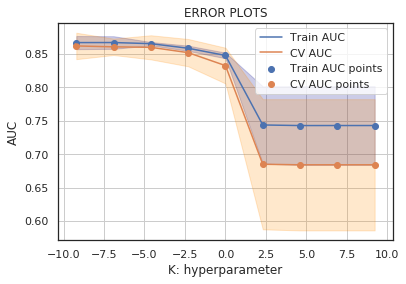

In [71]:

import math
logs = []
parameters = {'alpha':[10**-4,10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3,10**4]}
for i in parameters['alpha']:
    b = math.log(i)
    logs.append(b)

neigh = SGDClassifier(loss = 'hinge',penalty = 'l2',class_weight = 'balanced')



clf = GridSearchCV(neigh, parameters, cv=5, scoring='roc_auc',return_train_score=True)
#fit on train features and the classification target features.
clf.fit(features_train, target_2_train.values.ravel()) #change dim from (n) to (n,)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

plt.plot(logs, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(logs,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(logs, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(logs,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(logs, train_auc, label='Train AUC points')
plt.scatter(logs, cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [72]:
#target_2_test = target_2_test.astype('int')

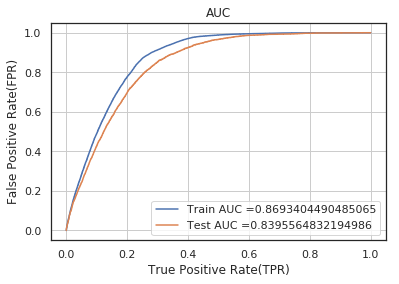

In [73]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.svm import SVC


neigh = SGDClassifier(loss = 'hinge', penalty= 'l2',alpha = 10**-4,class_weight='balanced')
neigh.fit(features_train, target_2_train.values.ravel())
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = neigh.decision_function(features_train)

y_test_pred = neigh.decision_function(features_test)

train_fpr, train_tpr, tr_thresholds = roc_curve(target_2_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(target_2_test, y_test_pred)


plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("True Positive Rate(TPR)")
plt.ylabel("False Positive Rate(FPR)")
plt.title("AUC")
plt.grid()
plt.show()

- We will now reshape the predicted values of the calssification model so that we can horizontally stack them with the features.

In [74]:
y_train_new = y_train_pred.reshape((target_2_train.shape[0],1))
y_new = y_test_pred.reshape((target_2_test.shape[0] ,1))

#### We will now stack the predicted classification values and build a regression model on top of this.

In [75]:
new_train = hstack((features_train,target_2_train))
new_test = hstack((features_test,y_new))

### Light GBM regression model

In [76]:
params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 70,
        "min_data_in_leaf":20,
        "max_depth":10
        
    }
    
    # convert our training data into LightGBM dataset format:
lgtrain = lgb.Dataset(new_train, label=target_train)
#lgval = lgb.Dataset(val_X, label=val_y)
model = lgb.train(params, lgtrain)
pred_test_y = model.predict(new_test)
rmse = np.sqrt(mean_squared_error(pred_test_y, target_test))
rmse

/home/mayankkhanna3340/.local/lib/python3.5/site-packages/lightgbm/basic.py:546: UserWarning:

Converting data to scipy sparse matrix.



9.486962476254506

In [77]:
rmse = np.sqrt(mean_squared_error(pred_test_y, target_test))
rmse

9.486962476254506

### XGBoost Regressor

In [78]:
x_model = xgb.XGBRegressor(
 learning_rate =0.1,
 n_estimators=50,
 max_depth=6,
 min_child_weight=1,
 gamma=0,
 subsample=0.6,
 reg_alpha=200, reg_lambda=200,
 colsample_bytree=0.8,nthread=4)
x_model.fit(new_train, target_train)

[08:51:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=None, n_estimators=50,
             n_jobs=1, nthread=4, objective='reg:linear', random_state=0,
             reg_alpha=200, reg_lambda=200, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.6, verbosity=1)

In [79]:
y_pred = x_model.predict(new_test)

In [80]:
rmse = np.sqrt(mean_squared_error(y_pred, target_test))
rmse

8.980658270775246

# Conclusion

In [1]:
from prettytable import PrettyTable

In [2]:
x = PrettyTable()

x.field_names = ["Method", "RMSE"]

x.add_row(["Light GBM", 2.04])
x.add_row(["XGBoost", 1.98])
x.add_row(["Catboost",2.04])
x.add_row(["light gbm after classification", 9.48])
x.add_row(["XGboost after classification", 8.98])

print(x)

+--------------------------------+------+
|             Method             | RMSE |
+--------------------------------+------+
|           Light GBM            | 2.04 |
|            XGBoost             | 1.98 |
|            Catboost            | 2.04 |
| light gbm after classification | 9.48 |
|  XGboost after classification  | 8.98 |
+--------------------------------+------+


# Regression Models with XG Boost

- Our final approach to this problem consists of using regression techniques to get the predicted values on forward data, and then run a XGBoost model using the predicted values as features to the model.
- For this approach, we make an assumption that users who did not make a purchase are not likely to make one in the future either. Therefore, we just directly score them 0.
https://www.kaggle.com/c/ga-customer-revenue-prediction/discussion/82726

In [4]:
#loading and concatenating train and test data. the date is cinverted to string and in a date format readable by python
df_train = pd.read_csv('train-flattened.csv')
df_test = pd.read_csv('test-flattened.csv')

df_train['date'] = df_train['date'].astype(str)
df_train["date"] = df_train["date"].apply(lambda x : x[:4] + "-" + x[4:6] + "-" + x[6:])
df_train["date"] = pd.to_datetime(df_train["date"])

df_test['date'] = df_test['date'].astype(str)
df_test["date"] = df_test["date"].apply(lambda x : x[:4] + "-" + x[4:6] + "-" + x[6:])
df_test["date"] = pd.to_datetime(df_test["date"])


df = pd.concat([df_train,df_test])

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:3058: DtypeWarning:

Columns (2,52) have mixed types. Specify dtype option on import or set low_memory=False.

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:3058: DtypeWarning:

Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:14: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




In [5]:
df = df.fillna(0)
df['totals.totalTransactionRevenue'] = df['totals.totalTransactionRevenue'].fillna(0).astype(float)
# all unique users who visited the website
revenue_user = df.groupby('fullVisitorId')['totals.totalTransactionRevenue'].sum().reset_index()

In [6]:
#unique users with positive revenue ~ 20724
users_pos = revenue_user[revenue_user['totals.totalTransactionRevenue']>0.0]

In [7]:
# row enteries from the original dataframe where people made total positive revenue ~ 68046
df_users_pos = df[df['fullVisitorId'].isin(users_pos['fullVisitorId'])]

/usr/local/lib/python3.5/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()



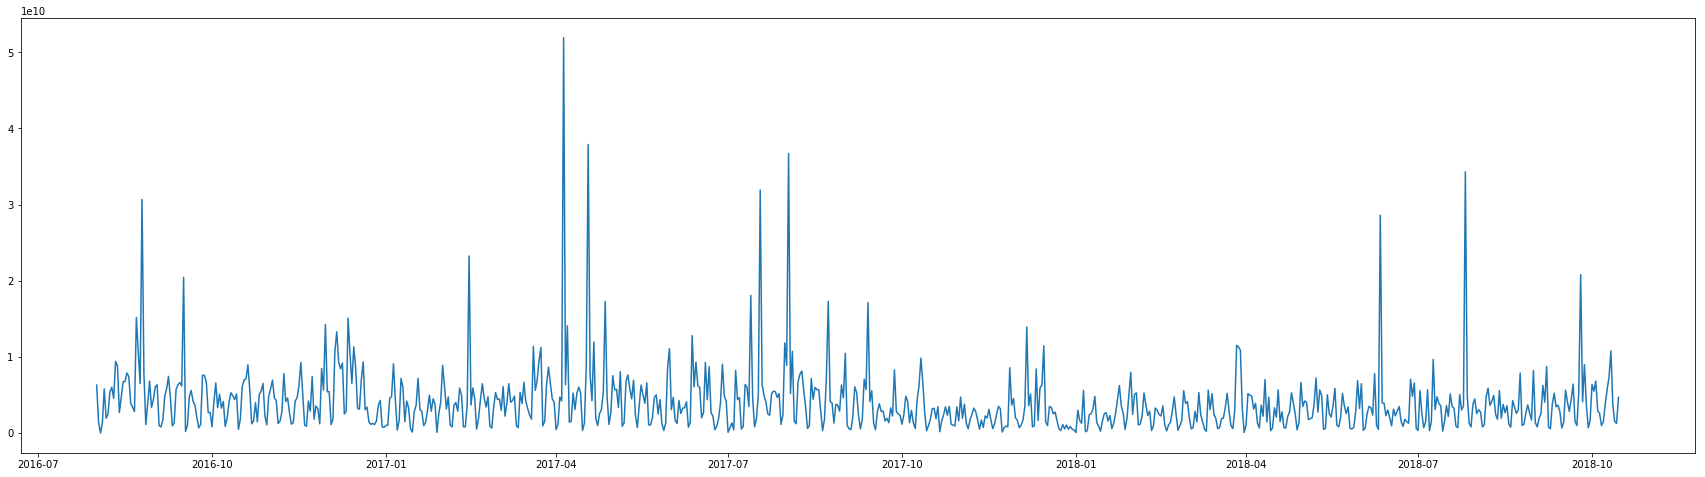

In [9]:
# we find the revenue by date bu only users who have a positive revenue
# revenue by date
rev_by_date = df_users_pos.groupby('date')['totals.totalTransactionRevenue'].sum().reset_index()
plt.figure(figsize=(30,8))
plt.plot(rev_by_date['date'], rev_by_date['totals.totalTransactionRevenue']);

- Using FBProphet, we will take 4 features and then make a regression model using these 4 features

In [10]:
# Preparing data frames
norm_pred = pd.DataFrame( {'ds':rev_by_date['date'].values,'y':rev_by_date['totals.totalTransactionRevenue'].values})
box_cox_pred = pd.DataFrame( {'ds':rev_by_date['date'].values,'y':rev_by_date['totals.totalTransactionRevenue'].values})
DXS = pd.DataFrame({'ds':rev_by_date['date'].values,'y':rev_by_date['totals.totalTransactionRevenue'].values})
TXS = pd.DataFrame({'ds':rev_by_date['date'].values,'y':rev_by_date['totals.totalTransactionRevenue'].values})

### Forward prediction on transaction revenues

In [11]:
#https://towardsdatascience.com/forecasting-in-python-with-facebook-prophet-29810eb57e66
#https://facebook.github.io/prophet/docs/quick_start.html#python-api
#Uses an additive model and has particularly good performance for non linear data

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


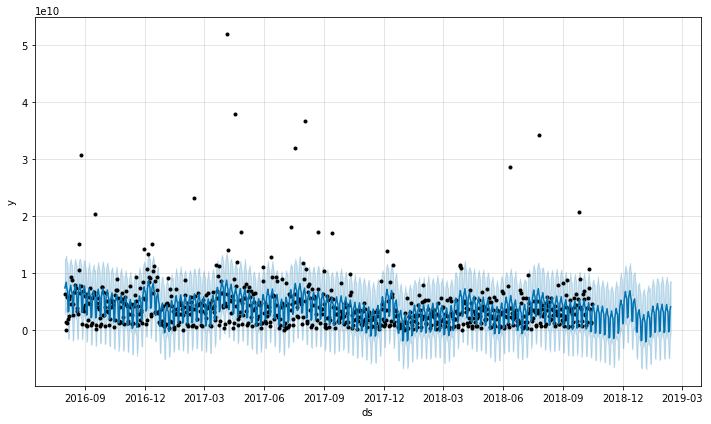

In [12]:
from fbprophet import Prophet
prophet = Prophet()
prophet.fit(norm_pred)
future = prophet.make_future_dataframe(periods=4*30, freq='D')
forecast_norm = prophet.predict(future)
fig = prophet.plot(forecast_norm)

### Box Cox Transform and prediction using FB Prophet

In [13]:
#https://www.statisticshowto.datasciencecentral.com/box-cox-transformation/

- We will also use a box-cox transform. A box cox tranform transforms the data to a normal distributon. 
- It is generally seen that ML models work better with Normally distributed data
- We will then take the transformed data and run it through fbprophet to get the final values. 
- We will then take the inverse box cox on the predicted fbprophet vlues to get the data according to the original distribution.

In [14]:
from scipy.stats import boxcox
from scipy.special import inv_boxcox
box_arr,lamb = boxcox(box_cox_pred['y'].values + 1)

In [15]:
del box_cox_pred['y']
box_cox_pred['y'] = box_arr

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


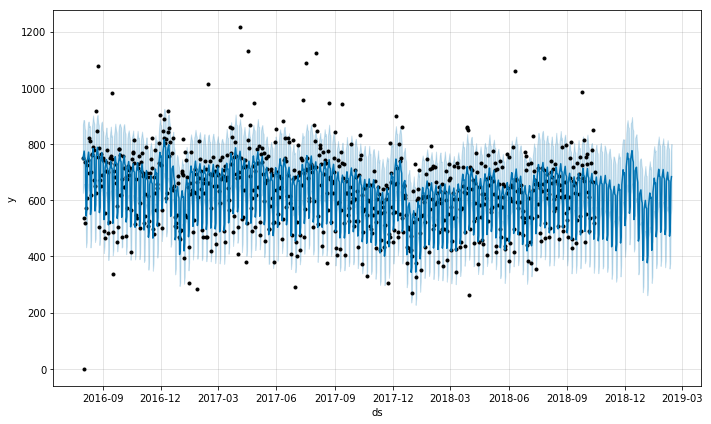

In [16]:
prophet = Prophet()
prophet.fit(box_cox_pred)
future = prophet.make_future_dataframe(periods=4*30, freq='D')
forecast_box = prophet.predict(future)
fig = prophet.plot(forecast_box)

In [17]:
forecast_box['yhat'] = inv_boxcox(forecast_box['yhat'], lamb)

### Double Exponential Smoothing and forward prediction using FB Prophet

One of the drawbacks of single exponential smothing is that it does not account for trends in the data. This can be improved by introducing an additional equation to account for trend in the data. Double Exponential Smoothing uses two equations to forecast the future values of time series data - one for forecasting the level and the other for forecasting the trend. 

In [18]:
##https://grisha.org/blog/2016/02/17/triple-exponential-smoothing-forecasting-part-iii/

In [19]:
#ℓx=αyx+(1−α)(ℓx−1+bx−1)level - predicted value 
#bx=β(ℓx−ℓx−1)+(1−β)bx−1trend - slope (delta(y)/delta(x)) - since delta(x) = 1, we take slope as y(new) - y(old)
#y^x+1=ℓx+bxforecast
#series - ordered sequence of numbers. naive method of predicting series is y(new) = y(old)

def double_exponential_smoothing(series,alpha,beta):
    # we take the first element as the first result since we need something to begin with
    result = [series[0]]
    for n in range(1,len(series)+1):
        # case for the first datapoint.
        if n == 1:
            level,trend = series[0],series[1]-series[0]
        if n >= len(series):
            #case for the last datapoint 
            value = result[-1]
        else:
            value = series[n]
        # just applying the formulae here
        last_level,level = level,alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level)+(1-beta)*trend
        result.append(level+trend)
    return result

alpha = 0.2
beta = 0.15

DXS_pred = double_exponential_smoothing(DXS['y'].values, alpha, beta)

In [20]:
del DXS['y']
DXS['y'] = DXS_pred[1:]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


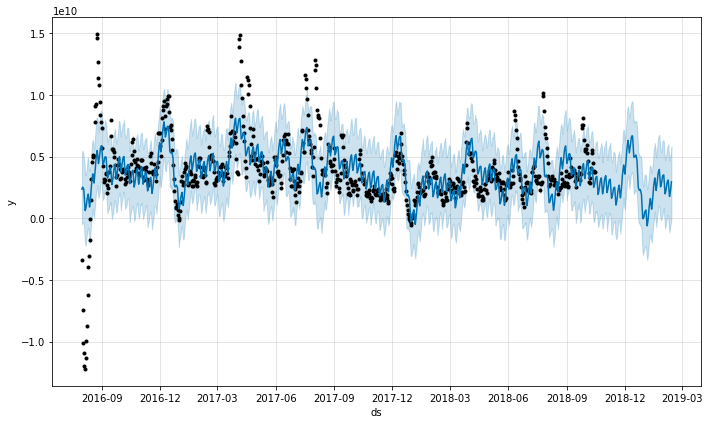

In [21]:
prophet = Prophet()
prophet.fit(DXS)
future = prophet.make_future_dataframe(periods=4*30, freq='D')
forecast_DXS = prophet.predict(future)
fig = prophet.plot(forecast_DXS)

### Triple exponential Smoothing

If there is seasonality in the data, the techniques discussed so far may fall short. Triple exponential smoothing is used when the data has trend and seasonality. 

In [22]:
#ℓx=α(yx−sx−L)+(1−α)(ℓx−1+bx−1) level
#bx=β(ℓx−ℓx−1)+(1−β)bx−1 Trend
#sx=γ(yx−ℓx)+(1−γ)sx−L seasonal
#y^x+m=ℓx+mbx+sx−L+1+(m−1) modL

def initial_trend(series,slen):
    s = 0.0
    for i in range(slen):
        s += float(series[i+slen]-series[i])/slen
    return s/slen

def initial_seasonal_components(series, slen):
    #Season length is the number of data points after which a new season begins. We will use L to denote season length.
    #The seasonal component is an additional deviation from level + trend that repeats itself at the same offset into the season.
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [23]:
#slen - 30; number of data points after which the new season length begins.
alpha = 0.2
beta = 0.15
gamma = 0.1
slen = 30
XS_pred = triple_exponential_smoothing(TXS['y'].values,slen, alpha, beta,gamma,1)

In [24]:
del TXS['y']
TXS['y'] = XS_pred[1:]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


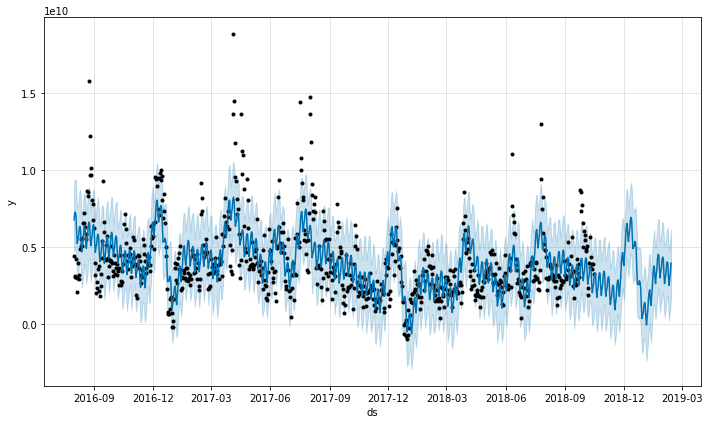

In [25]:
prophet = Prophet()
prophet.fit(TXS)
future = prophet.make_future_dataframe(periods=4*30, freq='D')
forecast_TXS = prophet.predict(future)
fig = prophet.plot(forecast_TXS)

### XGBoost Regression Modle

- We will now use the the forecasted values as features and apply regression models on it

In [26]:
#preparing data for regression
forecast_norm.rename(columns = {'ds':'date'},inplace = True)
forecast_box.rename(columns = {'ds':'date'},inplace = True)
forecast_DXS.rename(columns = {'ds':'date'},inplace = True)
forecast_TXS.rename(columns = {'ds':'date'},inplace = True)


In [27]:
#preparing data from regression
drop_list = ['date','yhat']
forecast_norm = forecast_norm.drop(forecast_norm.columns.difference(drop_list), axis=1)
forecast_box = forecast_box.drop(forecast_box.columns.difference(drop_list), axis=1)
forecast_DXS = forecast_DXS.drop(forecast_DXS.columns.difference(drop_list), axis=1)
forecast_TXS = forecast_TXS.drop(forecast_TXS.columns.difference(drop_list), axis=1)


In [28]:
#prepareing data for regression
forecast_norm.rename(columns= {'yhat':'1'},inplace = True)
forecast_box.rename(columns= {'yhat':'2'},inplace = True)
forecast_DXS.rename(columns= {'yhat':'3'},inplace = True)
forecast_TXS.rename(columns= {'yhat':'4'},inplace = True)

In [29]:
reg_data = pd.merge(rev_by_date,forecast_norm,on = 'date',how = 'left')
reg_data= pd.merge(reg_data,forecast_box,on = 'date',how = 'left')
reg_data= pd.merge(reg_data,forecast_DXS,on = 'date',how = 'left')
reg_data= pd.merge(reg_data,forecast_TXS,on = 'date',how = 'left')

In [30]:
y = reg_data['totals.totalTransactionRevenue'].values
del reg_data['totals.totalTransactionRevenue']
del reg_data['date']

In [31]:
X_train, X_test = np.split(reg_data, [int(.75 *len(reg_data))])
Y_train,Y_test = np.split(y, [int(.75 *len(y))])

## XGBoost on features

In [32]:
regr2 = xgb.XGBRegressor(n_jobs=-1)
param_grid = {'max_depth':[2,3,4,5,6],'min_child_weight':[1,2,3,4,5,6],'subsample':[.4,.6,.8],'n_estimators':[50,100,300,500,1000]}
gs_xgb = RandomizedSearchCV(regr2,param_grid,scoring = 'neg_mean_squared_error')
gs_xgb.fit(X_train, Y_train)

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



[13:22:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:22:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:22:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:22:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:22:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:22:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:22:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:22:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=-1, nthread=None,
                                          objective='reg:linear',
                                          ran...
                                          reg_lambda=1, scale_pos_weight=1,
                                          seed=None, silent=None, subsample=1,
                                  

In [33]:
gs_xgb.best_params_

{'max_depth': 6, 'min_child_weight': 6, 'n_estimators': 300, 'subsample': 0.4}

In [34]:
x_model = xgb.XGBRegressor(
 learning_rate =0.01,
 n_estimators=50,
 max_depth=2,
 min_child_weight=0.6,
 
 subsample=0.4,
 
 nthread=8)
x_model.fit(X_train, Y_train)

[13:23:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=2, min_child_weight=0.6, missing=None, n_estimators=50,
             n_jobs=1, nthread=8, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.4, verbosity=1)

In [35]:
pred_norm = forecast_norm.loc[(forecast_norm['date'] >= '2018-12-01')&(forecast_norm['date']<='2019-01-31')]
pred_box = forecast_box.loc[(forecast_box['date'] >= '2018-12-01')&(forecast_box['date']<='2019-01-31')]
pred_DXS = forecast_DXS.loc[(forecast_DXS['date'] >= '2018-12-01')&(forecast_DXS['date']<='2019-01-31')]
pred_TXS = forecast_TXS.loc[(forecast_TXS['date'] >= '2018-12-01')&(forecast_TXS['date']<='2019-01-31')]

In [36]:
from functools import reduce
dfs = [pred_norm, pred_box, pred_DXS, pred_TXS]
final_data = reduce(lambda left,right: pd.merge(left,right,on='date'), dfs)
del final_data['date']

In [37]:
y_pred = x_model.predict(final_data)

In [44]:
pickle.dump(x_model, open("XGBoost-mod.pickle.dat", "wb"))

In [39]:
# we are seeing what ratio of the total transaction value of the whole dataset did a particular user contribute. 
distribution_by_visitor = (df.groupby('fullVisitorId')['totals.totalTransactionRevenue'].sum() / df.groupby('fullVisitorId')['totals.totalTransactionRevenue'].sum().sum())

In [40]:
distribution_by_visitor

fullVisitorId
259678714014           0.0
1995526696366          0.0
3038793126460          0.0
4823595352351          0.0
5103959234087          0.0
                      ... 
9999819762744314978    0.0
9999824326944242344    0.0
9999825631375939274    0.0
9999941518946450908    0.0
9999997304197521748    0.0
Name: totals.totalTransactionRevenue, Length: 1669227, dtype: float64

In [41]:
# sum of every transaction divided by the length of all users. This tells us on an aveage, how much to scale the outut by
scale = (df_users_pos['totals.totalTransactionRevenue'] > 0).sum() / len(df_users_pos)
# here we're scaling the prediction of the model by a scale that we set. We are saying that each user will buy proportionally more 
# as the value of the scale multiplied by the total sum of prediction and the value of what he bought earlier.
# as in, customer who spent more is spend more in this period as well.
distr_res = np.log1p(distribution_by_visitor * scale * y_pred.sum())

In [42]:
#Source : Kaggle 
sample = pd.read_csv('sample_submission_v2.csv', dtype={'fullVisitorId': 'str'}, )
solution = sample.merge(distr_res.reset_index(), on='fullVisitorId', how='left')
solution = (solution.drop('PredictedLogRevenue', axis=1).rename(columns={'totals.totalTransactionRevenue': 'PredictedLogRevenue'}))
solution['PredictedLogRevenue'].astype(float).fillna(0).reset_index()
solution.to_csv('sub.csv', index=False,na_rep = 0.0)

## Light GBM

In [62]:
#light GBM
param_grid = {
    'num_leaves': [10,30,50,70,90],
    'min_data_in_leaf': [1, 5, 10,20,30],
    'max_depth': [5,10,20, 30, 50],
    }

est = lgb.LGBMRegressor()
grid = GridSearchCV(est, param_grid,verbose=0,cv=4,n_jobs=-1)
grid.fit(X_train,Y_train)
print(grid.best_params_)
print(grid.best_score_)

{'min_data_in_leaf': 20, 'max_depth': 5, 'num_leaves': 10}
0.1657578962955516


In [ ]:
params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 10,
        "min_data_in_leaf":20,
        "max_depth":5
        
    }
    
    # convert our training data into LightGBM dataset format:
lgtrain = lgb.Dataset(X_train, label=Y_train)
#lgval = lgb.Dataset(val_X, label=val_y)
model = lgb.train(params, lgtrain)
pred_test_y = model.predict(reg_data)

## Catboost

In [ ]:
from catboost import CatBoostRegressor
model = CatBoostRegressor(
                             learning_rate=0.05,
                             depth=10,
                             eval_metric='RMSE',
                             random_seed = 42,
                             bagging_temperature = 0.4,
                             od_type='Iter',
                             task_type="CPU")

model.fit(X_train, Y_train)


y_pred_test = model.predict(reg_data)


# Results

In [73]:
print ("(Tree Based Regression Methods) -       RMSE")
print ("--------------------------------------------------------------------------------------------------------")
print ("XGBOOST                             : ",0.948)
print ("CAT Boost                           : ",0.986)
print ("Light GBM                           : ",0.983)


(Tree Based Regression Methods) -       RMSE
--------------------------------------------------------------------------------------------------------
XGBOOST                             :  0.948
CAT Boost                           :  0.986
Light GBM                           :  0.983


# Detailed Approach

- In this case study, my first approach was to featurize the some numerical columns using normalizer and categorical columns using One hot encoding. 
- After stacking these features, I used a XG Boost model that would predict the regression values, group them by the full visitor ID and submit for the final score. 
- I also built a classifier which would first classify whether a transaction took place or not, and using the predicted values, as an added feature, I predicted regression values. 
- The primary mistake with this method was that we were asked to predict values for a time in the future, for which we had no data. Predicting values on the basis of features present for a different time period gave inaccurate results.

- Hence, my final approach was to use FB Prophet -a library built by facebook that can be used for prediction of forward values. Here, I also assume that customers who did not make a transaction in the past are unlikely to make one in the future.
- I first grouped the revenue by date and predicted the forward values and saved the values seperately. These will be used as feature 1.
- The second feature will be box-cox transformed values predicted for forward data using fb prophet.
- The third feature will be Double exponential smoothing and prediction of thses values for forward data.
- The fourth feature will be triple exponential smoothing and forward prediciton for these values.
- For the forward prediction of all the features, we have used fb prophet.
- I then divide the train and test data in a ratio of 75:25 Train and Test Data.
- We take the features for the date of 31-December 2018 and 1-January 2019 predict the actual revenue using a XG Boost model.
- I then distribute the values according to the same distribution of the values in train data.
- This approach gives us an RMSE score of 0.945 on kaggle which comes into the top 10% of all kaggle teams.